In [2]:
import os
#New figure that has magnitude, length, width and slip only instead of the model parameters
import matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
from scipy import stats
import seaborn as sn
import glob
from functools import reduce

#import combine_run_data

In [3]:
import cartopy
import cartopy.crs as ccrs

In [4]:
%matplotlib notebook

In [5]:
plt.style.use('seaborn')

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [8]:
#dirs = glob.glob('August5_runs/4*/')
dirs = glob.glob('September14/4*/')
samples = []
model_params = []
model_output = []
bayes_data = []
debug = []
data = (['samples', 'model_params', 'model_output', 'bayes_data','debug'], [samples, model_params, model_output, bayes_data, debug])

for dir_ in dirs:
    for kind,lst in zip(*data):
        k = 1
        df = pd.read_csv(dir_+kind+'.csv', index_col=0).iloc[k:].reset_index(drop=True)
        lst.append(df)

In [9]:
#rundir = 'August5_runs'
rundir = 'September14'

chains_samples = {}
for file in os.listdir(rundir):
    if file[0] != '.' and file[-3:-1] == '_m':
        try:
            chains_samples[file] = pd.read_csv(os.path.join(rundir, file, "samples.csv"),
                                      index_col=0).reset_index(drop=True)
        except FileNotFoundError:
            print(f"SLURM ID {file[:-3]} has no samples data")
            chains_samples[file] = None

            
chains_params = {}
for file in os.listdir(rundir):
    if file[0] != '.' and file[-3:-1] == '_m':
        try:
            chains_params[file] = pd.read_csv(os.path.join(rundir, file, "model_params.csv"),
                                      index_col=0).reset_index(drop=True)
        except FileNotFoundError:
            print(f"SLURM ID {file[:-3]} has no params data")
            chains_params[file] = None
            
            
chains_output = {}
for file in os.listdir(rundir):
    if file[0] != '.' and file[-3:-1] == '_m':
        try:
            chains_output[file] = pd.read_csv(os.path.join(rundir, file, "model_output.csv"),
                                      index_col=0).reset_index(drop=True)
        except FileNotFoundError:
            print(f"SLURM ID {file[:-3]} has no output data")
            chains_output[file] = None
            
            
chains_bayes_data = {}
for file in os.listdir(rundir):
    if file[0] != '.' and file[-3:-1] == '_m':
        try:
            chains_bayes_data[file] = pd.read_csv(os.path.join(rundir, file, "bayes_data.csv"),
                                      index_col=0).reset_index(drop=True)
        except FileNotFoundError:
            print(f"SLURM ID {file[:-3]} has no bayes_data data")
            chains_bayes_data[file] = None
            
            
chains_debug = {}
for file in os.listdir(rundir):
    if file[0] != '.' and file[-3:-1] == '_m':
        try:
            chains_debug[file] = pd.read_csv(os.path.join(rundir, file, "debug.csv"),
                                      index_col=0).reset_index(drop=True)
        except FileNotFoundError:
            print(f"SLURM ID {file[:-3]} has no debug data")
            chains_debug[file] = None

In [7]:
all_samples=pd.concat(samples,ignore_index=True)
all_model_params=pd.concat(model_params,ignore_index=True)
all_model_output=pd.concat(model_output,ignore_index=True)
all_bayes_data = pd.concat(bayes_data,ignore_index=True)
all_debug = pd.concat(debug,ignore_index=True)

In [8]:
all_debug.columns

Index(['latitude', 'longitude', 'magnitude', 'delta_logl', 'delta_logw',
       'depth_offset', 'dip_offset', 'strike_offset', 'rake_offset',
       'fault_idx', 'p_latitude', 'p_longitude', 'p_magnitude', 'p_delta_logl',
       'p_delta_logw', 'p_depth_offset', 'p_dip_offset', 'p_strike_offset',
       'p_rake_offset', 'p_fault_idx', 'm_latitude', 'm_longitude', 'length',
       'width', 'slip', 'strike', 'dip', 'depth', 'rake', 'm_depth_offset',
       'm_rake_offset', 'm_dip_offset', 'm_strike_offset', 'p_m_latitude',
       'p_m_longitude', 'p_length', 'p_width', 'p_slip', 'p_strike', 'p_dip',
       'p_depth', 'p_rake', 'p_m_depth_offset', 'p_m_rake_offset',
       'p_m_dip_offset', 'p_m_strike_offset', 'prior_logpdf', 'llh',
       'posterior_logpdf', 'p_prior_logpdf', 'p_llh', 'p_posterior_logpdf',
       'alpha', 'accepted', 'acceptance_rate'],
      dtype='object')

In [9]:
parameters = {'latitude':'Latitude', 'longitude':'Longitude', 'magnitude':'Magnitude', 'delta_logl':'$\Delta \log L$',
             'delta_logw':'$\Delta \log W$', 'depth_offset':'Depth Offset', 'dip_offset':'Dip Offset',
             'strike_offset':'Strike Offset', 'rake_offset':'Rake Offset'}

In [10]:
walane_samples=all_samples.loc[all_samples['fault_idx']==1]
flores_samples=all_samples.loc[all_samples['fault_idx']==0]
walane_model_params=all_model_params.loc[all_samples['fault_idx']==1]
flores_model_params=all_model_params.loc[all_samples['fault_idx']==0]
walane_model_output=all_model_output.loc[all_samples['fault_idx']==1]
flores_model_output=all_model_output.loc[all_samples['fault_idx']==0]
walane_bayes_data=all_bayes_data.loc[all_samples['fault_idx']==1]
flores_bayes_data=all_bayes_data.loc[all_samples['fault_idx']==0]

In [1]:
#Change to local directories, or wherever this data is stored...
flores=pd.read_excel('/Users/jaredwhitehead/tsunamibayes/current_work/1820_fault_data/FloresThrustSplit_TableToExcel.xlsx')
walane=pd.read_excel('/Users/jaredwhitehead/tsunamibayes/current_work/1820_fault_data/WalinaeFaultSplit_TableToExcel.xlsx')
walane2=pd.read_excel('/Users/jaredwhitehead/tsunamibayes/current_work/1820_fault_data/WalanaeHypoSegments.xlsx')
flores_lats, flores_lons = flores[['CenterLat', 'CenterLong']].to_numpy().T
walane_lats, walane_lons = walane[['CenterLat', 'CenterLong']].to_numpy().T
walane2_lats, walane2_lons = walane2[['Lat', 'Long']].to_numpy().T

NameError: name 'pd' is not defined

In [12]:
walane_finite_llh=walane_samples.loc[np.isfinite(walane_bayes_data['llh'])]
flores_finite_llh=flores_samples.loc[np.isfinite(flores_bayes_data['llh'])]
walane_output_finite_llh = walane_model_output.loc[np.isfinite(walane_bayes_data['llh'])]
flores_output_finite_llh = flores_model_output.loc[np.isfinite(flores_bayes_data['llh'])]

In [13]:
all_model_params

latitude   longitude         length          width       slip  \
0      -6.761551  119.951134  206792.708801   80861.565637  14.588640   
1      -6.761551  119.951134  206792.708801   80861.565637  14.588640   
2      -6.761551  119.951134  206792.708801   80861.565637  14.588640   
3      -6.761551  119.951134  206792.708801   80861.565637  14.588640   
4      -6.793402  119.932249  216122.181844   82496.759271  14.877905   
...          ...         ...            ...            ...        ...   
232655 -6.944331  119.856613  224849.173916  100903.890114   6.344083   
232656 -6.944331  119.856613  224849.173916  100903.890114   6.344083   
232657 -6.944331  119.856613  224849.173916  100903.890114   6.344083   
232658 -6.944331  119.856613  224849.173916  100903.890114   6.344083   
232659 -6.944331  119.856613  224849.173916  100903.890114   6.344083   

            strike   dip         depth  rake  depth_offset  rake_offset  \
0       183.248535  25.0  23191.122158  80.0     -4.425621    -0.835560   
1       183.248535  25.0  23191.122158  80.0     -4.425621    -0.835560   
2       183.248535  25.0  23191.122158  80.0     -4.425621    -0.835560   
3       183.248535  25.0  23191.122158  80.0     -4.425621    -0.835560   
4       183.456754  25.0  24938.684934  80.0     -4.052337     3.066257   
...            ...   ...           ...   ...           ...          ...   
232655  184.343026  25.0  27280.733848  80.0     -5.084235    -0.442551   
232656  184.343026  25.0  27280.733848  80.0     -5.084235    -0.442551   
232657  184.343026  25.0  27280.733848  80.0     -5.084235    -0.442551   
232658  184.343026  25.0  27280.733848  80.0     -5.084235    -0.442551   
232659  184.343026  25.0  27280.733848  80.0     -5.084235    -0.442551   

        dip_offset  strike_offset  
0         1.480481       0.568101  
1         1.480481       0.568101  
2         1.480481       0.568101  
3         1.480481       0.568101  
4         2.237186       3.162006  
...            ...            ...  
232655    7.285851       1.395180  
232656    7.285851       1.395180  
232657    7.285851       1.395180  
232658    7.285851       1.395180  
232659    7.285851       1.395180  

[232660 rows x 13 columns]

In [14]:
all_bayes_data.to_csv('all_bayes_data.csv')

In [15]:
all_samples.to_csv('all_samples.csv')

In [16]:
all_model_params.to_csv('all_model_params.csv')

In [17]:
all_model_output.to_csv('all_model_output.csv')

<IPython.core.display.Javascript object>


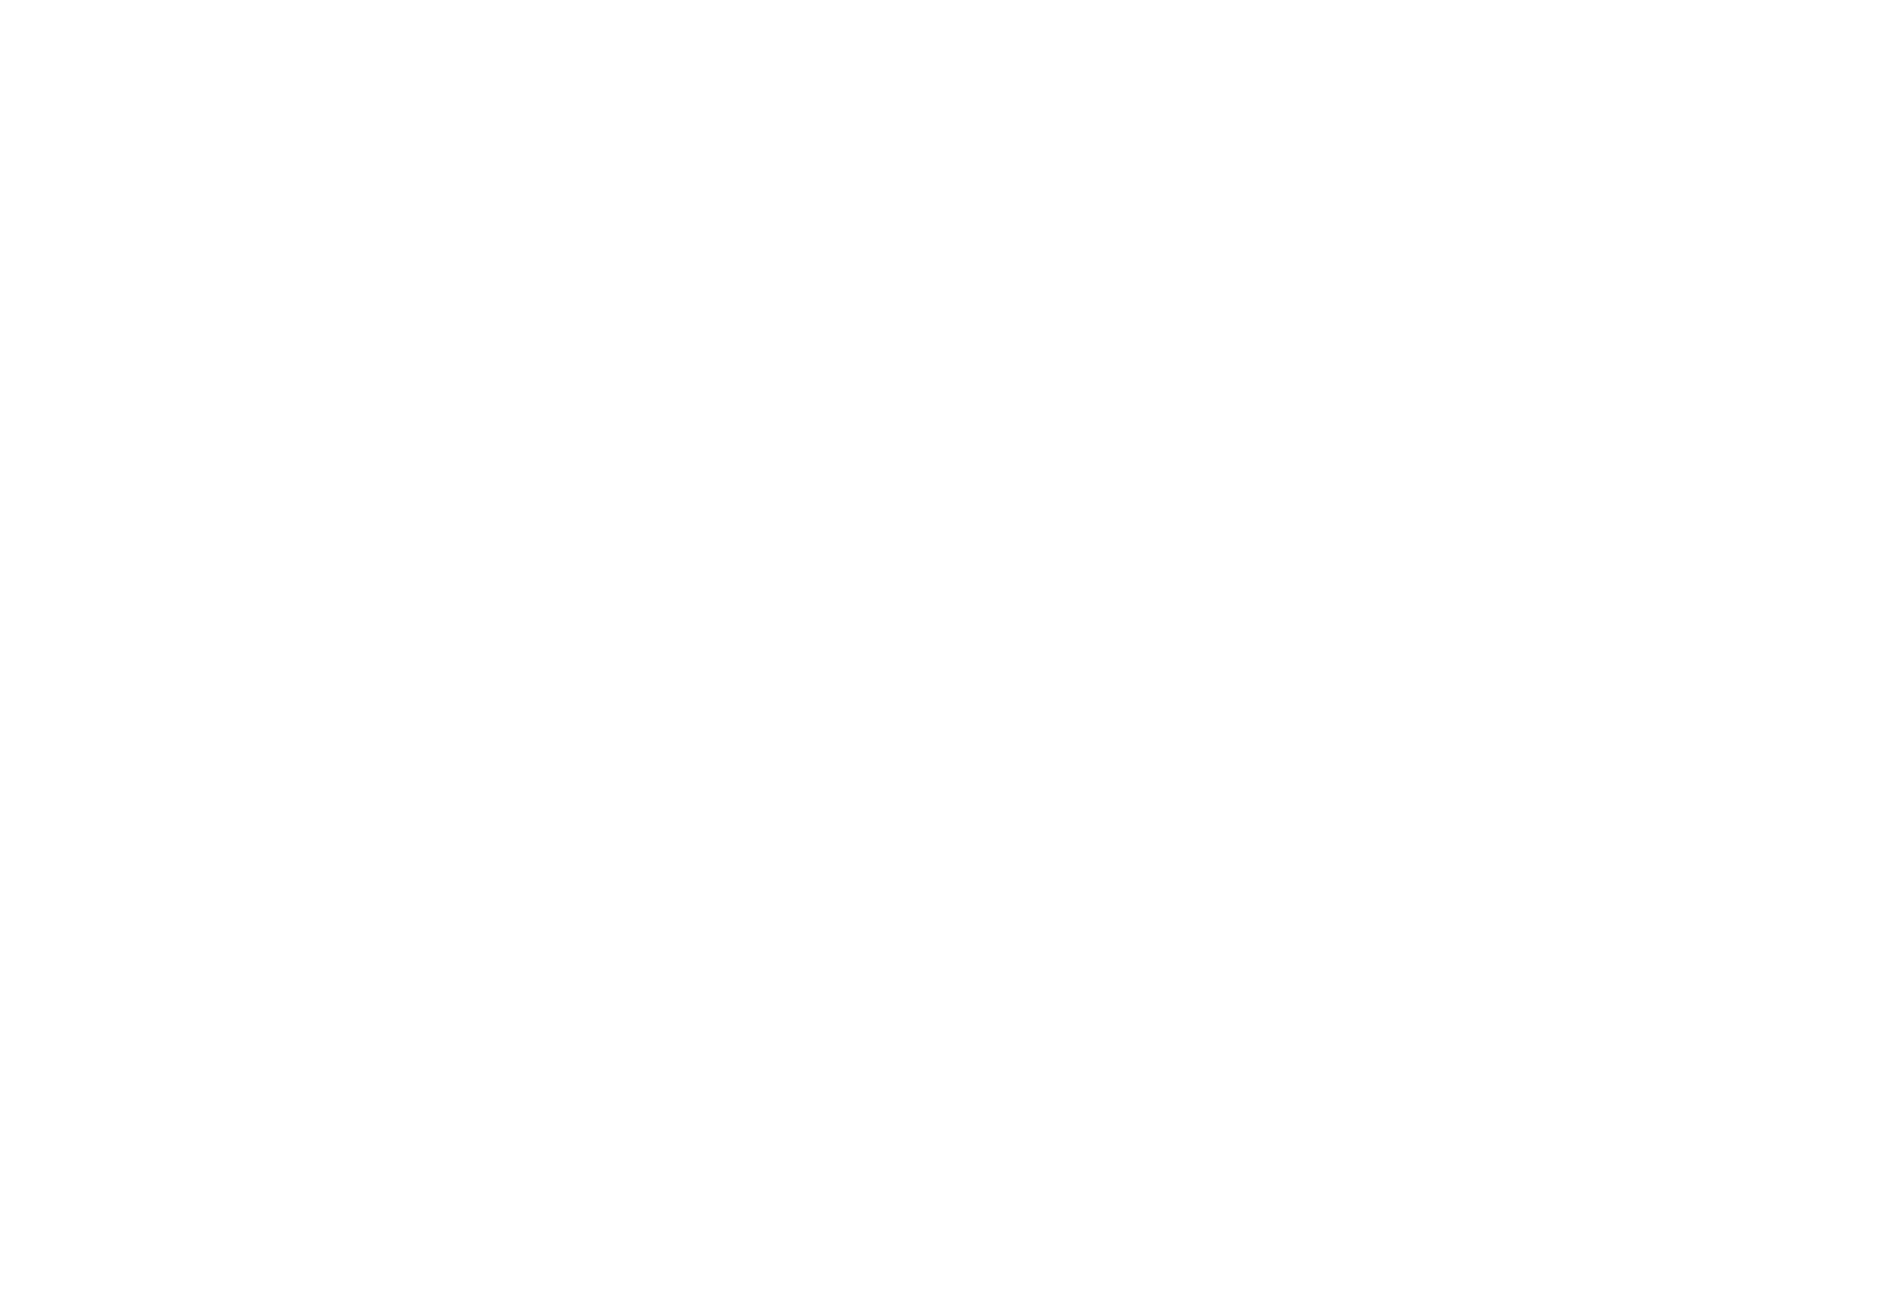

In [18]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(9.5,6.5), dpi=100)
ax = plt.axes(projection=crs)
#ax = plt.axes()
ax.set_extent((112.5,123,-10,-3))
ax.coastlines(resolution='10m',color='gray',zorder=0)
plt.xticks(np.arange(112.5,123))
plt.yticks(np.arange(-10,-3))


bulukumba_lat, bulukumba_lon = -5.5675, 120.1915
sumenep_lat, sumenep_lon = -7.049, 113.913
nipanipa_lat, nipanipa_lon = -5.569, 120.005
bima_lat, bima_lon = -8.4502, 118.7169

plt.scatter([bulukumba_lon, sumenep_lon, nipanipa_lon, bima_lon],
            [bulukumba_lat, sumenep_lat, nipanipa_lat, bima_lat],
           s=48, c='red', edgecolors='black', label='Observation Points')
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.annotate('Bulukumba',xy=(bulukumba_lon,bulukumba_lat),xytext=(121,-5),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1,headwidth=5))
plt.annotate('Sumenep',xy=(sumenep_lon,sumenep_lat),xytext=(113.5,-6.5),
            arrowprops=dict(facecolor='black',shrink=0.05,width=1,headwidth=5))
plt.annotate('Nipa-Nipa',xy=(nipanipa_lon,nipanipa_lat),xytext=(120,-6),
            arrowprops=dict(facecolor='black',shrink=0.05,width=1,headwidth=5))
plt.annotate('Bima',xy=(bima_lon,bima_lat),xytext=(119,-9),
            arrowprops=dict(facecolor='black',shrink=0.05,width=1,headwidth=5))

#plt.scatter(np.append(flores_lons, walane_lons), np.append(flores_lats, walane_lats),
#            s=1, c='b', label='Fault Lines')
#plt.scatter(flores_lons, flores_lats, s=1,c='g',label='Flores fault line')
plt.plot(flores_lons, flores_lats, c='g',label='Flores fault line')
#plt.scatter(walane_lons, walane_lats, s=1,c='b',label='Walanae fault line')
plt.plot(walane_lons, walane_lats, c='b',label='Walanae fault line')

lgnd = plt.legend(fontsize=16)
lgnd.legendHandles[1]._sizes = [48]
lgnd.legendHandles[2]._sizes = [48]


plt.savefig('faults_obs_pts.pdf')

<IPython.core.display.Javascript object>


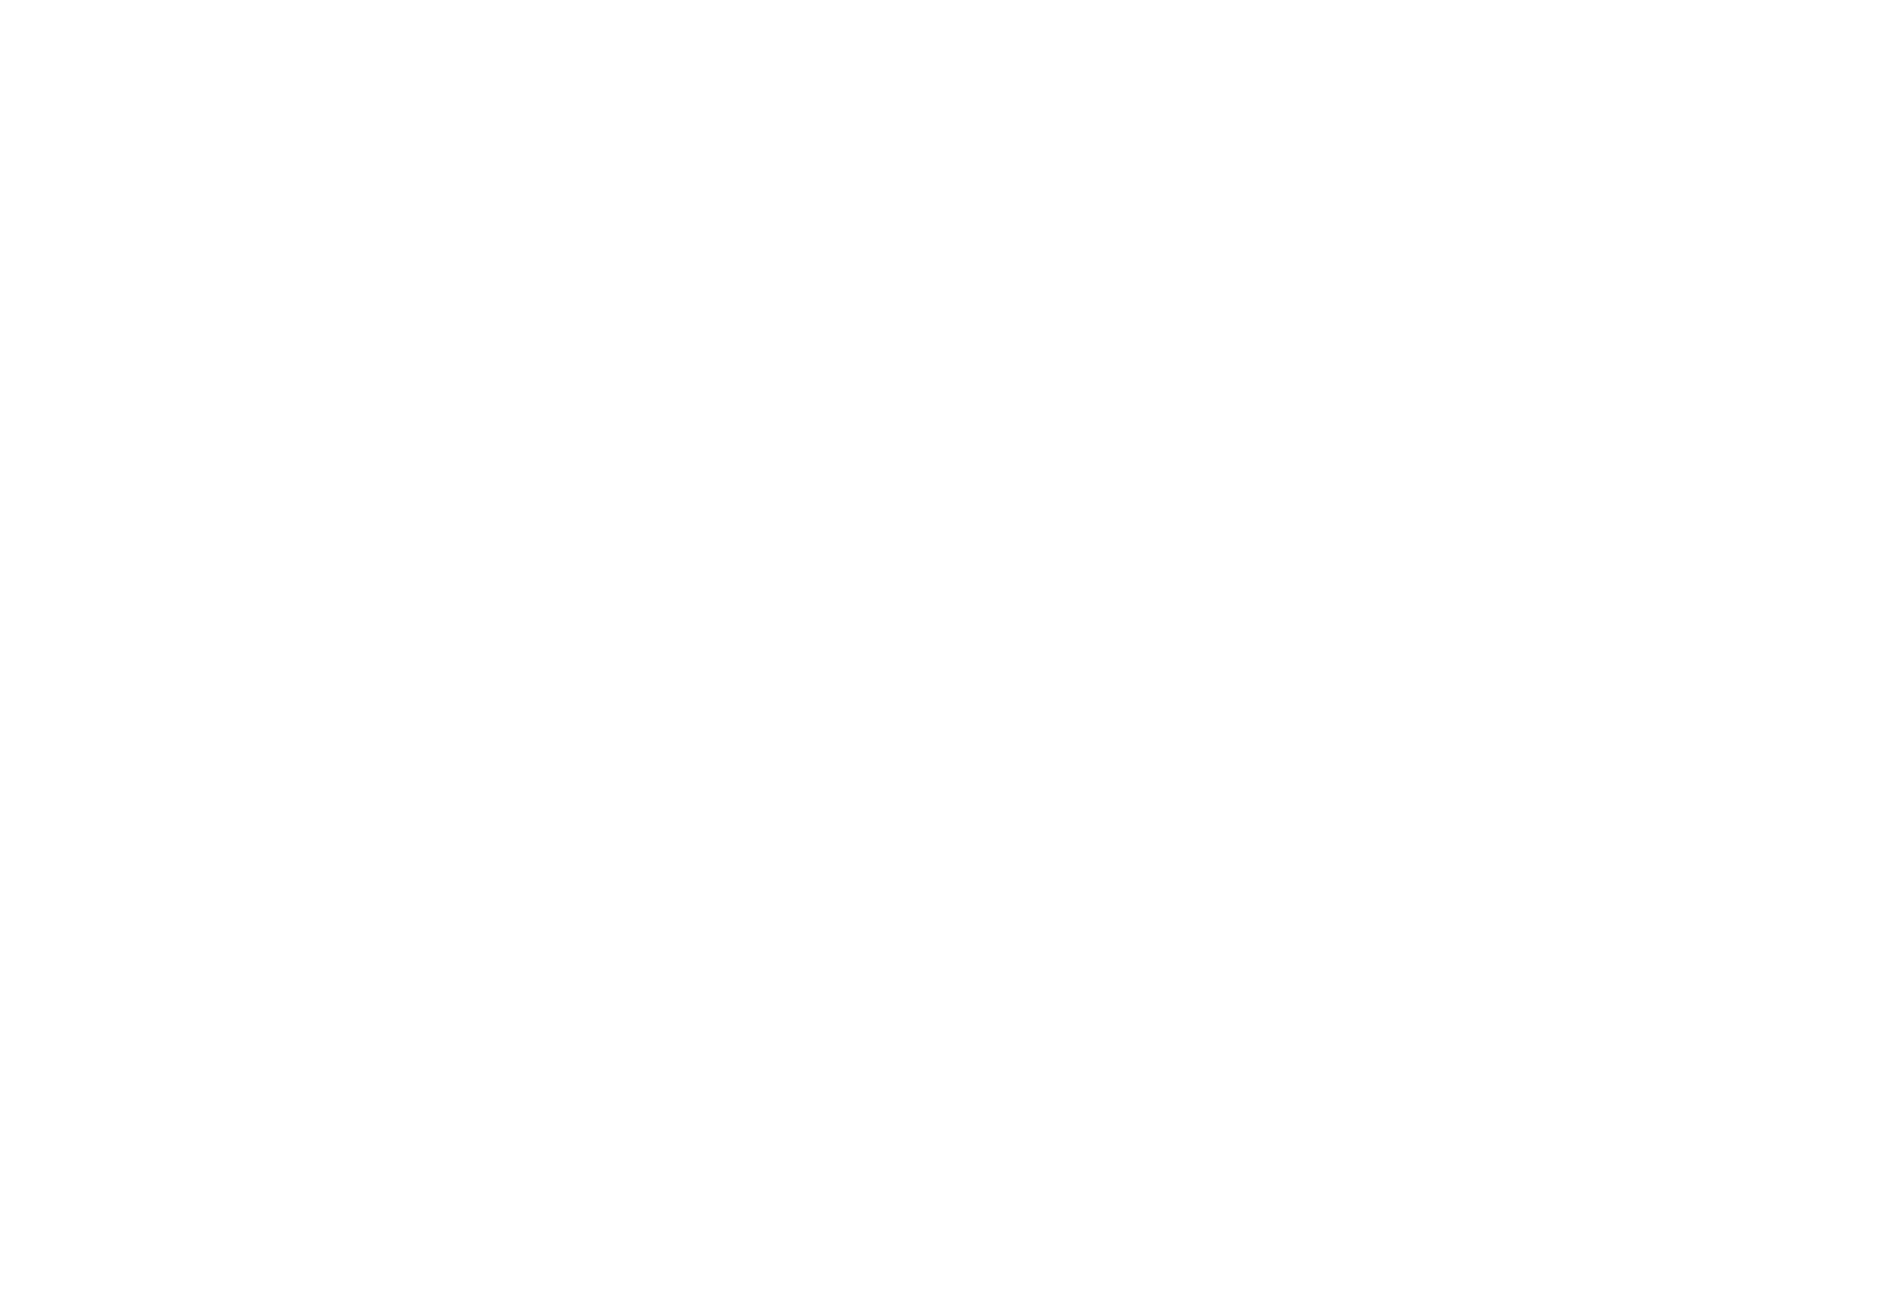

In [19]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(9.5,6.5), dpi=100)
ax = plt.axes(projection=crs)
#ax = plt.axes()
ax.set_extent((112.5,123,-10,-3))
ax.coastlines(resolution='10m',color='gray',zorder=0)
plt.xticks(np.arange(112.5,123))
plt.yticks(np.arange(-10,-3))


bulukumba_lat, bulukumba_lon = -5.5675, 120.1915
sumenep_lat, sumenep_lon = -7.049, 113.913
nipanipa_lat, nipanipa_lon = -5.569, 120.005
bima_lat, bima_lon = -8.4502, 118.7169


plt.scatter(walane_finite_llh['longitude'],walane_finite_llh['latitude'],s=2,c='green',label='Walane samples',alpha=0.01)
plt.scatter(flores_finite_llh['longitude'],flores_finite_llh['latitude'],s=2,c='purple',label='Flores samples',alpha=0.01)

plt.scatter([bulukumba_lon, sumenep_lon, nipanipa_lon, bima_lon],
            [bulukumba_lat, sumenep_lat, nipanipa_lat, bima_lat],
           s=32, c='red', edgecolors='black', label='Observation Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#change so that Flores fault line is green, and Walane is blue
plt.scatter(np.append(flores_lons, walane_lons), np.append(flores_lats, walane_lats),
            s=1, c='b', label='Fault Lines')

plt.legend()

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/172563873.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  clb1 = plt.colorbar(fraction=0.046, pad=0.07)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/172563873.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  clb2 = plt.colorbar(fraction=0.046, pad=0.07)


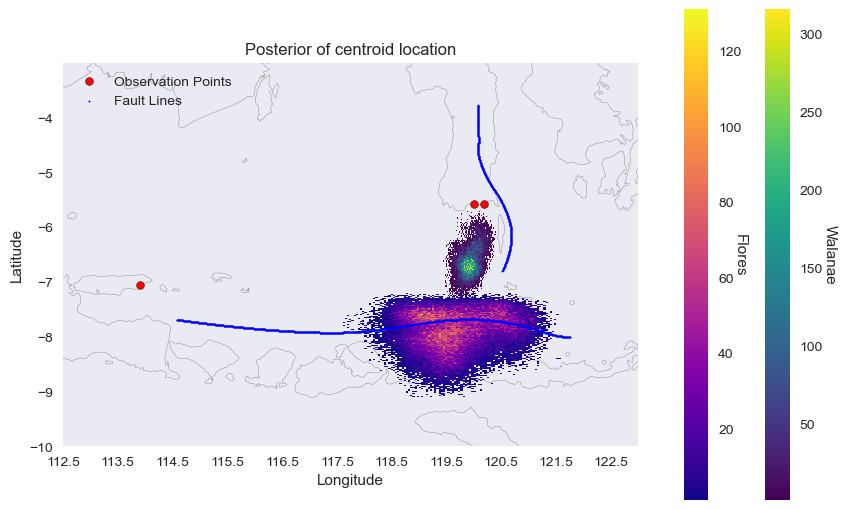

In [20]:
%matplotlib inline
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(9.5,6.5), dpi=100)
ax1 = plt.axes(projection=crs)

ax1.set_extent([112.5,123,-10,-3])
ax1.coastlines(resolution='10m',color='gray',zorder=0)

plt.xticks(np.arange(112.5,123))
plt.yticks(np.arange(-10,-3))

plt.scatter([bulukumba_lon, sumenep_lon, nipanipa_lon, bima_lon],
            [bulukumba_lat, sumenep_lat, nipanipa_lat, bima_lat],
           s=32, c='red', edgecolors='black', label='Observation Points')

plt.hist2d(walane_finite_llh['longitude'],walane_finite_llh['latitude'],cmap='viridis',bins=70,cmin=1)
clb1 = plt.colorbar(fraction=0.046, pad=0.07)
clb1.set_label('Walanae',rotation=270,labelpad=10)
plt.hist2d(flores_finite_llh['longitude'],flores_finite_llh['latitude'],cmap='plasma',bins=100,cmin=1)
clb2 = plt.colorbar(fraction=0.046, pad=0.07)
clb2.set_label('Flores',rotation=270)
ax1.set_extent([112.5,123,-10,-3])

plt.scatter(np.append(flores_lons, walane_lons), np.append(flores_lats, walane_lats),
            s=1, c='b', label='Fault Lines')


#xlims = ax.get_xlim()
#ylims = ax.get_ylim()

plt.legend()
plt.title('Posterior of centroid location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.show()
plt.savefig('posterior_lat_lon.pdf')

#JPW: plot the prior for both faults as well


In [21]:
# Bulukumba
bulukumba_dists = dict()
bulukumba_dists['height'] = stats.norm(loc=18,scale=5) # record says 60-80 feet;
bulukumba_dists['arrival'] = stats.norm(loc=15,scale=10)

# Sumenep
sumenep_dists = dict()
sumenep_dists['height'] = stats.truncnorm(loc=1.5,scale=1,a=-1,b=4)
sumenep_dists['arrival'] = stats.norm(loc=240,scale=45)

# Nipa-Nipa
nipa_dists = dict()
nipa_dists['height'] = stats.truncnorm(loc=3,scale=2,a=-1,b=4)

# Bima
bima_dists = dict()
bima_dists['height'] = stats.truncnorm(loc=10,scale=4,a=-2.25,b=4)

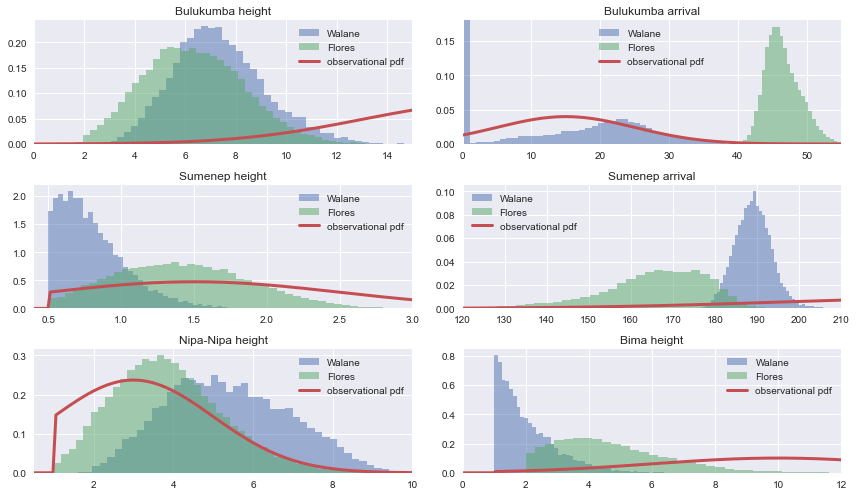

In [22]:
fig = plt.figure(figsize=(12,7))
plt.subplot(3,2,1)
plt.hist(walane_model_output['Bulukumba height'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_output['Bulukumba height'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(0,18,200)
plt.plot(x,bulukumba_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,15])
plt.legend()
plt.title('Bulukumba height')

plt.subplot(3,2,2)
plt.hist(walane_model_output['Bulukumba arrival'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_output['Bulukumba arrival'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(0,55,200)
plt.plot(x,bulukumba_dists['arrival'].pdf(x),label='observational pdf',linewidth=3)
plt.ylim([0,0.18])
plt.xlim([0,55])
plt.legend()
plt.title('Bulukumba arrival')

plt.subplot(3,2,3)
plt.hist(walane_model_output['Sumenep height'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_output['Sumenep height'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(0,3,200)
plt.plot(x,sumenep_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0.4,3])
plt.legend()
plt.title('Sumenep height')

plt.subplot(3,2,4)
plt.hist(walane_model_output['Sumenep arrival'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_output['Sumenep arrival'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(0,220,200)
plt.plot(x,sumenep_dists['arrival'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([120,210])
plt.legend()
plt.title('Sumenep arrival')

plt.subplot(3,2,5)
plt.hist(walane_model_output['Nipa-Nipa height'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_output['Nipa-Nipa height'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(0,15,200)
plt.plot(x,nipa_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0.5,10])
plt.legend()
plt.title('Nipa-Nipa height')

plt.subplot(3,2,6)
plt.hist(walane_model_output['Bima height'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_output['Bima height'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(0,15,200)
plt.plot(x,bima_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,12])
plt.legend()
plt.title('Bima height')


plt.tight_layout()
plt.savefig('Observations.pdf')

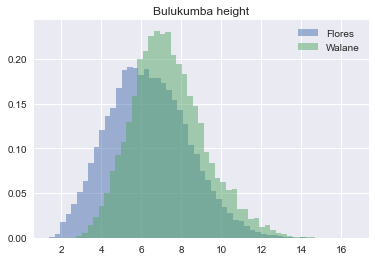

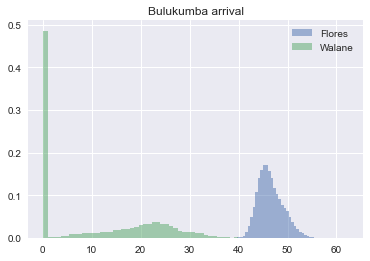

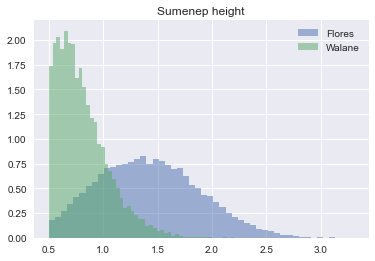

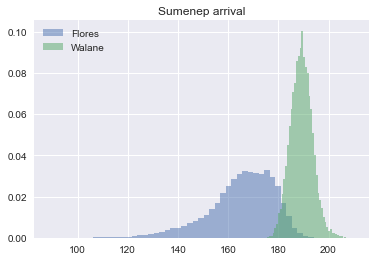

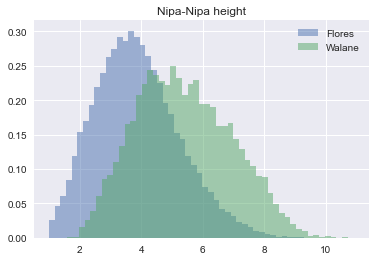

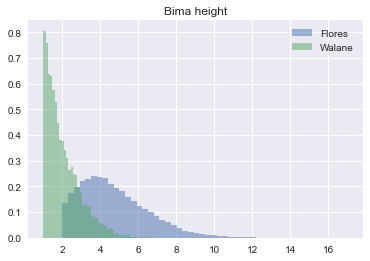

In [23]:
for name in flores_model_output:

    plt.hist(flores_model_output[name],density=True,bins=50,alpha=0.5,label='Flores')
    plt.hist(walane_model_output[name],density=True,bins=50,alpha=0.5,label='Walane')
    plt.title(name)
    plt.legend()
    plt.show()
#JPW: plot the likelihoods as well
#cutoff for Bulukumba arrival 0.1670803667 + 1e-4 i.e. the following will plot magnitudes for events that register as 0 arrival time in Bulukumba
#walane_model_output.loc[walane_model_output['Bulukumba arrival'] < (0.1670803667 + 1e-4)]['magnitude'].hist(bins=50)

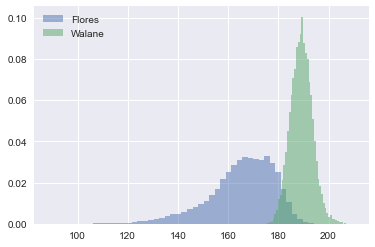

In [24]:
plt.hist(flores_model_output['Sumenep arrival'],density=True,bins=50,alpha=0.5,label='Flores')
plt.hist(walane_model_output['Sumenep arrival'],density=True,bins=50,alpha=0.5,label='Walane')
plt.legend()
plt.show()

In [25]:
#Prior Distributions:

#magnitude
magnitude_dist = stats.truncexpon(loc=6.5,b=5,scale=0.5)
delta_logl_dist = stats.norm(scale=0.188)
delta_logw_dist = stats.norm(scale=0.172)
depth_offset_dist = stats.norm(scale=5)
dip_offset_flo_dist = stats.norm(scale=30)
dip_offset_wal_dist = stats.norm(scale=3.5)
rake_offset_flo_dist = stats.norm(scale=45)
rake_offset_wal_dist = stats.norm(scale=5.5)
strike_offset_dist = stats.norm(scale=5)
depth_offset_flo_dist = stats.norm(scale=np.sqrt(5))

In [26]:
walane_bayes_data

prior_logpdf        llh  posterior_logpdf
0         -24.367520 -21.258917        -45.626437
1         -24.367520 -21.258917        -45.626437
2         -24.367520 -21.258917        -45.626437
3         -24.367520 -21.258917        -45.626437
4         -24.722775 -21.158658        -45.881433
...              ...        ...               ...
232655    -24.556209 -21.938227        -46.494436
232656    -24.556209 -21.938227        -46.494436
232657    -24.556209 -21.938227        -46.494436
232658    -24.556209 -21.938227        -46.494436
232659    -24.556209 -21.938227        -46.494436

[104970 rows x 3 columns]

In [27]:
walane_mle_ind = np.argmax(walane_bayes_data['llh'])
walane_map_ind = np.argmax(walane_bayes_data['posterior_logpdf'])
flores_mle_ind = np.argmax(flores_bayes_data['llh'])
flores_map_ind = np.argmax(flores_bayes_data['posterior_logpdf'])

In [28]:
flores_samples.iloc[flores_mle_ind]

latitude          -7.333254
longitude        120.420887
magnitude          8.839220
delta_logl        -0.104485
delta_logw        -0.562971
depth_offset       1.645342
dip_offset        -1.869891
strike_offset     -3.168686
rake_offset       -3.951631
fault_idx          0.000000
Name: 27859, dtype: float64

In [29]:
#Now we want to define the Gaussian process prior for Flores...

from scipy.linalg import solve_triangular

class GPR:
    """Gaussian Process regressors can be instantiated and sampled from
    using this class. The code is based on Algorithm 2.1 from Rasmussen 
    and Williams' Gaussian process regression book.
    """
    def __init__(self, kernel=None, noise_level=0.00005):
        """Must provide the kernel function and a noise_level. The kernel
        function should take two inputs and return a covariance matrix 
        between those inputs. The noise_level describes how noisy we think 
        the input data is. A noise level of 0 will cause the GP to exactly 
        interpolate the data points, unless you account for the noise in
        your kernel function.
        """
        # Use the default kernel if not provided.
        if kernel is None: kernel = self.rbf_kernel   

        self.kernel = kernel
        self.noise_level = noise_level
    
    
    @staticmethod
    def rbf_kernel(x1,x2,sig=1.0):
        """The RBF kernel (squared exponential distance)."""
        sqdist = np.linalg.norm(x1[:,np.newaxis] - x2, axis=-1)**2
        return np.exp( -sqdist / (2*sig**2))

    
    def fit(self, X, y):
        """Trains the Gaussian process by finding the internal parameters K, 
        L.
        """
        # Take the output mean so we can normalize our GP's output.
        self.mu_hat = y.mean()
        
        self.X = X
        self.y = y - self.mu_hat # Now the y's have sample mean 0.
        K = self.kernel(X, X)
        self.L = np.linalg.cholesky(K + self.noise_level*np.eye(len(X)))
        temp = solve_triangular(self.L, self.y, lower=True)
        self.alpha = solve_triangular(self.L.T, temp)
        
        
    def predict(self, x_star, return_std=False):
        """Returns the mean of the GP at x_star. Can also return the standard
        deviation at each of those points if desired. Note that the standard
        deviation calculations are the most performance-intensive aspect
        of this function.
        """        
        # Compute the mean at the test points.
        k_star = self.kernel(self.X, x_star)
        mu = k_star.T @ self.alpha
        mu += self.mu_hat # So that the output has the correct sample mean.
        
        # Compute the standard deviation.
        if return_std:
            v = solve_triangular(self.L, k_star, lower=True)
            # We take np.diag in the following line to discard covariances.
            std = np.sqrt(np.diag(self.kernel(x_star, x_star) - v.T @ v))
            return mu, std
        
        return mu
    
    
    def llh(self):
        """Returns the log-likelihood of the trained GPR."""
        llh = -0.5*self.y.T @ self.alpha 
        llh -= np.sum(np.log(np.diag(self.L))) 
        llh -= len(self.L)/2*np.log(2*np.pi)
        return llh
    

# Create the multiclass model
class multid_GPR:
    def __init__(self, gprs):
        """Initialize a list of gprs."""
        self.gprs = gprs
    
    def predict(self, X, return_std=False):
        
        out = []
        for gpr in self.gprs:
            out.append(gpr.predict(X,return_std=False))
        
        return np.array(out)




In [30]:
import sys
from os.path import dirname
sys.path.append(dirname('/Users/jaredwhitehead/Desktop/tsunamibayes'))

import cartopy # Mapping package
import cartopy.crs as ccrs

# TsunamiBayes is a package we've created in my research.
# It utilizes Bayesian methods to predict past Tsunamis based on historical data.
import tsunamibayes as tb
from tsunamibayes.tsunamibayes.fault import ReferenceCurveFault, BaseFault
from tsunamibayes.tsunamibayes.multifault import MultiFault
from tsunamibayes.tsunamibayes.utils import bearing, haversine

In [31]:
from sensitivity_data_loader import load_data

lats, lons, depths, dips, strikes, rakes = load_data()

In [32]:
np.savez('flores_data', lats=lats, lons=lons, depths=depths, dips=dips, strikes=strikes, rakes=rakes)

In [33]:
# Get data for plotting
plotting_lats = np.linspace(-9, -8, 100)
plotting_lons = np.linspace(115, 127, 100)
Xplot, Yplot = np.meshgrid(plotting_lons,plotting_lats)

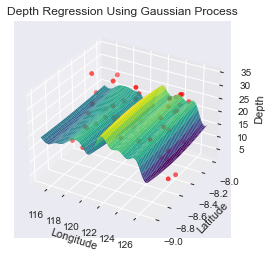

In [34]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = depths.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
depth_gpr = GPR(kernel=ker, noise_level=1.)

# Fit to data using Maximum Likelihood Estimation of the parameters
depth_gpr.fit(X, y)
Zplot,sigma = depth_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 #Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude'),
ax.set_zlabel('Depth')
plt.title('Depth Regression Using Gaussian Process')
plt.show()

In [35]:
np.vstack([Yplot.flatten(), Xplot.flatten()]).T

array([[ -9.        , 115.        ],
       [ -9.        , 115.12121212],
       [ -9.        , 115.24242424],
       ...,
       [ -8.        , 126.75757576],
       [ -8.        , 126.87878788],
       [ -8.        , 127.        ]])

In [36]:
flores_lats = flores_samples['latitude'].to_numpy()
flores_lons = flores_samples['longitude'].to_numpy()
len(flores_lons)

127690

In [37]:
#get all of these, then the prior on d_depth is actually delta_depth/d_depth (I think)
depths, d_depths = depth_gpr.predict(np.vstack([flores_lats[:20000], flores_lons[:20000]]).T, return_std=True)
depths, d_extra = depth_gpr.predict(np.vstack([flores_lats[20000:40000], flores_lons[20000:40000]]).T, return_std=True)
d_depths = np.concatenate((d_depths,d_extra))
depths, d_extra = depth_gpr.predict(np.vstack([flores_lats[40000:60000], flores_lons[40000:60000]]).T, return_std=True)
d_depths = np.concatenate((d_depths,d_extra))
depths, d_extra = depth_gpr.predict(np.vstack([flores_lats[60000:80000], flores_lons[60000:80000]]).T, return_std=True)
d_depths = np.concatenate((d_depths,d_extra))
depths, d_extra = depth_gpr.predict(np.vstack([flores_lats[80000:100000], flores_lons[80000:100000]]).T, return_std=True)
d_depths = np.concatenate((d_depths,d_extra))
depths, d_extra = depth_gpr.predict(np.vstack([flores_lats[100000:], flores_lons[100000:]]).T, return_std=True)
d_depths = np.concatenate((d_depths,d_extra))
print(d_depths)

[0.52716874 0.5645198  0.5645198  ... 0.68511999 0.68511999 0.66683079]


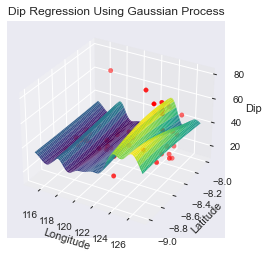

In [38]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = dips.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
dip_gpr = GPR(kernel=ker, noise_level=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
dip_gpr.fit(X, y)
Zplot = dip_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=False)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Dip')
plt.title('Dip Regression Using Gaussian Process')
plt.show()

In [39]:
#get all of these, then the prior on d_depth is actually delta_depth/d_depth (I think)
dips, d_dips = dip_gpr.predict(np.vstack([flores_lats[:20000], flores_lons[:20000]]).T, return_std=True)
dips, d_extra = dip_gpr.predict(np.vstack([flores_lats[20000:40000], flores_lons[20000:40000]]).T, return_std=True)
d_dips = np.concatenate((d_dips,d_extra))
dips, d_extra = dip_gpr.predict(np.vstack([flores_lats[40000:60000], flores_lons[40000:60000]]).T, return_std=True)
d_dips = np.concatenate((d_dips,d_extra))
dips, d_extra = dip_gpr.predict(np.vstack([flores_lats[60000:80000], flores_lons[60000:80000]]).T, return_std=True)
d_dips = np.concatenate((d_dips,d_extra))
dips, d_extra = dip_gpr.predict(np.vstack([flores_lats[80000:100000], flores_lons[80000:100000]]).T, return_std=True)
d_dips = np.concatenate((d_dips,d_extra))
dips, d_extra = dip_gpr.predict(np.vstack([flores_lats[100000:], flores_lons[100000:]]).T, return_std=True)
d_dips = np.concatenate((d_dips,d_extra))
print(d_dips)

[0.52716874 0.5645198  0.5645198  ... 0.68511999 0.68511999 0.66683079]


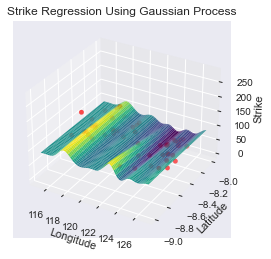

In [40]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = strikes.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
strike_gpr = GPR(kernel=ker, noise_level=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
strike_gpr.fit(X, y)
Zplot = strike_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=False)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Strike')
plt.title('Strike Regression Using Gaussian Process')
plt.show()

In [41]:
#get all of these, then the prior on d_depth is actually delta_depth/d_depth (I think)
strikes, d_strikes = strike_gpr.predict(np.vstack([flores_lats[:20000], flores_lons[:20000]]).T, return_std=True)
strikes, d_extra = strike_gpr.predict(np.vstack([flores_lats[20000:40000], flores_lons[20000:40000]]).T, return_std=True)
d_strikes = np.concatenate((d_strikes,d_extra))
strikes, d_extra = strike_gpr.predict(np.vstack([flores_lats[40000:60000], flores_lons[40000:60000]]).T, return_std=True)
d_strikes = np.concatenate((d_strikes,d_extra))
strikes, d_extra = strike_gpr.predict(np.vstack([flores_lats[60000:80000], flores_lons[60000:80000]]).T, return_std=True)
d_strikes = np.concatenate((d_strikes,d_extra))
strikes, d_extra = strike_gpr.predict(np.vstack([flores_lats[80000:100000], flores_lons[80000:100000]]).T, return_std=True)
d_strikes = np.concatenate((d_strikes,d_extra))
strikes, d_extra = strike_gpr.predict(np.vstack([flores_lats[100000:], flores_lons[100000:]]).T, return_std=True)
d_strikes = np.concatenate((d_strikes,d_extra))
print(d_strikes)

[0.52716874 0.5645198  0.5645198  ... 0.68511999 0.68511999 0.66683079]


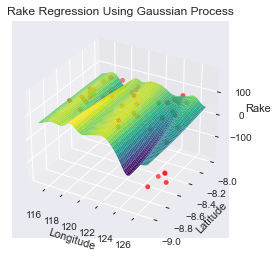

In [42]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = rakes.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
rake_gpr = GPR(kernel=ker, noise_level=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
rake_gpr.fit(X, y)
Zplot = rake_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=False)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Rake')
plt.title('Rake Regression Using Gaussian Process')
plt.show()

In [43]:
#get all of these, then the prior on d_depth is actually delta_depth/d_depth (I think)
rakes, d_rakes = rake_gpr.predict(np.vstack([flores_lats[:20000], flores_lons[:20000]]).T, return_std=True)
rakes, d_extra = rake_gpr.predict(np.vstack([flores_lats[20000:40000], flores_lons[20000:40000]]).T, return_std=True)
d_rakes = np.concatenate((d_rakes,d_extra))
rakes, d_extra = rake_gpr.predict(np.vstack([flores_lats[40000:60000], flores_lons[40000:60000]]).T, return_std=True)
d_rakes = np.concatenate((d_rakes,d_extra))
rakes, d_extra = rake_gpr.predict(np.vstack([flores_lats[60000:80000], flores_lons[60000:80000]]).T, return_std=True)
d_rakes = np.concatenate((d_rakes,d_extra))
rakes, d_extra = rake_gpr.predict(np.vstack([flores_lats[80000:100000], flores_lons[80000:100000]]).T, return_std=True)
d_rakes = np.concatenate((d_rakes,d_extra))
rakes, d_extra = rake_gpr.predict(np.vstack([flores_lats[100000:], flores_lons[100000:]]).T, return_std=True)
d_rakes = np.concatenate((d_rakes,d_extra))
print(d_rakes)

[0.52716874 0.5645198  0.5645198  ... 0.68511999 0.68511999 0.66683079]


Text(0.5, 1.0, 'depth offset')

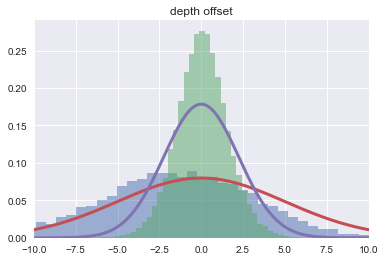

In [44]:
plt.hist(walane_samples['depth_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['depth_offset']/(d_depths**2),bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-10,10,200)
plt.plot(x,depth_offset_dist.pdf(x),label='Walanae prior pdf',linewidth=3)
plt.plot(x,depth_offset_flo_dist.pdf(x),label='Flores prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['depth_offset'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['depth_offset'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['depth_offset'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['depth_offset'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-10,10])
#plt.legend()
plt.title('depth offset')

In [45]:
#depth_gpr.predict([118,-8],return_std=True)
np.vstack([flores_lons[:10000], flores_lats[:10000]]).T

array([[118.53847042,  -7.98885312],
       [118.49876916,  -7.93354183],
       [118.49876916,  -7.93354183],
       ...,
       [119.56025424,  -8.39060732],
       [119.43362605,  -8.37595276],
       [119.43362605,  -8.37595276]])

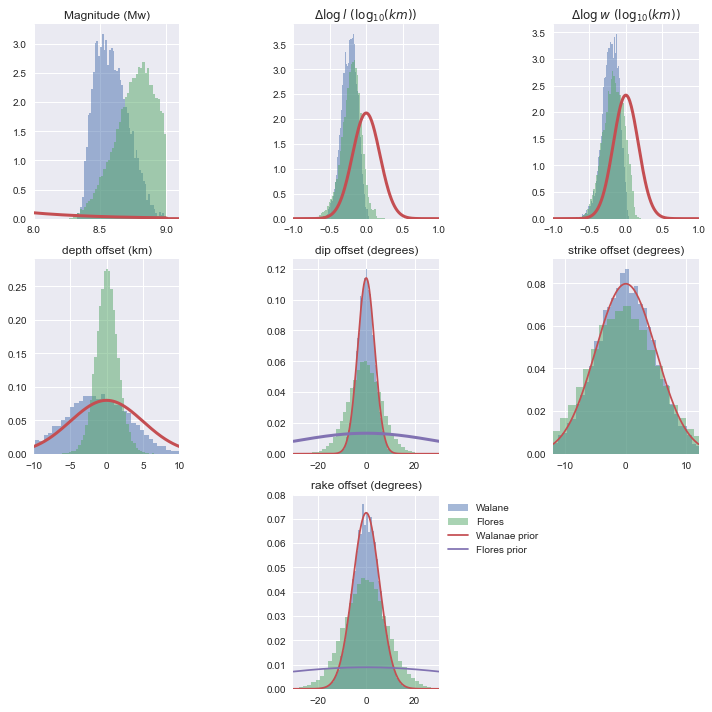

In [46]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.hist(walane_samples['magnitude'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['magnitude'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(6,10,200)
plt.plot(x,magnitude_dist.pdf(x),label='prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['magnitude'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['magnitude'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['magnitude'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['magnitude'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([8,9.1])
#plt.legend()
plt.title('Magnitude (Mw)')

plt.subplot(3,3,2)
plt.hist(walane_samples['delta_logl'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['delta_logl'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-1,1,200)
plt.plot(x,delta_logl_dist.pdf(x),label='prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['delta_logl'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['delta_logl'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['delta_logl'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['delta_logl'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-1,1])
#plt.legend()
plt.title('$\Delta \log l~(\log_{10} (km))$')

plt.subplot(3,3,3)
plt.hist(walane_samples['delta_logw'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['delta_logw'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-1,1,200)
plt.plot(x,delta_logw_dist.pdf(x),label='prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['delta_logw'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['delta_logw'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['delta_logw'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['delta_logw'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-1,1])
#plt.legend()
plt.title('$\Delta \log w~(\log_{10}(km))$')

plt.subplot(3,3,4)
plt.hist(walane_samples['depth_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['depth_offset']/d_depths**2,bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-10,10,200)
plt.plot(x,depth_offset_dist.pdf(x),label='Walanae prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['depth_offset'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['depth_offset'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['depth_offset'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['depth_offset'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-10,10])
#plt.legend()
plt.title('depth offset (km)')

plt.subplot(3,3,5)
plt.hist(walane_samples['dip_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['dip_offset']/d_dips**2,bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-30,30,400)
plt.plot(x,dip_offset_wal_dist.pdf(x),label='Walanae prior pdf')
plt.plot(x,dip_offset_flo_dist.pdf(x),label='Flores prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['dip_offset'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['dip_offset'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['dip_offset'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['dip_offset'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-30,30])
#plt.legend()
plt.title('dip offset (degrees)')

plt.subplot(3,3,6)
plt.hist(walane_samples['strike_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['strike_offset']/d_strikes**2,bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-12,12,200)
plt.plot(x,strike_offset_dist.pdf(x),label='Walanae prior pdf')
#plt.plot(x,strike_offset_flo_dist.pdf(x),label='Flores prior pdf')
#plt.plot(x,strike_offset_dist.pdf(x),label='prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['strike_offset'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['strike_offset'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['strike_offset'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['strike_offset'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-12,12])
#plt.legend()
plt.title('strike offset (degrees)')

plt.subplot(3,3,8)
plt.hist(walane_samples['rake_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['rake_offset']/d_rakes**2,bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(-30,30,400)
plt.plot(x,rake_offset_wal_dist.pdf(x),label='Walanae prior')
plt.plot(x,rake_offset_flo_dist.pdf(x),label='Flores prior')
#plt.plot(x,rake_offset_wal_dist.pdf(x),label='prior pdf',linewidth=3)
#plt.axvline(x=walane_samples.iloc[walane_mle_ind]['rake_offset'],ymin=0, ymax=.5,color='b',label='Walane MLE')
#plt.axvline(x=flores_samples.iloc[flores_mle_ind]['rake_offset'],ymin=0, ymax=.5,color='g',label='Flores MLE')
#plt.axvline(x=walane_samples.iloc[walane_map_ind]['rake_offset'],ymin=0, ymax=.5,color='aqua',label='Walane MAP')
#plt.axvline(x=flores_samples.iloc[flores_map_ind]['rake_offset'],ymin=0, ymax=.5,color='lime',label='Flores MAP')
plt.xlim([-30,30])
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.title('rake offset (degrees)')
plt.tight_layout()
plt.savefig('Posterior.pdf')

In [47]:
walane_samples

latitude   longitude  magnitude  delta_logl  delta_logw  depth_offset  \
0      -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
1      -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
2      -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
3      -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
4      -6.793402  119.932249   8.650492   -0.290380   -0.280740     -4.052337   
...          ...         ...        ...         ...         ...           ...   
232655 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
232656 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
232657 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
232658 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
232659 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   

        dip_offset  strike_offset  rake_offset  fault_idx  
0         1.480481       0.568101    -0.835560        1.0  
1         1.480481       0.568101    -0.835560        1.0  
2         1.480481       0.568101    -0.835560        1.0  
3         1.480481       0.568101    -0.835560        1.0  
4         2.237186       3.162006     3.066257        1.0  
...            ...            ...          ...        ...  
232655    7.285851       1.395180    -0.442551        1.0  
232656    7.285851       1.395180    -0.442551        1.0  
232657    7.285851       1.395180    -0.442551        1.0  
232658    7.285851       1.395180    -0.442551        1.0  
232659    7.285851       1.395180    -0.442551        1.0  

[104970 rows x 10 columns]

In [49]:
import pickle
with open('walanae_fault_data.pkl', 'rb') as file:
    walanae_initialization_data = pickle.load(file)
flores_initialization_data = np.load('flores_data.npz')

AttributeError: Can't get attribute 'walanae_depth' on <module '__main__'>

In [50]:
from pandas_profiling import ProfileReport
date = '8/5/2022'

In [51]:
#flores_profile = ProfileReport( flores_finite_llh, title=f"Flores Report ({date})", minimal=True)
#flores_profile.to_file(f"sulawesi_1820/reports/flores_report.html")

walane_profile = ProfileReport( walane_finite_llh, title=f"walane Report ({date})", minimal=True)
walane_profile.to_file(f"sulawesi_1820/reports/walane_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
for key, val in chains_samples.items():
    print(key, len(val) if val is not None else 0)

47944325_m9 8363
47944321_m9 8713
46390858_m8 12724
47944320_m9 11093
46390859_m8 12824
47944324_m9 10663
46390856_m8 12264
46390862_m9 13254
46390863_m9 12744
46390857_m8 12154
47944329_m9 11023
46390860_m8 12864
47944319_m9 11733
46390864_m9 13134
47944318_m9 11413
46390865_m9 12704
46390861_m9 13034
47944328_m9 11203
47944323_m9 9923
47944322_m9 10853


In [53]:
fault_name = lambda fault_idx: 'Flores' if fault_idx == 0 else 'Walane'

In [54]:
chains_samples

{'47944325_m9':       latitude   longitude  magnitude  delta_logl  delta_logw  depth_offset  \
 0    -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
 1    -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
 2    -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
 3    -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
 4    -6.761551  119.951134   8.626235   -0.296848   -0.282176     -4.425621   
 ...        ...         ...        ...         ...         ...           ...   
 8358 -6.860642  119.826156   8.552910   -0.242564   -0.064449     -3.691919   
 8359 -6.860642  119.826156   8.552910   -0.242564   -0.064449     -3.691919   
 8360 -6.694291  119.862659   8.677561   -0.238514   -0.032627     -5.740519   
 8361 -6.694291  119.862659   8.677561   -0.238514   -0.032627     -5.740519   
 8362 -6.694291  119.862659   8.677561   -0.238514   -0.032627     -5.740519   
 
       dip_offset  stri

In [55]:
wal_chains = []
flo_chains = []
for slurm_id,chain in chains_samples.items():
    fault_idx =chain['fault_idx'][0]
    if fault_idx == 1:
        wal_chains.append(chain)
    else:
        flo_chains.append(chain)

In [56]:
np.mean([wal_chains[j].shape[0] for j in range(10)])

10498.0

In [57]:
np.mean([flo_chains[j].shape[0] for j in range(10)])

12770.0

In [58]:
wal_min_length = np.min([wal_chains[j].shape[0] for j in range(10)])

In [59]:
flo_min_length = np.min([flo_chains[j].shape[0] for j in range(10)])

In [60]:
flo_min_length

12154

In [61]:
for i in range(10):
    wal_chains[i] = wal_chains[i].loc[:wal_min_length-1]

In [62]:
for i in range(10):
    flo_chains[i] = flo_chains[i].loc[:flo_min_length-1]

In [63]:
[wal_chains[j].shape[0] for j in range(10)]

[8363, 8363, 8363, 8363, 8363, 8363, 8363, 8363, 8363, 8363]

In [64]:
def mean_chain(dfs, column, return_std=True):
    stack = np.zeros((len(dfs), dfs[0].shape[0]))
    for i, df in enumerate(dfs):
        stack[i] = df[column].to_numpy()
    return stack.mean(axis=0), stack.std(axis=0, ddof=1)

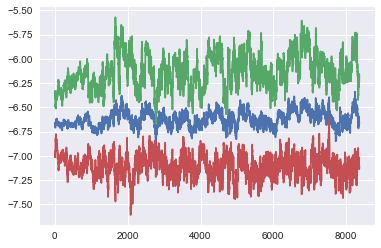

In [65]:
wal_mean, wal_std = mean_chain(wal_chains, 'latitude')
plt.figure()
plt.plot(wal_mean)
plt.plot(wal_mean + 2*wal_std)
plt.plot(wal_mean - 2*wal_std)
plt.show()

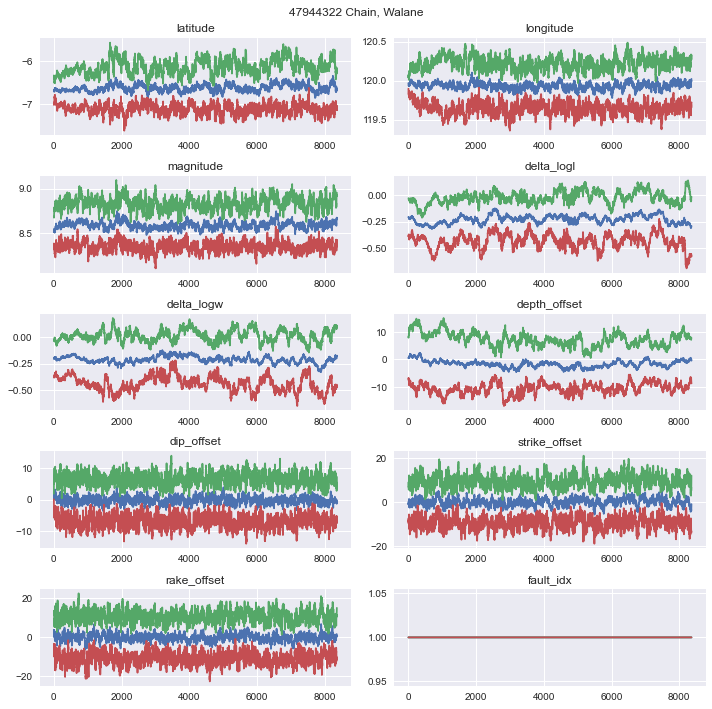

In [66]:
plt.figure(figsize=(10,10))
for j, key in enumerate(chains_samples['47944325_m9'].columns):
    plt.subplot(5,2,j+1)
    wal_mean, wal_std = mean_chain(wal_chains, key)
    plt.plot(wal_mean)
    plt.plot(wal_mean+2*wal_std)
    plt.plot(wal_mean-2*wal_std)
    plt.title(key)
plt.suptitle(f'{slurm_id[:-3]} Chain, {fault_name(fault_idx)}')
plt.tight_layout()

Display All Chains

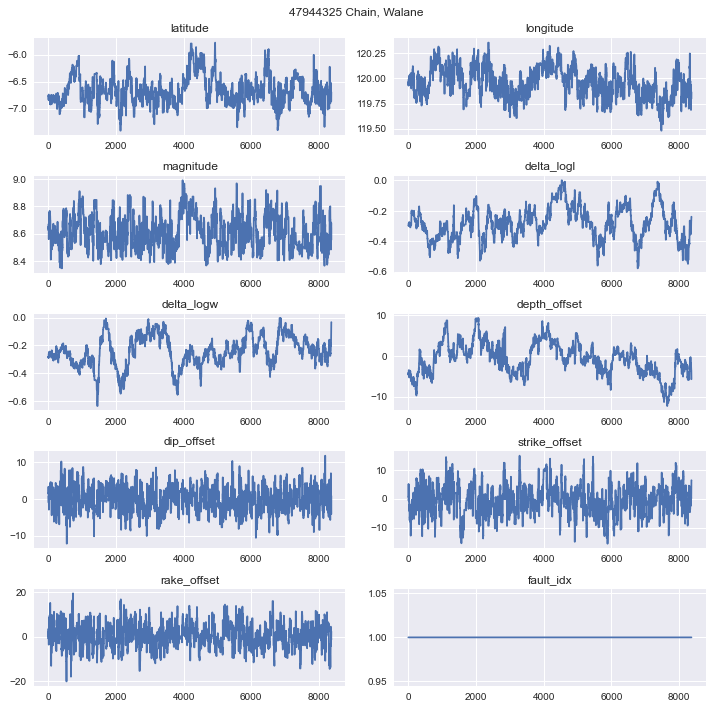

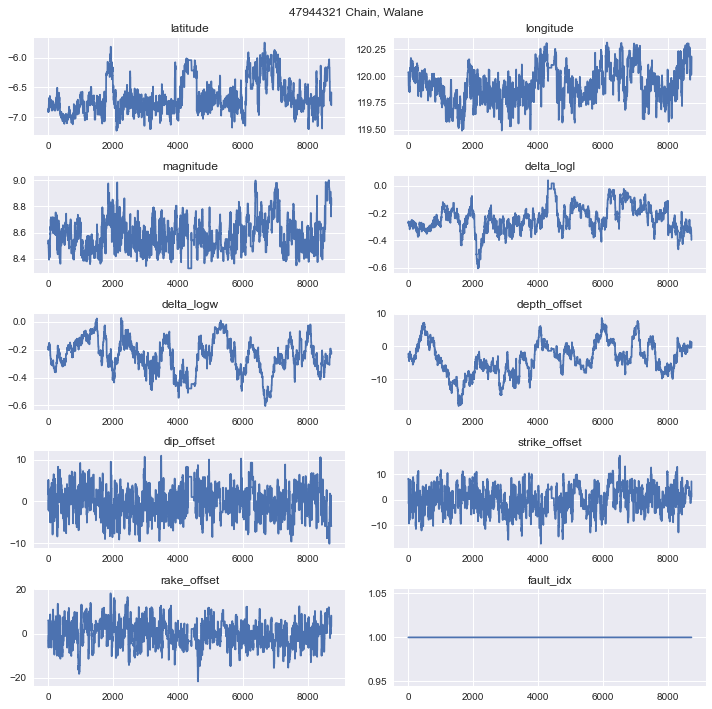

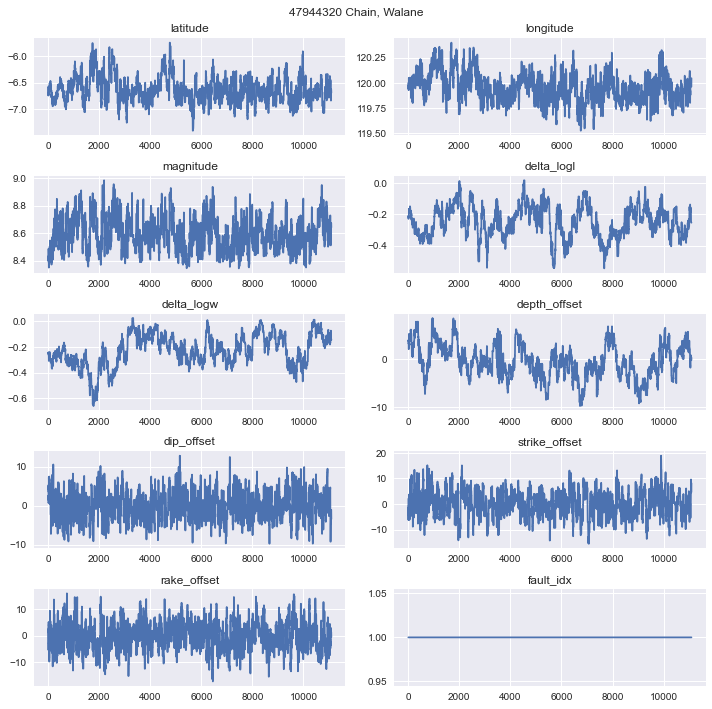

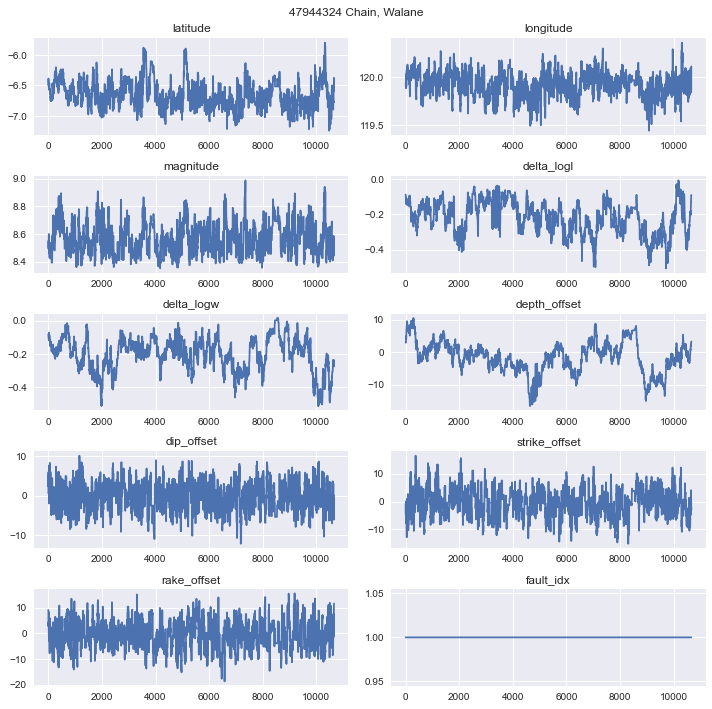

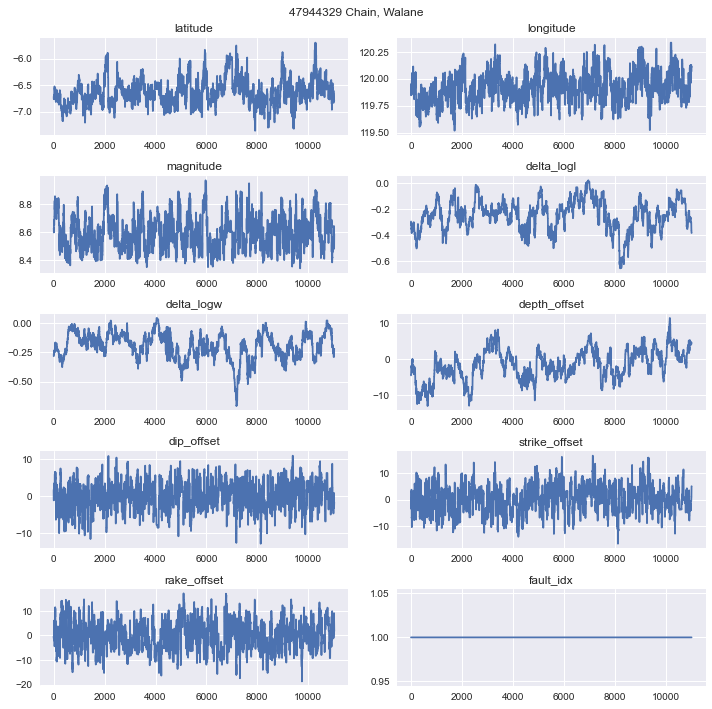

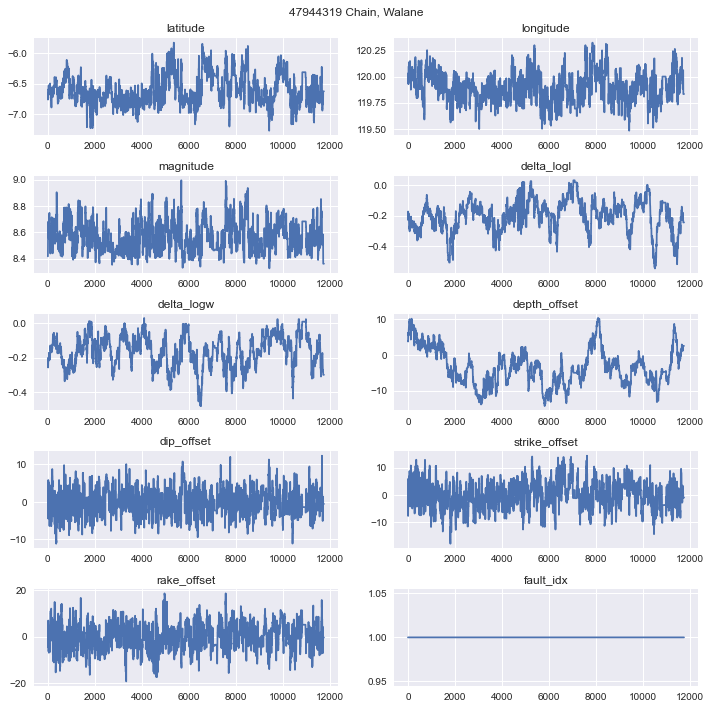

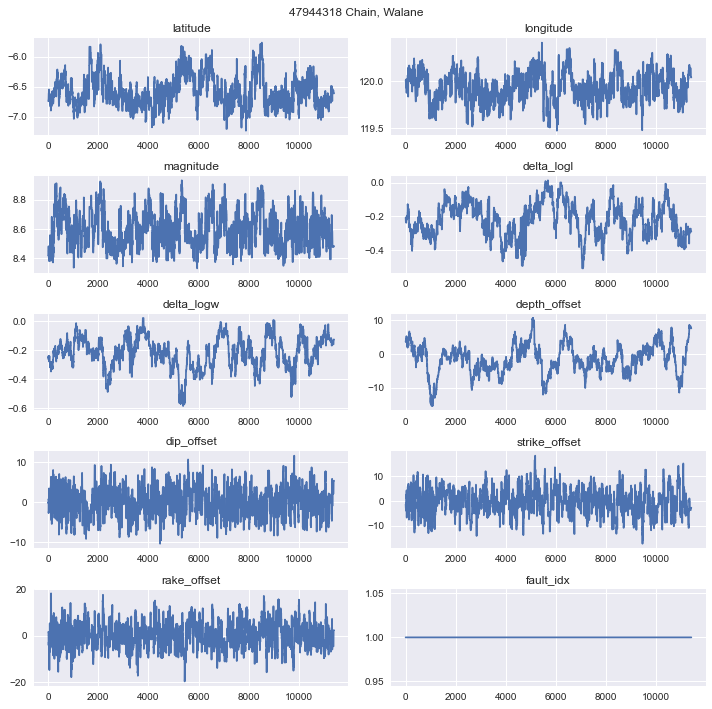

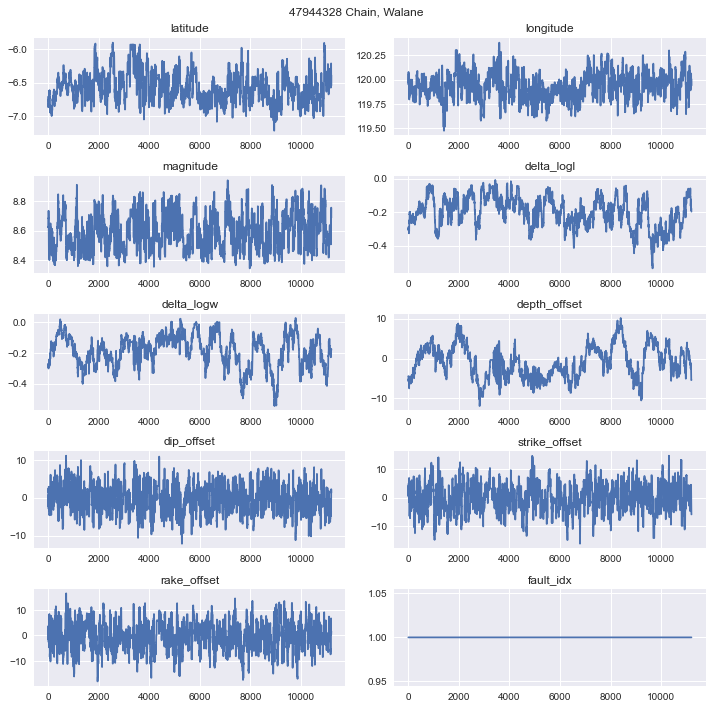

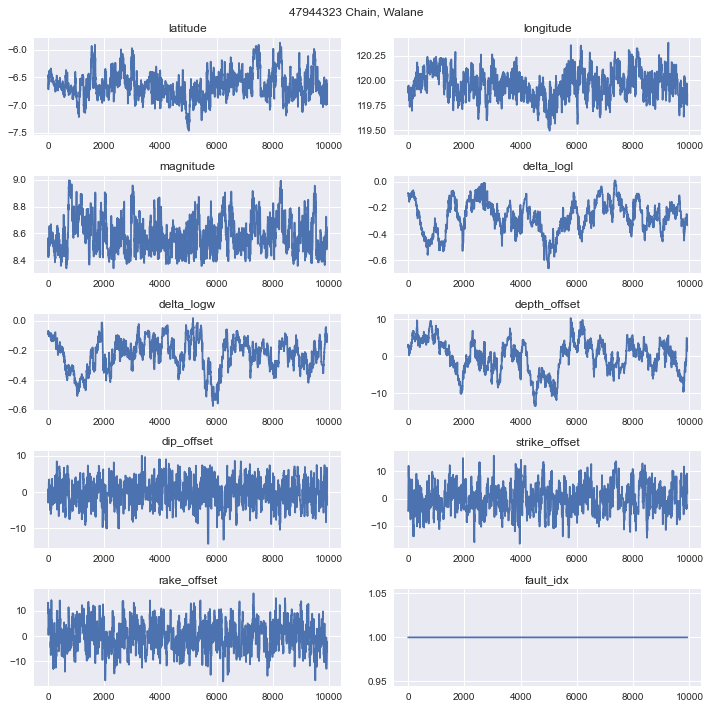

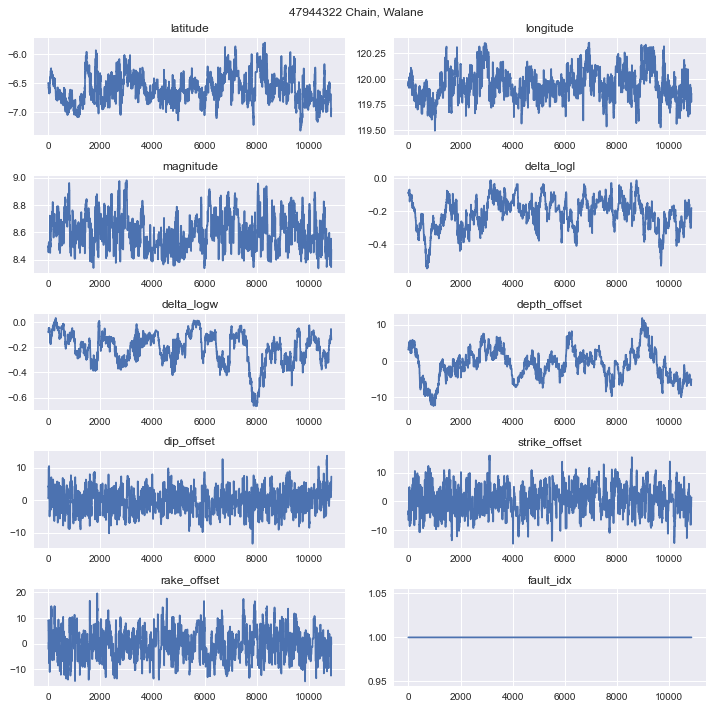

In [67]:
for slurm_id, chain in chains_samples.items():
    fault_idx = chain['fault_idx'][0]
    if fault_idx == 1:
        plt.figure(figsize=(10,10))
        for j, key in enumerate(chain.columns):
            plt.subplot(5,2,j+1)
            plt.plot(chain[key])
            plt.title(key)
        plt.suptitle(f'{slurm_id[:-3]} Chain, {fault_name(fault_idx)}')
        plt.tight_layout()

In [68]:
10

10

Look at inter-chain mixing

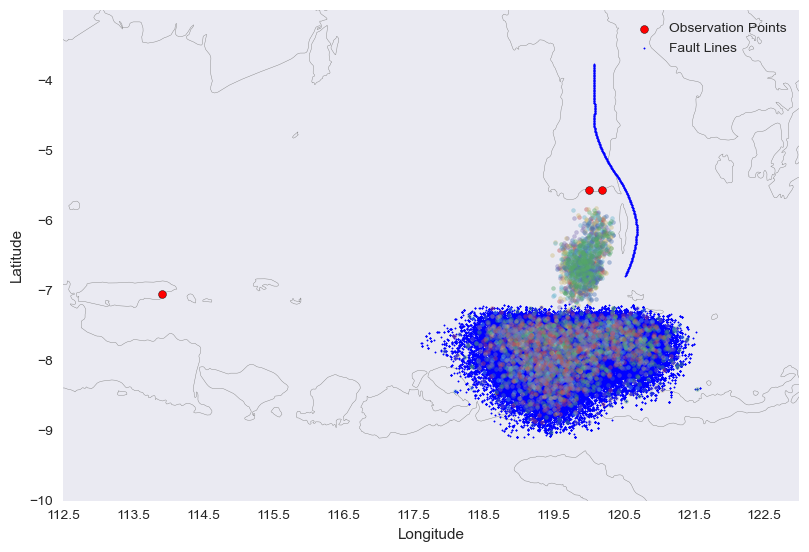

In [69]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(9.5,6.5), dpi=100)
ax = plt.axes(projection=crs)
#ax = plt.axes()
ax.set_extent((112.5,123,-10,-3))
ax.coastlines(resolution='10m',color='gray',zorder=0)
plt.xticks(np.arange(112.5,123))
plt.yticks(np.arange(-10,-3))


bulukumba_lat, bulukumba_lon = -5.5675, 120.1915
sumenep_lat, sumenep_lon = -7.049, 113.913
nipanipa_lat, nipanipa_lon = -5.569, 120.005
bima_lat, bima_lon = -8.4502, 118.7169



plt.scatter([bulukumba_lon, sumenep_lon, nipanipa_lon, bima_lon],
            [bulukumba_lat, sumenep_lat, nipanipa_lat, bima_lat],
           s=32, c='red', edgecolors='black', label='Observation Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.scatter(np.append(flores_lons, walane_lons), np.append(flores_lats, walane_lats),
            s=1, c='b', label='Fault Lines')


for current_fault_idx in [0,1]:
    for slurm_id, chain in chains_debug.items():
        fault_idx = chain['fault_idx'][0]
        if fault_idx == current_fault_idx:
            plt.scatter(chain['longitude'][100::50], chain['latitude'][100::50], s=8, alpha=.4)

plt.legend()
plt.savefig('lat_lon_samples.pdf')

46390858_m8 Flores
46390859_m8 Flores
46390856_m8 Flores
46390862_m9 Flores
46390863_m9 Flores
46390857_m8 Flores
46390860_m8 Flores
46390864_m9 Flores
46390865_m9 Flores
46390861_m9 Flores
47944325_m9 Walane
47944321_m9 Walane
47944320_m9 Walane
47944324_m9 Walane
47944329_m9 Walane
47944319_m9 Walane
47944318_m9 Walane
47944328_m9 Walane
47944323_m9 Walane
47944322_m9 Walane


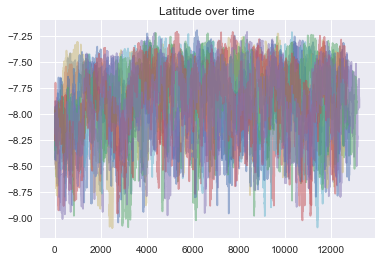

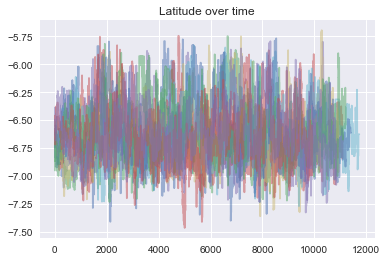

In [70]:
for current_fault_idx in [0,1]:
    plt.figure()
    for slurm_id, chain in chains_debug.items():
        fault_idx = chain['fault_idx'][0]
        if fault_idx == current_fault_idx:
            print(slurm_id, fault_name(fault_idx))
            chain['latitude'].plot(alpha=0.5)
            plt.title('Latitude over time')

46390858_m8 Flores
46390859_m8 Flores
46390856_m8 Flores
46390862_m9 Flores
46390863_m9 Flores
46390857_m8 Flores
46390860_m8 Flores
46390864_m9 Flores
46390865_m9 Flores
46390861_m9 Flores
47944325_m9 Walane
47944321_m9 Walane
47944320_m9 Walane
47944324_m9 Walane
47944329_m9 Walane
47944319_m9 Walane
47944318_m9 Walane
47944328_m9 Walane
47944323_m9 Walane
47944322_m9 Walane


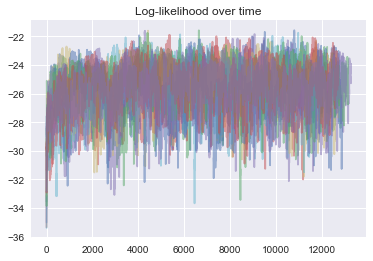

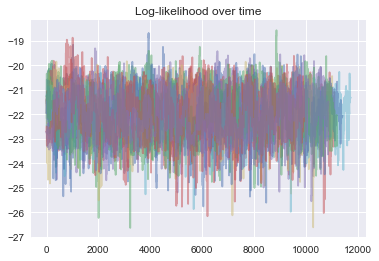

In [71]:
for current_fault_idx in [0,1]:
    plt.figure()
    for slurm_id, chain in chains_debug.items():
        fault_idx = chain['fault_idx'][0]
        if fault_idx == current_fault_idx:
            print(slurm_id, fault_name(fault_idx))
            chain['llh'].plot(alpha=0.5)
            plt.title('Log-likelihood over time')

46390858_m8 Flores
46390859_m8 Flores
46390856_m8 Flores
46390862_m9 Flores
46390863_m9 Flores
46390857_m8 Flores
46390860_m8 Flores
46390864_m9 Flores
46390865_m9 Flores
46390861_m9 Flores
47944325_m9 Walane
47944321_m9 Walane
47944320_m9 Walane
47944324_m9 Walane
47944329_m9 Walane
47944319_m9 Walane
47944318_m9 Walane
47944328_m9 Walane
47944323_m9 Walane
47944322_m9 Walane


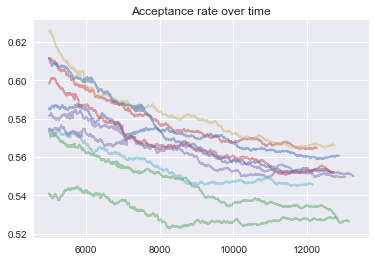

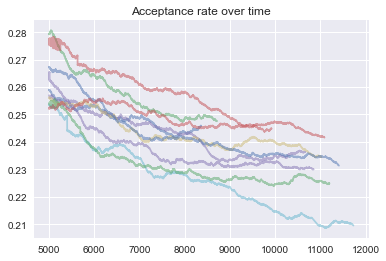

In [72]:
for current_fault_idx in [0,1]:
    plt.figure()
    for slurm_id, chain in chains_debug.items():
        fault_idx = chain['fault_idx'][0]
        if fault_idx == current_fault_idx:
            print(slurm_id, fault_name(fault_idx))
            chain['acceptance_rate'][5000:].plot(alpha=0.5)
            plt.title('Acceptance rate over time')

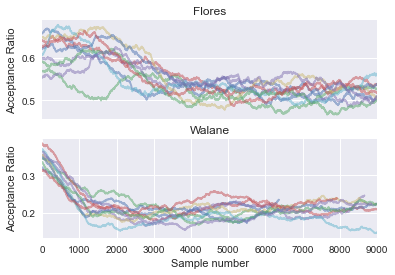

In [73]:
dum_idx=5000 #index to start from
N=2000
fig, ax = plt.subplots()
for current_fault_idx in [0,1]:
    for slurm_id, chain in chains_debug.items():
        fault_idx = chain['fault_idx'][0]
        if fault_idx == current_fault_idx:
  #          print(slurm_id, fault_name(fault_idx))
            accep_ratio = np.convolve(chain['accepted'], np.ones(N)/N, mode='valid')
            plt.subplot(2,1,current_fault_idx+1)
            plt.plot(accep_ratio,alpha=0.5)
            plt.xlim([0,9000])
            plt.title(fault_name(fault_idx))
            if current_fault_idx == 1:
                plt.xlabel('Sample number')
            else:
                plt.xlabel(None)
                plt.xticks([])
            plt.ylabel('Acceptance Ratio')
plt.savefig('accept_ratio.pdf')
            #print(accep_ratio)
#            final_ind = np.shape(chain['acceptance_rate'])[0]
#            chain['acceptance_rate'][5000:final_ind].plot(alpha=0.5)
#            indices = np.linspace(5001,final_ind,final_ind-5000)
#            accept_num = np.multiply(chain['acceptance_rate'][5000:final_ind],indices)
#            acc = (accept_num - chain['acceptance_rate'][5000]*5000)
#            blah = final_ind*np.ones(np.shape(indices))-indices
#            plt.plot(acc/blah[::-1],alpha=0.5)
#            print(acc/blah[::-1])
#            plt.title('Acceptance rate over time')

In [74]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/jaredwhitehead/tsunamibayes'))
if module_path not in sys.path:
    sys.path.append(module_path)
from gauges import build_gauges

ImportError: cannot import name 'Gauge' from 'tsunamibayes' (/Users/jaredwhitehead/Desktop/tsunamibayes/__init__.py)

samples

In [ ]:
#Gelman-Rubin

wal_means = [df.expanding().mean() for df in wal_chains]
wal_vars = [df.expanding().var() for df in wal_chains]

In [ ]:
W = reduce(lambda x, y: x.add(y), wal_vars)/len(wal_vars)
mean = reduce(lambda x, y: x.add(y), wal_means)/len(wal_means)
mean_vars = [(df-mean)**2 for df in wal_means]
B = len(samples[0])*reduce(lambda x, y: x.add(y), mean_vars)/(len(mean_vars)-1)
var_hat = (1-(1/len(wal_chains[0])))*W+(1/len(wal_chains[0]))*B
R = (var_hat/W)**0.5

In [ ]:
R

In [ ]:
fig = plt.figure(figsize=(10,7.5))
#fig = plt.figure()

plt.subplot(2,1,2)
for key in ['latitude','longitude','magnitude','delta_logl','delta_logw','depth_offset']:
    plt.semilogy(R[key],label=parameters[key],linewidth=3)
plt.semilogy(1.1*np.ones(len(R)),'--k',label='$R=1.1$',linewidth=3)
plt.ylim([0.9,5])
plt.xlim([0,5000])
plt.legend()
plt.title('Walane')
#plt.show()


#Gelman-Rubin (Flores)

flo_means = [df.expanding().mean() for df in flo_chains]
flo_vars = [df.expanding().var() for df in flo_chains]

W = reduce(lambda x, y: x.add(y), flo_vars)/len(flo_vars)
mean = reduce(lambda x, y: x.add(y), flo_means)/len(flo_means)
mean_vars = [(df-mean)**2 for df in flo_means]
B = len(samples[0])*reduce(lambda x, y: x.add(y), mean_vars)/(len(mean_vars)-1)
var_hat = (1-(1/len(flo_chains[0])))*W+(1/len(flo_chains[0]))*B
R = (var_hat/W)**0.5

plt.subplot(2,1,1)
for key in ['latitude','longitude','magnitude','delta_logl','delta_logw','depth_offset']:
    plt.semilogy(R[key],label=parameters[key],linewidth=3)
plt.semilogy(1.1*np.ones(len(R)),'--k',label='$R=1.1$',linewidth=3)
plt.legend()
plt.ylim([0.9,5])
plt.xlim([0,5000])
plt.title('Flores')
#plt.show()




plt.savefig('gelman_rubin.pdf')

In [ ]:
#Gelman-Rubin (Flores)

means = [df.expanding().mean() for df in flo_chains]
_vars = [df.expanding().var() for df in flo_chains]

In [ ]:
W = reduce(lambda x, y: x.add(y), _vars)/len(_vars)
mean = reduce(lambda x, y: x.add(y), means)/len(means)
mean_vars = [(df-mean)**2 for df in means]
B = len(samples[0])*reduce(lambda x, y: x.add(y), mean_vars)/(len(mean_vars)-1)
var_hat = (1-(1/len(samples[0])))*W+(1/len(samples[0]))*B
R = (var_hat/W)**0.5

In [ ]:
R

In [ ]:
fig = plt.figure(figsize=(15,7.5))

for key in ['latitude','longitude','magnitude','delta_logl','delta_logw','depth_offset']:
    plt.semilogy(R[key],label=parameters[key],linewidth=3)
plt.semilogy(1.1*np.ones(len(R)),'--k',label='$R=1.1$',linewidth=3)
plt.legend()
plt.ylim([0,5])
plt.title('Gelman-Rubin Diagnostic (Flores)')
plt.show()
#plt.savefig('plots/gelman-rubin.pdf')

In [ ]:
walane_model_params

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.hist(walane_model_params['length']/1000,bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['length']/1000,bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([100,700])
plt.ylim([0,0.0075])
plt.legend()
plt.title('length (km)')

plt.subplot(2,3,2)
plt.hist(walane_model_params['width']/1000,bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['width']/1000,bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([0,250])
plt.ylim([0,0.016])
plt.legend()
plt.title('width (km)')

plt.subplot(2,3,3)
plt.hist(walane_model_params['slip'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['slip'],bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([0,40])
plt.legend()
plt.title('slip (m)')

plt.subplot(2,3,4)
plt.hist(walane_model_params['dip']+walane_model_params['dip_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['dip']+flores_model_params['dip_offset'],bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([12,45])
plt.legend()
plt.title('dip (degrees)')

plt.subplot(2,3,5)
plt.hist(walane_model_params['rake']+walane_model_params['rake_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['rake']+flores_model_params['rake_offset'],bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([40,110])
plt.legend()
plt.title('rake (degrees)')

plt.subplot(2,3,6)
plt.hist(walane_model_params['depth']/1000+walane_model_params['depth_offset'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['depth']/1000+flores_model_params['depth_offset'],bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([10,35])
plt.legend()
plt.title('depth (km)')

plt.tight_layout()

plt.savefig('EQ_params.pdf')

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(walane_samples['magnitude'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_samples['magnitude'],bins=50,alpha=0.5,density=True,label='Flores')
x = np.linspace(6,10,200)
plt.plot(x,magnitude_dist.pdf(x),label='prior pdf',linewidth=3)
plt.xlim([8,9.1])
plt.legend()
plt.title('Magnitude')

plt.subplot(2,2,2)
plt.hist(walane_model_params['length']/1000,bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['length']/1000,bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([100,700])
plt.ylim([0,0.0075])
plt.legend()
plt.title('length (km)')

plt.subplot(2,2,3)
plt.hist(walane_model_params['width']/1000,bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['width']/1000,bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([0,250])
plt.ylim([0,0.016])
plt.legend()
plt.title('width (km)')

plt.subplot(2,2,4)
plt.hist(walane_model_params['slip'],bins=50,alpha=0.5,density=True,label='Walane')
plt.hist(flores_model_params['slip'],bins=50,alpha=0.5,density=True,label='Flores')
plt.xlim([0,40])
plt.legend()
plt.title('slip (m)')
plt.savefig('mag_params.pdf')

In [ ]:
walane_samples.iloc[walane_mle_ind]

In [ ]:
walane_model_params.iloc[walane_mle_ind]

In [ ]:
flores_model_params.iloc[flores_map_ind]

In [ ]:
flores_model_params.iloc[flores_map_ind]['rake']+flores_model_params.iloc[flores_map_ind]['rake_offset']

In [ ]:
walane_model_params.iloc[walane_map_ind]['rake']+walane_model_params.iloc[walane_map_ind]['rake_offset']

In [ ]:
walane_model_output

In [ ]:
walane_model_output['Fault Index'] = np.ones((104970,1))

In [ ]:
flores_model_output

In [ ]:
flores_model_output['Fault Index'] = 0*np.ones((127690,1))

In [ ]:
all_model_output = pd.concat([walane_model_output, flores_model_output])

In [ ]:
all_model_output

In [ ]:
#all_model_output = all_model_output.drop(['Bulukumba arrival'],axis=1) #JPW drop this to test a hypothesis

In [ ]:
train_model_output = all_model_output.sample(frac=.7,replace=False)

In [ ]:
train_model_output

In [ ]:
len(train_model_output.loc[train_model_output['Fault Index']==1])

In [ ]:
indices = train_model_output.index

In [ ]:
test_model_output = all_model_output.drop(indices)

In [ ]:
test_model_output

In [ ]:
len(test_model_output.loc[test_model_output['Fault Index']==1])

In [ ]:
labels = np.array(train_model_output['Fault Index'])

In [ ]:
#data = np.array(train_model_output[['Bulukumba height','Bulukumba arrival','Sumenep height','Sumenep arrival','Nipa-Nipa height','Bima height']])

In [ ]:
data = np.array(train_model_output[['Bulukumba height','Sumenep height','Sumenep arrival','Nipa-Nipa height','Bima height']])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data)
X_scaled = scaler.fit_transform(data)
#X_test_scaled = scaler.transform(np.array(test_model_output.iloc[:,0:6]))
X_test_scaled = scaler.transform(np.array(test_model_output.iloc[:,0:5]))

In [ ]:
#Going to try and use a neural network below:

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [76]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [77]:
X_scaled

NameError: name 'X_scaled' is not defined

In [ ]:
#trainset = dataset(X_scaled,labels)
#DataLoader
#trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_scaled, labels)

In [ ]:
test_predictions = clf.predict(X_test_scaled)

In [ ]:
np.sum(np.abs(test_predictions-np.array(test_model_output['Fault Index'])))/len(test_predictions)

In [ ]:
test_proba = clf.predict_proba(X_test_scaled)

In [ ]:
plt.plot(test_proba)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(X_scaled,labels)

In [ ]:
test_predictions = clf.predict(X_test_scaled)

In [ ]:
np.sum(np.abs(test_predictions-np.array(test_model_output['Fault Index'])))/len(test_predictions)

In [ ]:
1-0.0024929081062494626

In [ ]:
test_proba = clf.predict_proba(X_test_scaled)

In [ ]:
plt.plot(test_proba[:,0])

In [ ]:
bulukumba_dists['height'].rvs(size=2)

In [ ]:
Nsamples = 10000000

bulukumba_height = bulukumba_dists['height'].rvs(size=Nsamples)
bulukumba_arrival = bulukumba_dists['arrival'].rvs(size=Nsamples)
sumenep_height = sumenep_dists['height'].rvs(size=Nsamples)
sumenep_arrival = sumenep_dists['arrival'].rvs(size=Nsamples)
nipa_height = nipa_dists['height'].rvs(size=Nsamples)
bima_height = bima_dists['height'].rvs(size=Nsamples)

In [ ]:
sample_data = np.dstack((bulukumba_height,bulukumba_arrival,sumenep_height,sumenep_arrival,nipa_height,bima_height))

In [ ]:
sample_data = np.dstack((bulukumba_height,sumenep_height,sumenep_arrival,nipa_height,bima_height))

In [ ]:
#sample_data[0,:]

In [ ]:
sample_scaled = scaler.transform(sample_data[0,:])

In [ ]:
sample_predictions = clf.predict(sample_scaled)

In [ ]:
np.mean(sample_predictions)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_scaled, labels)

In [ ]:
test_predictions = xgb_model.predict(X_test_scaled)

In [ ]:
1-np.sum(np.abs(test_predictions-np.array(test_model_output['Fault Index'])))/len(test_predictions)

In [ ]:
sample_predictions = xgb_model.predict(sample_scaled)

In [ ]:
np.mean(sample_predictions)

In [ ]:
plt.hist(bulukumba_height)

In [ ]:
wal_indices = 1==sample_predictions
flo_indices = 0==sample_predictions

In [ ]:
bulukumba_height_wal = bulukumba_height[wal_indices]
#bulukumba_arrival_wal = bulukumba_arrival[wal_indices]
bulukumba_height_flo = bulukumba_height[flo_indices]
#bulukumba_arrival_flo = bulukumba_arrival[flo_indices]
sumenep_height_wal = sumenep_height[wal_indices]
sumenep_arrival_wal = sumenep_arrival[wal_indices]
sumenep_height_flo = sumenep_height[flo_indices]
sumenep_arrival_flo = sumenep_arrival[flo_indices]
nipa_height_wal = nipa_height[wal_indices]
nipa_height_flo = nipa_height[flo_indices]
bima_height_wal = bima_height[wal_indices]
bima_height_flo = bima_height[flo_indices]

In [ ]:
plt.hist(bulukumba_arrival_wal,density=True,bins=5,alpha=0.5,label='Walanae')
plt.hist(bulukumba_arrival_flo,density=True,bins=5,alpha=0.5,label='Flores')

In [ ]:
alpha_wal=.9
alpha_flo=.5
num_bins=15

fig = plt.figure(figsize=(12,7))
plt.subplot(3,2,1)
plt.hist(bulukumba_height_wal,bins=num_bins,alpha=alpha_wal,label='Walane')
plt.hist(bulukumba_height_flo,bins=num_bins,alpha=alpha_flo,label='Flores')
x = np.linspace(0,35,200)
plt.plot(x,bulukumba_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,35])
plt.legend()
plt.title('Bulukumba height')

#plt.subplot(3,2,2)
#plt.hist(bulukumba_arrival_wal,bins=num_bins,alpha=alpha_wal,density=True,label='Walane')
#plt.hist(bulukumba_arrival_flo,bins=num_bins,alpha=alpha_flo,density=True,label='Flores')
#x = np.linspace(0,55,200)
#plt.plot(x,bulukumba_dists['arrival'].pdf(x),label='observational pdf',linewidth=3)
#plt.xlim([0,55])
#plt.legend()
#plt.title('Bulukumba arrival')

plt.subplot(3,2,3)
plt.hist(sumenep_height_wal,bins=num_bins,alpha=alpha_wal,label='Walane')
plt.hist(sumenep_height_flo,bins=num_bins,alpha=alpha_flo,label='Flores')
x = np.linspace(0,5,200)
plt.plot(x,sumenep_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,5])
plt.legend()
plt.title('Sumenep height')

plt.subplot(3,2,4)
plt.hist(sumenep_arrival_wal,bins=num_bins,alpha=alpha_wal,label='Walane')
plt.hist(sumenep_arrival_flo,bins=num_bins,alpha=alpha_flo,label='Flores')
x = np.linspace(0,380,200)
plt.plot(x,sumenep_dists['arrival'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,380])
plt.legend()
plt.title('Sumenep arrival')

plt.subplot(3,2,5)
plt.hist(nipa_height_wal,bins=num_bins,alpha=alpha_wal,label='Walane')
plt.hist(nipa_height_flo,bins=num_bins,alpha=alpha_flo,label='Flores')
x = np.linspace(0,10,200)
plt.plot(x,nipa_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,10])
plt.legend()
plt.title('Nipa height')

plt.subplot(3,2,6)
plt.hist(bima_height_wal,bins=num_bins,alpha=alpha_wal,label='Walane')
plt.hist(bima_height_flo,bins=num_bins,alpha=alpha_flo,label='Flores')
x = np.linspace(0,20,200)
plt.plot(x,bima_dists['height'].pdf(x),label='observational pdf',linewidth=3)
plt.xlim([0,20])
plt.legend()
plt.title('Bima height')

plt.tight_layout()
plt.savefig('Classifier_observations.pdf')

In [ ]:
indices

In [ ]:

len(bulukumba_arrival_wal)

In [ ]:
bayes_data

Now we want to look at the Dupuis stuff

We'll first do this for Flores, and then do Walanae later on

Dupuis
Now we turn to error bounds from Dupuis: https://epubs.siam.org/doi/10.1137/15M1025645
(See also https://arxiv.org/abs/1503.05136, though some equation numbers vary there)
Bound in terms of R(Q||P) from Section 2.2
Dupuis Equations (2.9) and (2.10):
𝔼𝑄[𝑓]−𝔼𝑃[𝑓]≤1𝑐log𝔼𝑃[𝑒𝑐(𝑓−𝔼𝑃[𝑓])]+1𝑐(𝑄||𝑃)𝔼𝑄[𝑓]−𝔼𝑃[𝑓]≥−1𝑐log𝔼𝑃[𝑒−𝑐(𝑓−𝔼𝑃[𝑓])]−1𝑐(𝑄||𝑃)

In [78]:
#Get a particular attribute and stack it into a single array
attr='magnitude'
nthin=1   #optional thinning to reduce computational cost during testing

#f = np.concatenate([ flores_samples[attr].values ])
f = np.concatenate([ walane_samples[attr].values ])
f = f[::nthin]
len(f)

104970

In [79]:
#Equations (2.9) and (2.10)

c = 1

EPf = f.mean() #E_P[f]
expCdelF = np.exp( c*(f-EPf) )  #e^{c*(f-E_P[f])}
ubT1 =  np.log(    expCdelF.mean())/c #1st term of 2.9  (upper bound)
lbT1 = -np.log((1/expCdelF).mean())/c #1st term of 2.10 (lower bound)

print('range on E('+attr+') from variance in posterior is: ['+str(EPf+lbT1)+', '+str(EPf+ubT1)+']')
print('**note that this ignores the R(Q||P) term**')

range on E(magnitude) from variance in posterior is: [8.582707668640694, 8.59797946307012]
**note that this ignores the R(Q||P) term**


/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/2955131920.py:17: RuntimeWarning: overflow encountered in exp
  ub[i,j] = EPf + (np.log((np.exp(  c*ft )).mean())+R)/c  #e^{ c*(f-E_P[f])}
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


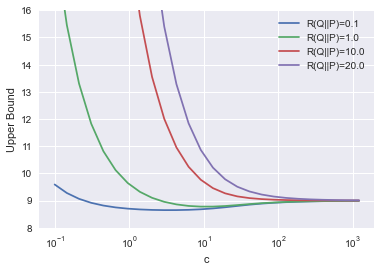

In [80]:
#Show the relationship between the upper bound and c for changing R 

#list of c's to try
#cs = np.power(10.0,np.arange(-3,3))
cs = np.logspace(-1,7)
Rs = [0.1,1.0,10.0,20.0]

#precompute some things
EPf = f.mean() #E_P[f]
ft  = f-EPf    #deviation from mean

#preallocate some other things
ub = np.zeros((len(cs),len(Rs)))

for i,c in enumerate(cs):
    for j,R in enumerate(Rs):
        ub[i,j] = EPf + (np.log((np.exp(  c*ft )).mean())+R)/c  #e^{ c*(f-E_P[f])}

#plot
fig = plt.figure()
plt.semilogx(cs,ub)
plt.legend(['R(Q||P)='+str(R) for R in Rs])
plt.xlabel('c')
plt.ylabel('Upper Bound')
plt.ylim(8,16)
plt.show()

In [81]:
#Compute the optimal R for each c using Justin's method

#list of c's to try
#cs = np.power(10.0,np.arange(-3,3))
cs = np.logspace(-1,7)

#precompute some things
EPf = f.mean() #E_P[f]
ft  = f-EPf    #deviation from mean

#preallocate some other things
ub = np.zeros(len(cs))
lb = np.zeros(len(cs))
wal_Ru = np.zeros(len(cs))
wal_Rl = np.zeros(len(cs))

for i,c in enumerate(cs):
    exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
    expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
    E1u = exppCft.mean()
    E2u = (ft*exppCft).mean()
    E1l = expmCft.mean()
    E2l = (ft*expmCft).mean()
    #print(i,c,E1u,E2u,E1l,E2l)
    wal_Ru[i] =  c*(E2u/E1u) - np.log(E1u)
    wal_Rl[i] = -c*(E2l/E1l) - np.log(E1l)
    ub[i] = EPf + (E2u/E1u)
    lb[i] = EPf + (E2l/E1l)


/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3712910073.py:18: RuntimeWarning: overflow encountered in exp
  exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3712910073.py:25: RuntimeWarning: invalid value encountered in double_scalars
  wal_Ru[i] =  c*(E2u/E1u) - np.log(E1u)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3712910073.py:27: RuntimeWarning: invalid value encountered in double_scalars
  ub[i] = EPf + (E2u/E1u)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3712910073.py:19: RuntimeWarning: overflow encountered in exp
  expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3712910073.py:26: RuntimeWarning: invalid value enco

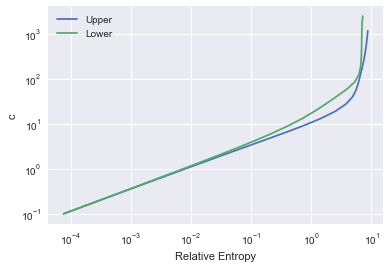

In [82]:
fig = plt.figure()
plt.loglog(wal_Ru,cs,label="Upper")
plt.loglog(wal_Rl,cs,label="Lower")
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('c')
plt.show()

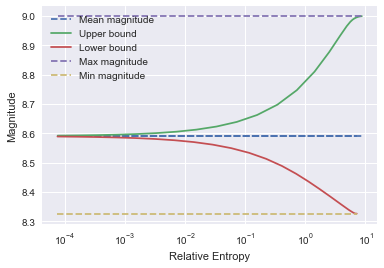

In [83]:
fig = plt.figure()
R = np.concatenate((wal_Rl,wal_Ru))
plt.semilogx(R,EPf*np.ones_like(R),'--',label='Mean '+attr)
plt.semilogx(wal_Ru,ub,label='Upper bound')
plt.semilogx(wal_Rl,lb,label='Lower bound')
plt.semilogx(wal_Ru,f.max()*np.ones(len(wal_Ru)),'--',label='Max '+attr)
plt.semilogx(wal_Rl,f.min()*np.ones(len(wal_Ru)),'--',label='Min '+attr)
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.savefig('walanae_magnitude_log_entropy_bounds.pdf')
plt.show()

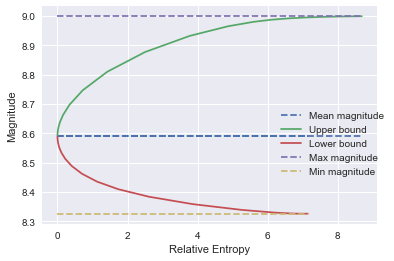

In [84]:
fig = plt.figure()
R = np.concatenate((wal_Rl,wal_Ru))
plt.plot(R,EPf*np.ones_like(R),'--',label='Mean '+attr)
plt.plot(wal_Ru,ub,label='Upper bound')
plt.plot(wal_Rl,lb,label='Lower bound')
plt.plot(wal_Ru,f.max()*np.ones_like(wal_Ru),'--',label='Max '+attr)
plt.plot(wal_Rl,f.min()*np.ones_like(wal_Rl),'--',label='Min '+attr)
plt.legend(loc=(0.7,0.2))
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.savefig('walanae_magnitude_entropy_bounds.pdf')
plt.show()

In [85]:
nthin=1   #optional thinning to reduce computational cost during testing

#list of c's to try
cs = np.logspace(-3,7, num=200)

cols = samples[0].columns[:-1]
ncol = len(cols)

#preallocate some things
ub  = np.zeros((len(cs),ncol))
lb  = np.zeros((len(cs),ncol))
wal_Ru  = np.zeros((len(cs),ncol))
wal_Rl  = np.zeros((len(cs),ncol))
EPf = np.zeros(ncol)
fmax = np.zeros(ncol)
fmin = np.zeros(ncol)

for j,attr in enumerate(cols):
    f = walane_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]

    #Compute the optimal R for each c using Justin's method

    #precompute some things
    EPf[j] = f.mean() #E_P[f]
    ft  = f-EPf[j]    #deviation from mean

    for i,c in enumerate(cs):
        exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
        expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
        E1u = exppCft.mean()
        E2u = (ft*exppCft).mean()
        E1l = expmCft.mean()
        E2l = (ft*expmCft).mean()
        #print(i,c,E1u,E2u,E1l,E2l)
        wal_Ru[i,j] =  c*(E2u/E1u) - np.log(E1u)
        wal_Rl[i,j] = -c*(E2l/E1l) - np.log(E1l)
        ub[i,j] = EPf[j] + (E2u/E1u)
        lb[i,j] = EPf[j] + (E2l/E1l)
    
    fmax[j] = f.max()
    fmin[j] = f.min()

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3970867979.py:30: RuntimeWarning: overflow encountered in exp
  exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3970867979.py:31: RuntimeWarning: overflow encountered in exp
  expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3970867979.py:37: RuntimeWarning: invalid value encountered in double_scalars
  wal_Ru[i,j] =  c*(E2u/E1u) - np.log(E1u)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3970867979.py:38: RuntimeWarning: invalid value encountered in double_scalars
  wal_Rl[i,j] = -c*(E2l/E1l) - np.log(E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_98395/3970867979.py:39: RuntimeWarning:

In [86]:
cols

Index(['latitude', 'longitude', 'magnitude', 'delta_logl', 'delta_logw',
       'depth_offset', 'dip_offset', 'strike_offset', 'rake_offset'],
      dtype='object')

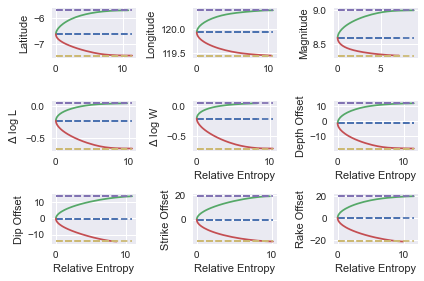

In [87]:
fig,axs = plt.subplots(3,3)
ylabs = [col.title() for col in cols];
ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset";
ylabs[6]="Dip Offset"; ylabs[7]="Strike Offset"; ylabs[8]="Rake Offset";
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    R = np.concatenate((wal_Rl[:,j],wal_Ru[:,j]))
    ax.plot(R,EPf[j]*np.ones_like(R),'--',label='Mean')
    ax.plot(wal_Ru[:,j],ub[:,j],label='Upper bound')
    ax.plot(wal_Rl[:,j],lb[:,j],label='Lower bound')
    ax.plot(R,fmax[j]*np.ones_like(R),'--',label='Max')
    ax.plot(R,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>3:
        ax.set(xlabel='Relative Entropy')

plt.tight_layout()
plt.savefig('dupuis_Walanae.png')
plt.savefig('dupuis_Walanae.pdf')
plt.show()

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/2955131920.py:17: RuntimeWarning: overflow encountered in exp
  ub[i,j] = EPf + (np.log((np.exp(  c*ft )).mean())+R)/c  #e^{ c*(f-E_P[f])}
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


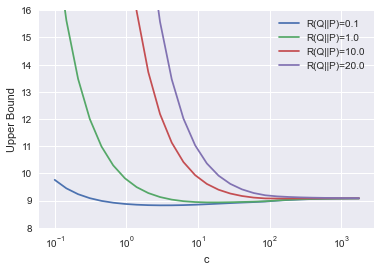

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/2407418720.py:19: RuntimeWarning: overflow encountered in exp
  expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/2407418720.py:26: RuntimeWarning: invalid value encountered in double_scalars
  flo_Rl[i] = -c*(E2l/E1l) - np.log(E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/2407418720.py:28: RuntimeWarning: invalid value encountered in double_scalars
  lb[i] = EPf + (E2l/E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/2407418720.py:18: RuntimeWarning: overflow encountered in exp
  exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/2407418720.py:25: RuntimeWarning: invalid value encounter

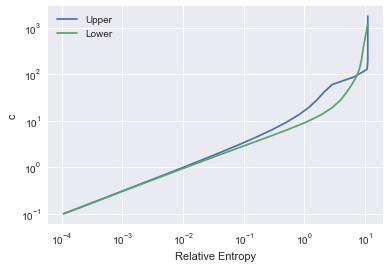

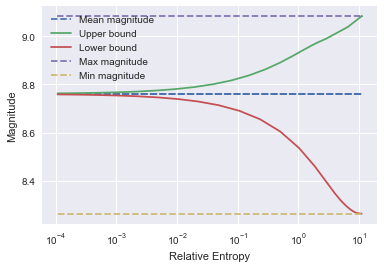

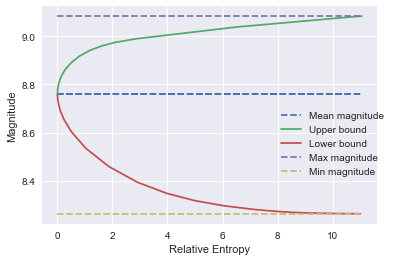

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/3974983666.py:31: RuntimeWarning: overflow encountered in exp
  expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/3974983666.py:38: RuntimeWarning: invalid value encountered in double_scalars
  flo_Rl[i,j] = -c*(E2l/E1l) - np.log(E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/3974983666.py:40: RuntimeWarning: invalid value encountered in double_scalars
  lb[i,j] = EPf[j] + (E2l/E1l)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/3974983666.py:30: RuntimeWarning: overflow encountered in exp
  exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_1845/3974983666.py:37: RuntimeWarning: invalid value en

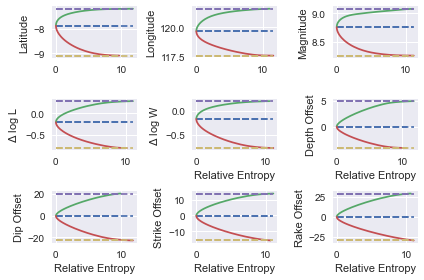

## Bounds in terms of FIM from Section 2.4

Equation (2.35):
$$
\mathcal{R}\left(P^{\theta+v} || P^{\theta} \right) = \frac{1}{2} v^T \mathcal{I}\left( P^{\theta} \right)v + \mathcal{O}\left( |v|^3 \right)
$$
where the Fisher Information Matrix $\mathcal{I}\left( P^{\theta} \right)$ is given by
$$
\mathcal{I}\left( P^{\theta} \right) = \int \nabla_{\theta} \log p^{\theta}(\omega) \left( \nabla_{\theta} \log p^{\theta}(\omega) \right)^T P^{\theta}(d\omega)
$$

### Normal

FIM for normal with parameterized mean $N(\theta_i,\sigma_i^2)$:
$$
\mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\sigma_i^4} \mathbb{V}_{P^{(\theta)}} \left[ \mathcal{G}_i(x) \right]
$$
FIM for normal with parameterized standard deviation $N(m_i,\theta_i^2)$:
$$
\mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\theta_i^6} \mathbb{V}_{P^{(\theta)}} \left[ \left(\mathcal{G}_i(x) - m_i\right)^2 \right]
$$

In [27]:
#negative logpdf
def NormalPhi(G,m,sigma):
    return 0.5*(((G-m)/sigma)**2)+np.log(sigma)+0.5*np.log(2*np.pi)

#gradients
def dNormalPhidMean(G,m,sigma):
    return (m-G)/(sigma**2)

def dNormalPhidStd(G,m,sigma):
    return -((G-m)**2)/(sigma**3)+(1/sigma)

#fisher information (variance of gradients)
def fimNormaldMean(G,m,sigma):
    return np.var(G)/(sigma**4)

def fimNormaldStd(G,m,sigma):
    return np.var((G-m)**2)/(sigma**6)

### Skew normal

Derivations for this were a mess - see Overleaf

In [28]:
def SkewnormPhi(G,m,sigma,a):
    #xt = (G-m)/sigma
    #z  = xt*a/np.sqrt(2)
    #phi = 0.5*(xt**2)+np.log(sigma)+0.5*np.log(2*np.pi) \
    #    -np.log(1+scipy.special.erf(z))
    phi = 0.5*(((G-m)/sigma)**2)+np.log(sigma)+0.5*np.log(2*np.pi) \
        -np.log(1+scipy.special.erf(a*(G-m)/(sigma*np.sqrt(2))))
    return phi

def dSkewnormPhidMean(G,m,sigma,a):
    #return (m-G)/(sigma**2)
    xt = (G-m)/sigma
    z  = xt*a/np.sqrt(2)
    return (-xt + np.sqrt(2/np.pi)*a*np.exp(-z**2)/(1+scipy.special.erf(z)))/sigma

def dSkewnormPhidStd(G,m,sigma,a):
    #return -((G-m)**2)/(sigma**3)+(1/sigma)
    xt = (G-m)/sigma
    z  = xt*a/np.sqrt(2)
    return (1-xt**2 + np.sqrt(2/np.pi)*a*xt*np.exp(-z**2)/(1+scipy.special.erf(z)))/sigma
    
def dSkewnormPhidA(G,m,sigma,a):
    #return (m-G)/(sigma**2)
    xt = (G-m)/sigma
    z  = xt*a/np.sqrt(2)
    return -np.sqrt(2/np.pi)*xt*np.exp(-z**2)/(1+scipy.special.erf(z))

def fimSkewnormdMean(G,m,sigma,a):
    return np.var(dSkewnormPhidMean(G,m,sigma,a))

def fimSkewnormdStd(G,m,sigma,a):
    return np.var(dSkewnormPhidStd(G,m,sigma,a))

def fimSkewnormdA(G,m,sigma,a):
    return np.var(dSkewnormPhidA(G,m,sigma,a))

### Chi

When $\theta_i$ is $k$, then
$$
    \mathcal{I}_{ii}(P^{(\theta)}) = \mathbb{V}_{P^{(\theta)}} \left[ \ln \tilde{x} \right]
$$
When $\theta_i$ is $\mu$, then
$$
    \mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\sigma^2}\mathbb{V}_{P^{(\theta)}} \left[ \tilde{x} - (k-1)\tilde{x}^{-1} \right]
$$
When $\theta_i$ is $\sigma$, then
$$
    \mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\sigma^2}\mathbb{V}_{P^{(\theta)}} \left[ \tilde{x}^2 \right]
$$
where
$$
\tilde{x} = \frac{\mathcal{G}_i(x)-\mu}{\sigma}
$$

In [29]:
#negative logpdf
def ChiPhi(G,mu,sigma,k):
    xt = (G-mu)/sigma
    phi = 0.5*xt**2 + np.log(sigma) + (0.5*k-1)*np.log(2) \
          + np.log(scipy.special.gamma(k/2)) - (k-1)*np.log(xt)
    return phi

#gradients
def dChiPhidK(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return 0.5*np.log(2) + 0.5*scipy.special.digamma(k/2)-np.log(xt)

def dChiPhidMu(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return -(xt-(k-1)/xt)/(sigma)

def dChiPhidSigma(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return -(xt**2-k)/(sigma)

#fisher information (variance of gradients)
def fimChidK(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return np.var(np.log(xt))

def fimChidMu(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return np.var(xt-(k-1)/xt)/(sigma**2)

def fimChidSigma(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return np.var(xt**2)/(sigma**2)

In [30]:

df

latitude   longitude  magnitude  delta_logl  delta_logw  depth_offset  \
0     -6.495026  119.934789   8.493324   -0.087937   -0.082433      3.068378   
1     -6.495026  119.934789   8.493324   -0.087937   -0.082433      3.068378   
2     -6.495026  119.934789   8.493324   -0.087937   -0.082433      3.068378   
3     -6.509323  119.975839   8.500008   -0.092218   -0.082512      3.469798   
4     -6.528860  119.930142   8.453267   -0.089224   -0.077856      3.641713   
...         ...         ...        ...         ...         ...           ...   
10846 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
10847 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
10848 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
10849 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   
10850 -6.944331  119.856613   8.473485   -0.180544   -0.140304     -5.084235   

       dip_offset  strike_offset  rake_offset  fault_idx  ...  \
0        0.604456      -4.587784     9.095775        1.0  ...   
1        0.604456      -4.587784     9.095775        1.0  ...   
2        0.604456      -4.587784     9.095775        1.0  ...   
3        4.342925      -3.295878     5.592857        1.0  ...   
4        4.113935      -6.475085     5.314168        1.0  ...   
...           ...            ...          ...        ...  ...   
10846    7.285851       1.395180    -0.442551        1.0  ...   
10847    7.285851       1.395180    -0.442551        1.0  ...   
10848    7.285851       1.395180    -0.442551        1.0  ...   
10849    7.285851       1.395180    -0.442551        1.0  ...   
10850    7.285851       1.395180    -0.442551        1.0  ...   

       p_m_strike_offset  prior_logpdf        llh  posterior_logpdf  \
0              -1.200740    -23.202972 -22.696736        -45.899708   
1              -5.098389    -23.202972 -22.696736        -45.899708   
2              -3.295878    -23.202972 -22.696736        -45.899708   
3              -6.475085    -22.997681 -22.753014        -45.750695   
4              -5.216681    -23.387791 -22.747438        -46.135229   
...                  ...           ...        ...               ...   
10846                NaN    -24.556209 -21.938227        -46.494436   
10847           6.194107    -24.556209 -21.938227        -46.494436   
10848                NaN    -24.556209 -21.938227        -46.494436   
10849           3.896311    -24.556209 -21.938227        -46.494436   
10850                NaN    -24.556209 -21.938227        -46.494436   

       p_prior_logpdf      p_llh  p_posterior_logpdf     alpha  accepted  \
0          -24.755335 -22.852618          -47.607953  0.181184       0.0   
1          -22.215715       -inf                -inf  0.000000       0.0   
2          -22.997681 -22.753014          -45.750695  1.160688       1.0   
3          -23.387791 -22.747438          -46.135229  0.680768       1.0   
4          -22.704687       -inf                -inf  0.000000       0.0   
...               ...        ...                 ...       ...       ...   
10846            -inf        NaN                 NaN  0.000000       0.0   
10847      -25.898415 -21.477997          -47.376412  0.413964       0.0   
10848            -inf        NaN                 NaN  0.000000       0.0   
10849      -25.414956 -22.724482          -48.139438  0.193012       0.0   
10850            -inf        NaN                 NaN  0.000000       0.0   

       acceptance_rate  
0             0.000000  
1             0.000000  
2             0.333333  
3             0.500000  
4             0.400000  
...                ...  
10846         0.230095  
10847         0.230074  
10848         0.230053  
10849         0.230031  
10850         0.230010  

[10851 rows x 55 columns]

In [31]:
dists = []

# Bulukumba
dist = dict()
dist['name'] = 'Bulukumba'
dist['height'] = stats.norm(loc=18,scale=5) # record says 60-80 feet;
dist['arrival'] = stats.norm(loc=15,scale=10)
dists.append(dist)

# Sumenep
dist = dict()
dist['name'] = 'Sumenep'
dist['height'] = stats.truncnorm(loc=1.5,scale=1,a=-1,b=4)
dist['arrival'] = stats.norm(loc=240,scale=45)
dists.append(dist)

# Nipa-Nipa
dist = dict()
dist['name'] = 'Nipa-Nipa'
dist['height'] = stats.truncnorm(loc=3,scale=2,a=-1,b=4)
dists.append(dist)

# Bima
dist = dict()
dist['name'] = 'Bima'
dist['height'] = stats.truncnorm(loc=10,scale=4,a=-2.25,b=4)
dists.append(dist)

In [32]:
walane_model_output['Bulukumba height'].values

array([8.29507771, 8.29507771, 8.29507771, ..., 5.20158478, 5.20158478,
       5.20158478])

In [33]:
#Walanae first
#this computes the diagonal components
nthin = 1 #optional thinning of model outputs

FIM = pd.DataFrame(columns = ['Name', 'Observation', 'Distribution', 'Parameter', 'Fisher Information'])
for location in dists:
    for key in ['arrival','height']:
        if key in location:
            dist=location[key]
            attr=location['name']+' '+key
            G = walane_model_output[attr].values
#            G = np.concatenate([ df[attr].values for df in model_output ])
            print(G)
            G = G[::nthin]

            #normal distribution
            if isinstance(dist.dist, stats._continuous_distns.norm_gen) or isinstance(dist.dist, stats._continuous_distns.truncnorm_gen):
                m = dist.__dict__['kwds']['loc'] #dist.mean()
                sigma = dist.__dict__['kwds']['scale'] #dist.std()
                #print('Found normal at',attr,'with mean',m,'and std',sigma)
                fimm = fimNormaldMean(G,m,sigma)
                fims = fimNormaldStd(G,m,sigma)
                #print('dNdm =',dNdm,', dNds =',dNds)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'mean', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'std', 'Fisher Information' : fims }, 
                    ignore_index = True)
            
            #skewnorm distribution
            elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
                m = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                a = dist.__dict__['kwds']['a']
                #print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
                fimm = fimSkewnormdMean(G,m,sigma,a)
                fims = fimSkewnormdStd(G,m,sigma,a)
                fima = fimSkewnormdA(G,m,sigma,a)
                #print('dSNdm =',dNdm,', dSNds =',dNds, ', dSNda = TBD ;-)')
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'mean', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'std', 'Fisher Information' : fims }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'a', 'Fisher Information' : fima }, 
                    ignore_index = True)
            
            #chi distribution
            elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
                mu = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                dof = dist.__dict__['kwds']['df']
                #print('Found chi at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
                fimm = fimChidMu(G,mu,sigma,dof)
                fims = fimChidSigma(G,mu,sigma,dof)
                fimk = fimChidK(G,mu,sigma,dof)
                #print('dChidm =',dChidm,', dChids =',dChids, ', dChidk =',dChidk)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'mu', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'sigma', 'Fisher Information' : fims }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'dof', 'Fisher Information' : fimk }, 
                    ignore_index = True)
            #other
            else:
                print('ERROR: Distribution for',attr,'not found')

FIM

[19.09401444 19.09401444 19.09401444 ... 25.34879889 25.34879889
 25.34879889]
[8.29507771 8.29507771 8.29507771 ... 5.20158478 5.20158478 5.20158478]
[184.77911667 184.77911667 184.77911667 ... 184.76095556 184.76095556
 184.76095556]
[1.00867931 1.00867931 1.00867931 ... 0.7241054  0.7241054  0.7241054 ]
[6.84362587 6.84362587 6.84362587 ... 3.13941577 3.13941577 3.13941577]
[2.80610763 2.80610763 2.80610763 ... 1.7711706  1.7711706  1.7711706 ]


/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2347087286.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2347087286.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2347087286.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2347087286.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykern

Name Observation Distribution Parameter Fisher Information
0   Bulukumba     arrival       normal      mean           0.013508
1   Bulukumba     arrival       normal       std           0.010173
2   Bulukumba      height       normal      mean           0.005297
3   Bulukumba      height       normal       std           0.089685
4     Sumenep     arrival       normal      mean           0.000005
5     Sumenep     arrival       normal       std           0.000023
6     Sumenep      height       normal      mean           0.055738
7     Sumenep      height       normal       std            0.07407
8   Nipa-Nipa      height       normal      mean           0.149131
9   Nipa-Nipa      height       normal       std           1.105353
10       Bima      height       normal      mean           0.003258
11       Bima      height       normal       std             0.0445

In [34]:
#Compute sensitivity bounds from equation (2.39)

nthin = 1 #optional thinning of sample data

sensDF = FIM.copy()

cols = samples[0].columns[:-1]
ncol = len(cols)

for j,attr in enumerate(cols):
    print(attr)
    f = walane_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    print('Variance for',attr,'is:',fvar)
    
    #Equation (2.39)
    #print(np.sqrt(np.array(sensDF['Fisher Information'], dtype=np.float64)))
    sensDF['S_'+attr] = np.sqrt(fvar*np.array(sensDF['Fisher Information'], dtype=np.float64))

sensDF

latitude
Variance for latitude is: 0.06256625381970234
longitude
Variance for longitude is: 0.021196567216635685
magnitude
Variance for magnitude is: 0.015278433201369302
delta_logl
Variance for delta_logl is: 0.011338529464908079
delta_logw
Variance for delta_logw is: 0.012896959570498051
depth_offset
Variance for depth_offset is: 20.22126484932887
dip_offset
Variance for dip_offset is: 11.87921757534586
strike_offset
Variance for strike_offset is: 23.789140317063595
rake_offset
Variance for rake_offset is: 30.088094551952057


Name Observation Distribution Parameter Fisher Information  \
0   Bulukumba     arrival       normal      mean           0.013508   
1   Bulukumba     arrival       normal       std           0.010173   
2   Bulukumba      height       normal      mean           0.005297   
3   Bulukumba      height       normal       std           0.089685   
4     Sumenep     arrival       normal      mean           0.000005   
5     Sumenep     arrival       normal       std           0.000023   
6     Sumenep      height       normal      mean           0.055738   
7     Sumenep      height       normal       std            0.07407   
8   Nipa-Nipa      height       normal      mean           0.149131   
9   Nipa-Nipa      height       normal       std           1.105353   
10       Bima      height       normal      mean           0.003258   
11       Bima      height       normal       std             0.0445   

    S_latitude  S_longitude  S_magnitude  S_delta_logl  S_delta_logw  \
0     0.029071     0.016921     0.014366      0.012376      0.013199   
1     0.025229     0.014685     0.012467      0.010740      0.011454   
2     0.018205     0.010596     0.008996      0.007750      0.008265   
3     0.074908     0.043601     0.037017      0.031889      0.034010   
4     0.000538     0.000313     0.000266      0.000229      0.000244   
5     0.001205     0.000702     0.000596      0.000513      0.000547   
6     0.059053     0.034372     0.029182      0.025139      0.026811   
7     0.068076     0.039624     0.033640      0.028980      0.030908   
8     0.096595     0.056223     0.047734      0.041121      0.043856   
9     0.262979     0.153068     0.129954      0.111951      0.119397   
10    0.014277     0.008310     0.007055      0.006078      0.006482   
11    0.052766     0.030713     0.026075      0.022463      0.023957   

    S_depth_offset  S_dip_offset  S_strike_offset  S_rake_offset  
0         0.522634      0.400579         0.566870       0.637516  
1         0.453560      0.347636         0.491949       0.553258  
2         0.327282      0.250848         0.354982       0.399222  
3         1.346679      1.032176         1.460660       1.642696  
4         0.009666      0.007409         0.010485       0.011791  
5         0.021668      0.016608         0.023502       0.026431  
6         1.061645      0.813709         1.151501       1.295008  
7         1.223842      0.938027         1.327427       1.492858  
8         1.736554      1.331000         1.883534       2.118270  
9         4.727752      3.623635         5.127905       5.766973  
10        0.256666      0.196725         0.278390       0.313085  
11        0.948608      0.727070         1.028897       1.157124

In [35]:
print(sensDF.to_latex(index=False,formatters={
    'Fisher Information' : '{:.1e}'.format,
    'S_latitude'         : '{:.3f}'.format,
    'S_longitude'        : '{:.3f}'.format,
    'S_magnitude'        : '{:.3f}'.format,
    'S_delta_logl'       : '{:.3f}'.format,
    'S_delta_logw'       : '{:.3f}'.format,
    'S_depth_offset'     : '{:.3f}'.format,
    'S_dip_offset'       : '{:.3f}'.format,
    'S_strike_offset'    : '{:.3f}'.format,
    'S_rake_offset'      : '{:.3f}'.format,
    }))

\begin{tabular}{lllllrrrrrrrrr}
\toprule
     Name & Observation & Distribution & Parameter & Fisher Information & S\_latitude & S\_longitude & S\_magnitude & S\_delta\_logl & S\_delta\_logw & S\_depth\_offset & S\_dip\_offset & S\_strike\_offset & S\_rake\_offset \\
\midrule
Bulukumba &     arrival &       normal &      mean &           0.013508 &      0.029 &       0.017 &       0.014 &        0.012 &        0.013 &          0.523 &        0.401 &           0.567 &         0.638 \\
Bulukumba &     arrival &       normal &       std &           0.010173 &      0.025 &       0.015 &       0.012 &        0.011 &        0.011 &          0.454 &        0.348 &           0.492 &         0.553 \\
Bulukumba &      height &       normal &      mean &           0.005297 &      0.018 &       0.011 &       0.009 &        0.008 &        0.008 &          0.327 &        0.251 &           0.355 &         0.399 \\
Bulukumba &      height &       normal &       std &           0.089685 &      0.075 & 

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1471251123.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sensDF.to_latex(index=False,formatters={


In [36]:
#compute the derivatives for each distribution parameter
nthin = 1 #optional thinning of model outputs

derivs = pd.DataFrame(columns = ['Name', 'Observation', 'Distribution', 'Parameter', 'Value', 'Derivative'])
for location in dists:
    for key in ['arrival','height']:
        if key in location:
            dist=location[key]
            attr=location['name']+' '+key
            G = walane_model_output[attr].values
#            G = np.concatenate([ df[attr].values for df in model_output ])
            G = G[::nthin]

            #normal distribution
            if isinstance(dist.dist, stats._continuous_distns.norm_gen) or isinstance(dist.dist, stats._continuous_distns.truncnorm_gen):
                m = dist.__dict__['kwds']['loc'] #dist.mean()
                sigma = dist.__dict__['kwds']['scale'] #dist.std()
                #print('Found normal at',attr,'with mean',m,'and std',sigma)
                dm = dNormalPhidMean(G,m,sigma)
                ds = dNormalPhidStd(G,m,sigma)
                #print('dNdm =',dm,', dNds =',ds)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'mean', 'Value' : m, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'std', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
            
            #skewnorm distribution
            elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
                m = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                a = dist.__dict__['kwds']['a']
                #print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
                dm = dSkewnormPhidMean(G,m,sigma,a)
                ds = dSkewnormPhidStd(G,m,sigma,a)
                da = dSkewnormPhidA(G,m,sigma,a)
                #print('dSNdm =',dm,', dSNds =',ds, ', dSNda =',da)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'mean', 'Value' : m, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'std', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'a', 'Value' : a, 'Derivative' : da }, 
                    ignore_index = True)

            #chi distribution
            elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
                mu = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                dof = dist.__dict__['kwds']['df']
                #print('Found chi at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
                dm = dChiPhidMu(G,mu,sigma,dof)
                ds = dChiPhidSigma(G,mu,sigma,dof)
                dk = dChiPhidK(G,mu,sigma,dof)
                #print('dChidm =',dm,', dChids =',ds, ', dChidk =',dk)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'mu', 'Value' : mu, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'sigma', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'dof', 'Value' : dof, 'Derivative' : dk }, 
                    ignore_index = True)

            else:
                print('ERROR: Distribution for',attr,'not found')

derivs

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1878254813.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1878254813.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1878254813.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1878254813.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764

Name Observation Distribution Parameter Value  \
0   Bulukumba     arrival       normal      mean    15   
1   Bulukumba     arrival       normal       std    10   
2   Bulukumba      height       normal      mean    18   
3   Bulukumba      height       normal       std     5   
4     Sumenep     arrival       normal      mean   240   
5     Sumenep     arrival       normal       std    45   
6     Sumenep      height       normal      mean   1.5   
7     Sumenep      height       normal       std     1   
8   Nipa-Nipa      height       normal      mean     3   
9   Nipa-Nipa      height       normal       std     2   
10       Bima      height       normal      mean    10   
11       Bima      height       normal       std     4   

                                           Derivative  
0   [-0.04094014444444444, -0.04094014444444444, -...  
1   [0.08323904572868027, 0.08323904572868027, 0.0...  
2   [0.38819689160000004, 0.38819689160000004, 0.3...  
3   [-0.5534841332395108, -0.5534841332395108, -0....  
4   [0.027269572016460897, 0.027269572016460897, 0...  
5   [-0.011241107886020407, -0.011241107886020407,...  
6   [0.4913206933333334, 0.4913206933333334, 0.491...  
7   [0.7586039763024526, 0.7586039763024526, 0.758...  
8   [-0.9609064666666669, -0.9609064666666669, -0....  
9   [-1.3466824753636364, -1.3466824753636364, -1....  
10  [0.4496182729166667, 0.4496182729166667, 0.449...  
11  [-0.5586263653622646, -0.5586263653622646, -0....

In [37]:
#get the full FIM
dMat = np.vstack(derivs['Derivative'])
fimFullAbs = np.cov(dMat)
fimDiagAbs = np.diagonal(fimFullAbs)
derivs['FI'] = fimDiagAbs
fimDiagAbs

array([1.35080193e-02, 1.01733787e-02, 5.29711133e-03, 8.96858369e-02,
       4.62089917e-06, 2.32181216e-05, 5.57383711e-02, 7.40707303e-02,
       1.49132457e-01, 1.10536384e+00, 3.25787098e-03, 4.45009192e-02])

In [38]:
#Convert FIM from absolute changes to relative changes
vals=np.array(derivs['Value'],dtype=float)
fimFull = np.diag(vals) @ fimFullAbs @ np.diag(vals)
fimDiag = np.diagonal(fimFull)

In [39]:
#size of perturbation for RE=1
derivs['FI Rel'] = fimDiag
derivs['Perturbation'] = np.sqrt(2/fimDiag)
#derivs['Rel Perturbation'] = derivs['Perturbation']/derivs['Value']
derivs['R 0.1'] = 0.5*fimDiag*(0.1**2)

#check that scaled FIM and absolute FIM produce the same RE=1 perturbations
print("norm difference between RE=1 relative perturbations computed with the absolute FIM and relative FIM is:", \
      np.linalg.norm( derivs['Perturbation'] - np.sqrt(2/fimDiagAbs)/vals ) )

derivs.loc[:, derivs.columns != 'Derivative']

norm difference between RE=1 relative perturbations computed with the absolute FIM and relative FIM is: 2.220446049250313e-16


Name Observation Distribution Parameter Value        FI    FI Rel  \
0   Bulukumba     arrival       normal      mean    15  0.013508  3.039304   
1   Bulukumba     arrival       normal       std    10  0.010173  1.017338   
2   Bulukumba      height       normal      mean    18  0.005297  1.716264   
3   Bulukumba      height       normal       std     5  0.089686  2.242146   
4     Sumenep     arrival       normal      mean   240  0.000005  0.266164   
5     Sumenep     arrival       normal       std    45  0.000023  0.047017   
6     Sumenep      height       normal      mean   1.5  0.055738  0.125411   
7     Sumenep      height       normal       std     1  0.074071  0.074071   
8   Nipa-Nipa      height       normal      mean     3  0.149132  1.342192   
9   Nipa-Nipa      height       normal       std     2  1.105364  4.421455   
10       Bima      height       normal      mean    10  0.003258  0.325787   
11       Bima      height       normal       std     4  0.044501  0.712015   

    Perturbation     R 0.1  
0       0.811200  0.015197  
1       1.402111  0.005087  
2       1.079501  0.008581  
3       0.944459  0.011211  
4       2.741199  0.001331  
5       6.522122  0.000235  
6       3.993435  0.000627  
7       5.196270  0.000370  
8       1.220696  0.006711  
9       0.672562  0.022107  
10      2.477696  0.001629  
11      1.675986  0.003560

In [40]:
print(derivs.drop(['Derivative','FI'],axis=1).to_latex(index=False,formatters={
    'FI Rel' : '{:.3f}'.format,
    'Perturbation'          : '{:.3f}'.format,
    }))

\begin{tabular}{lllllrrr}
\toprule
     Name & Observation & Distribution & Parameter & Value & FI Rel & Perturbation &    R 0.1 \\
\midrule
Bulukumba &     arrival &       normal &      mean &    15 &  3.039 &        0.811 & 0.015197 \\
Bulukumba &     arrival &       normal &       std &    10 &  1.017 &        1.402 & 0.005087 \\
Bulukumba &      height &       normal &      mean &    18 &  1.716 &        1.080 & 0.008581 \\
Bulukumba &      height &       normal &       std &     5 &  2.242 &        0.944 & 0.011211 \\
  Sumenep &     arrival &       normal &      mean &   240 &  0.266 &        2.741 & 0.001331 \\
  Sumenep &     arrival &       normal &       std &    45 &  0.047 &        6.522 & 0.000235 \\
  Sumenep &      height &       normal &      mean &   1.5 &  0.125 &        3.993 & 0.000627 \\
  Sumenep &      height &       normal &       std &     1 &  0.074 &        5.196 & 0.000370 \\
Nipa-Nipa &      height &       normal &      mean &     3 &  1.342 &        1.221 

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/485961333.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(derivs.drop(['Derivative','FI'],axis=1).to_latex(index=False,formatters={


In [41]:
#svd
u, s, vh = np.linalg.svd(fimFull)
#checks
print("||u-v||             =",np.linalg.norm(u-vh.T))
print("||M*u_1 - s_1 u_1|| =",np.linalg.norm(np.matmul(fimFull,u[:,0]) - s[0]*u[:,0]))
#print s
print("singular values:")
display(s)
print("leading singular vector:")
display(u[:,0])

||u-v||             = 1.650735262007586e-14
||M*u_1 - s_1 u_1|| = 4.508722185830055e-15
singular values:


array([9.44052741e+00, 3.23586680e+00, 1.08678202e+00, 7.04202133e-01,
       5.65620333e-01, 1.81001174e-01, 8.40386791e-02, 1.90854500e-02,
       7.48244555e-03, 3.32847351e-03, 1.12736061e-03, 1.01773277e-04])

leading singular vector:


array([-0.21160633,  0.0256264 ,  0.39785739, -0.44622063, -0.0489733 ,
        0.02120429,  0.08428698, -0.06329119,  0.36524317,  0.66027778,
        0.0664629 , -0.09704627])

<IPython.core.display.Javascript object>


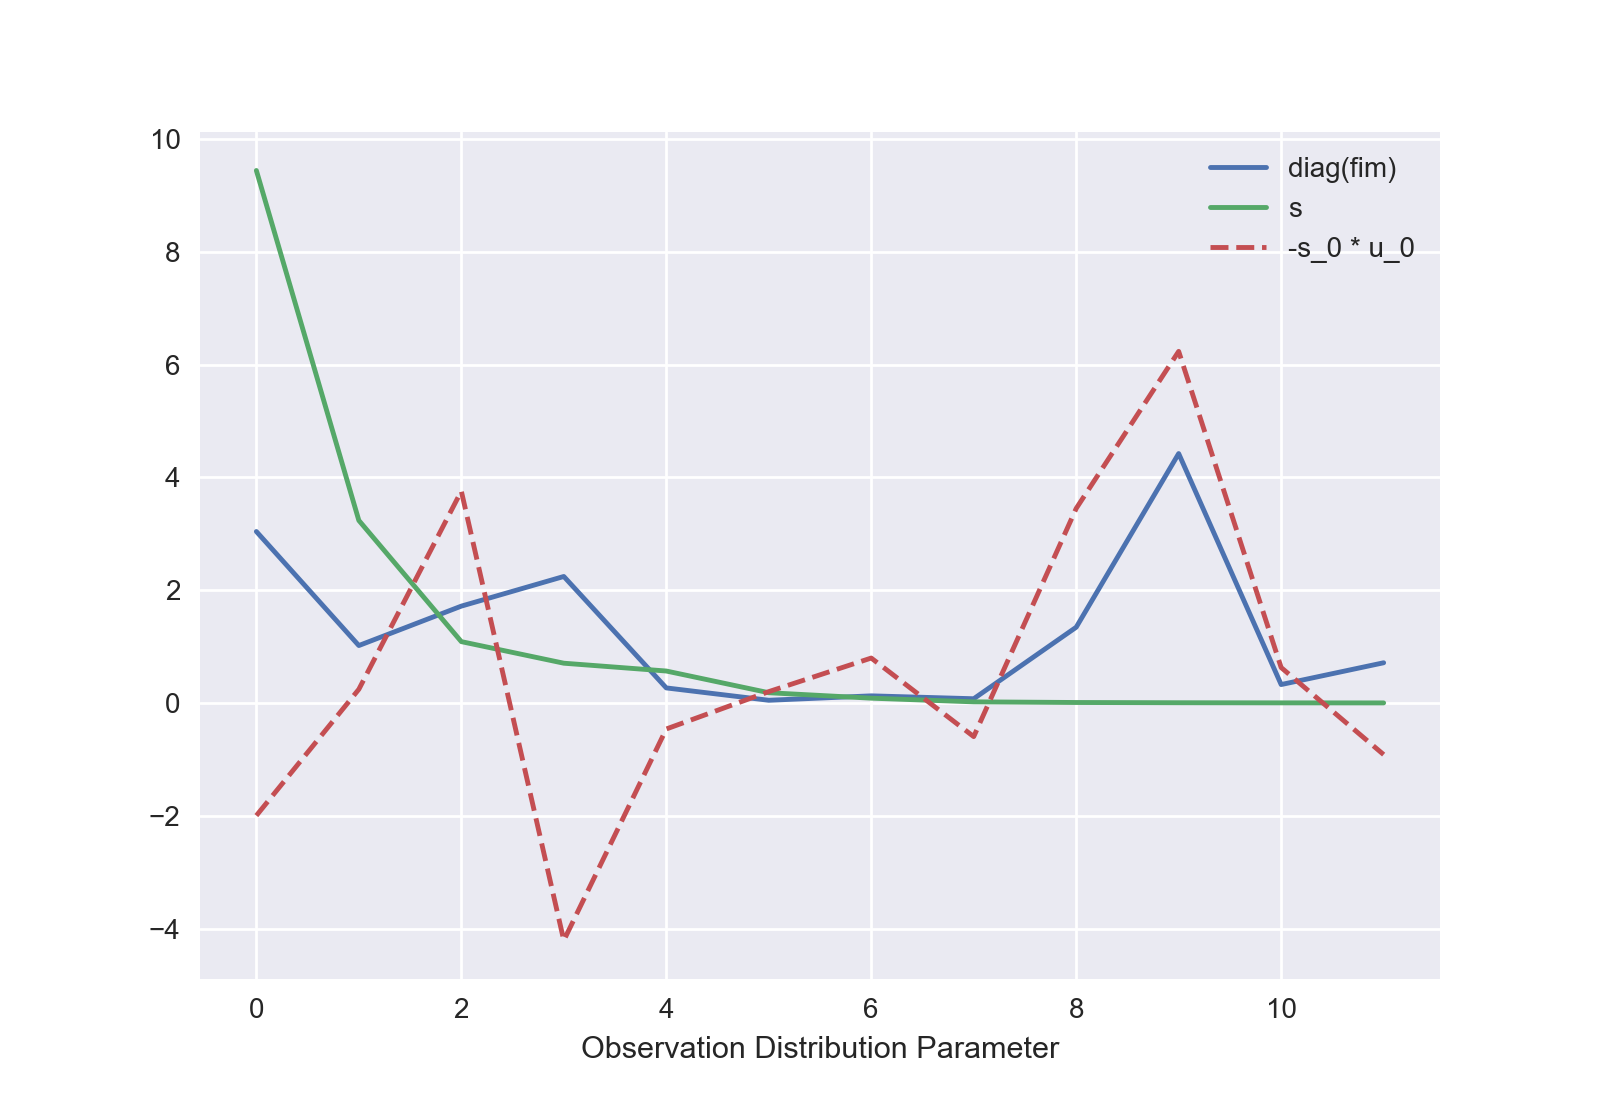

In [42]:
fig = plt.figure()
plt.plot(np.diagonal(fimFull),label="diag(fim)")
plt.plot(s,label="s")
plt.plot(u[:,0]*s[0],"--",label="-s_0 * u_0")
plt.legend()
plt.xlabel('Observation Distribution Parameter')
#plt.ylabel('Magnitude')
plt.show()

In [43]:
derivs['Sing Vec'] = u[:,0]
derivs_print = derivs.drop(['Derivative','FI','Perturbation'],axis=1)
print(derivs_print.to_latex(index=False,formatters={
    'FI Rel'   : '{:.3f}'.format,
    'R 0.1'    : '{:.3f}'.format,
    'Sing Vec' : '{:.3f}'.format,
    }))
derivs_print

\begin{tabular}{lllllrrr}
\toprule
     Name & Observation & Distribution & Parameter & Value & FI Rel & R 0.1 & Sing Vec \\
\midrule
Bulukumba &     arrival &       normal &      mean &    15 &  3.039 & 0.015 &   -0.212 \\
Bulukumba &     arrival &       normal &       std &    10 &  1.017 & 0.005 &    0.026 \\
Bulukumba &      height &       normal &      mean &    18 &  1.716 & 0.009 &    0.398 \\
Bulukumba &      height &       normal &       std &     5 &  2.242 & 0.011 &   -0.446 \\
  Sumenep &     arrival &       normal &      mean &   240 &  0.266 & 0.001 &   -0.049 \\
  Sumenep &     arrival &       normal &       std &    45 &  0.047 & 0.000 &    0.021 \\
  Sumenep &      height &       normal &      mean &   1.5 &  0.125 & 0.001 &    0.084 \\
  Sumenep &      height &       normal &       std &     1 &  0.074 & 0.000 &   -0.063 \\
Nipa-Nipa &      height &       normal &      mean &     3 &  1.342 & 0.007 &    0.365 \\
Nipa-Nipa &      height &       normal &       std &    

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1473481791.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(derivs_print.to_latex(index=False,formatters={


Name Observation Distribution Parameter Value    FI Rel     R 0.1  \
0   Bulukumba     arrival       normal      mean    15  3.039304  0.015197   
1   Bulukumba     arrival       normal       std    10  1.017338  0.005087   
2   Bulukumba      height       normal      mean    18  1.716264  0.008581   
3   Bulukumba      height       normal       std     5  2.242146  0.011211   
4     Sumenep     arrival       normal      mean   240  0.266164  0.001331   
5     Sumenep     arrival       normal       std    45  0.047017  0.000235   
6     Sumenep      height       normal      mean   1.5  0.125411  0.000627   
7     Sumenep      height       normal       std     1  0.074071  0.000370   
8   Nipa-Nipa      height       normal      mean     3  1.342192  0.006711   
9   Nipa-Nipa      height       normal       std     2  4.421455  0.022107   
10       Bima      height       normal      mean    10  0.325787  0.001629   
11       Bima      height       normal       std     4  0.712015  0.003560   

    Sing Vec  
0  -0.211606  
1   0.025626  
2   0.397857  
3  -0.446221  
4  -0.048973  
5   0.021204  
6   0.084287  
7  -0.063291  
8   0.365243  
9   0.660278  
10  0.066463  
11 -0.097046

\begin{tabular}{lll}
\toprule
     Parameter &   Variance & Sensitivity \\
\midrule
      Latitude &   0.062566 &    0.076854 \\
     Longitude &   0.021197 &    0.044733 \\
     Magnitude &   0.015278 &    0.037978 \\
$\Delta$ log L &   0.011339 &    0.032717 \\
$\Delta$ log W &   0.012897 &    0.034893 \\
  Depth Offset &  20.221265 &    1.381664 \\
    Dip Offset &  11.879218 &     1.05899 \\
 Strike Offset &   23.78914 &    1.498606 \\
   Rake Offset &  30.088095 &    1.685371 \\
\bottomrule
\end{tabular}



/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3093996940.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3093996940.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3093996940.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)
/var/folders/t5/qjwb246n5

Parameter   Variance Sensitivity
0        Latitude   0.062566    0.076854
1       Longitude   0.021197    0.044733
2       Magnitude   0.015278    0.037978
3  $\Delta$ log L   0.011339    0.032717
4  $\Delta$ log W   0.012897    0.034893
5    Depth Offset  20.221265    1.381664
6      Dip Offset  11.879218     1.05899
7   Strike Offset   23.78914    1.498606
8     Rake Offset  30.088095    1.685371

<IPython.core.display.Javascript object>


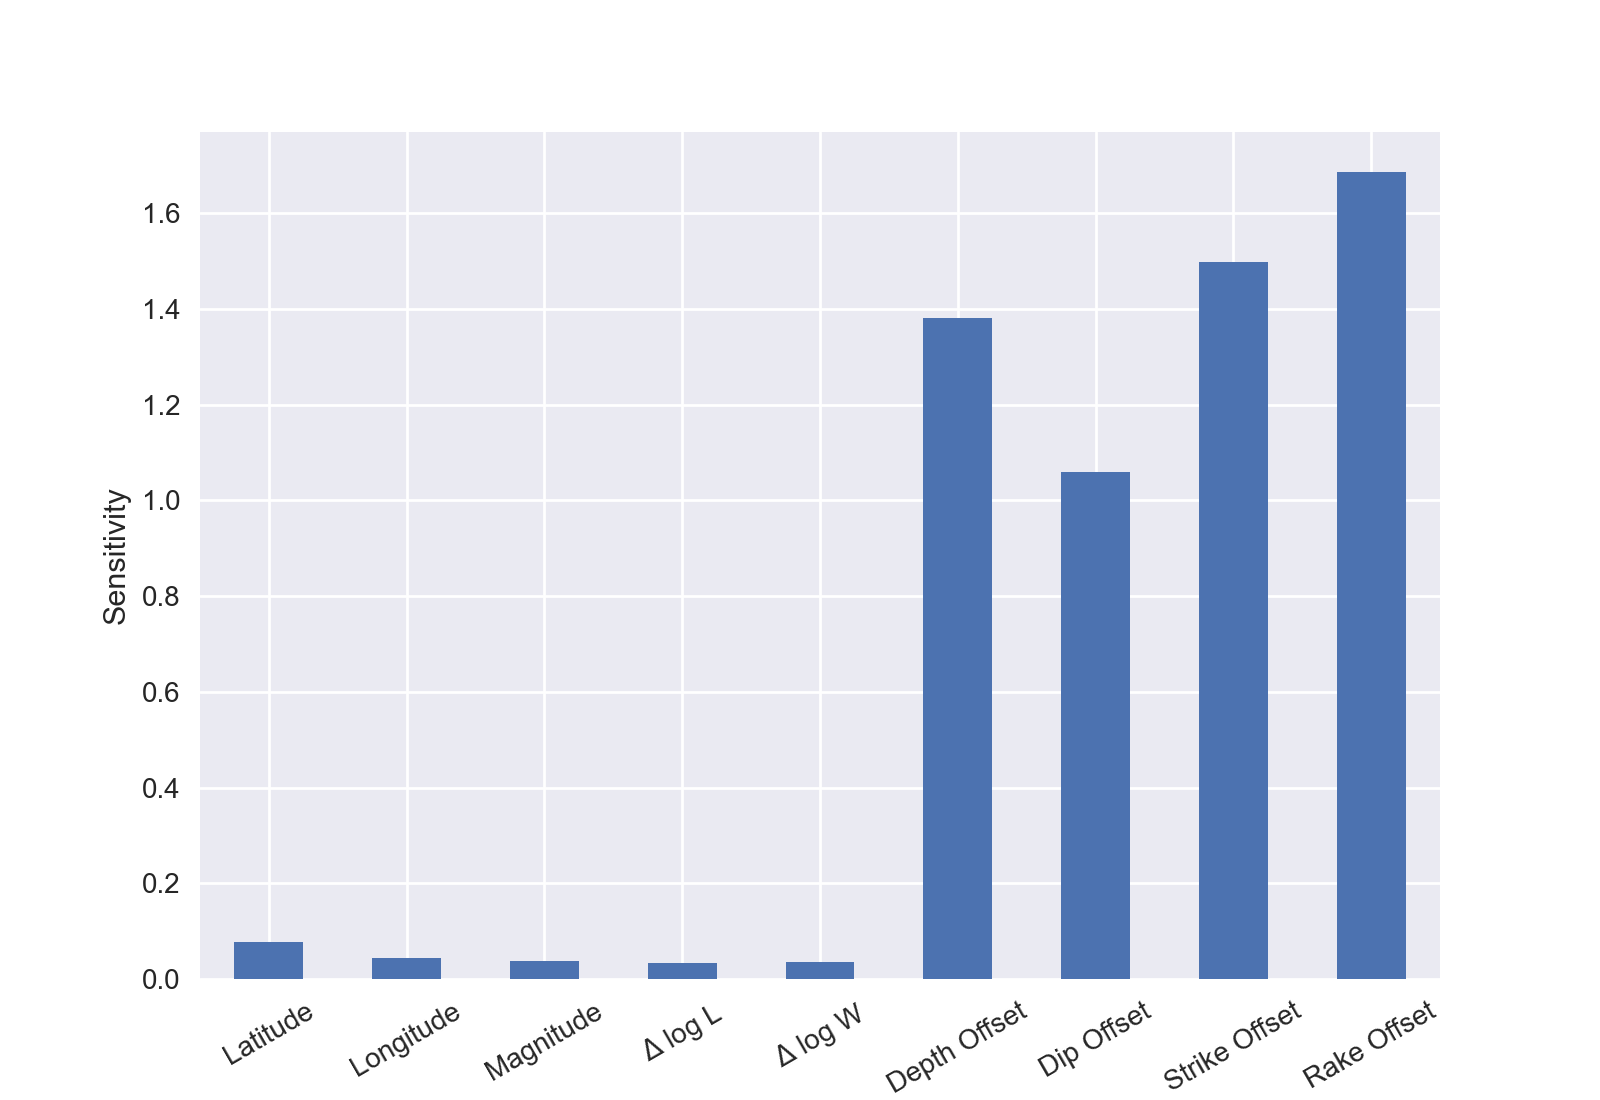

[Text(0, 0.5, 'Sensitivity')]

In [44]:
#Compute sensitivity bounds from equation (2.39)
#for perturbation by first singular vector
#(in which case variance is the first singular value)

nthin = 1 #optional thinning of sample data

normv = 0.1 #size of relative perturbation

sensDF = pd.DataFrame(columns = ['Parameter', 'Variance', 'Sensitivity'])

cols = samples[0].columns[:-1]
ncol = len(cols)

for attr in cols:
    f = walane_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    
    #Equation (2.39)
    sens = np.sqrt(fvar*s[0])*normv

    sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)

sensDF['Parameter'] = [col.replace("_"," ").replace("log","log ").title().replace("Log","log").replace("Delta","$\Delta$") for col in cols]; 
#ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
print(sensDF.to_latex(index=False,escape=False,formatters={
    'Variance' : '{:.3f}'.format,
    'Sensitivity' : '{:.3f}'.format,
    }))

display(sensDF)

#ax = sensDF.loc[sensDF['Parameter'] != 'depth_offset',:].plot(kind='bar',x='Parameter',y='Sensitivity',legend=False)
ax = sensDF.plot(kind='bar',x='Parameter',y='Sensitivity',legend=False)
plt.xticks(rotation=30)
ax.set(ylabel="Sensitivity")

In [45]:
#Compute sensitivity bounds from equation (2.39)

nthin = 1 #optional thinning of sample data

sensDF = derivs.copy()
sensDF = sensDF.drop(['Derivative','FI','Perturbation'],axis=1)

cols = samples[0].columns[:-1]
ncol = len(cols)

for j,attr in enumerate(cols):
    f = walane_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    print('Variance for',attr,'is:',fvar)
    
    #Equation (2.39)
    sensDF['S_'+attr] = np.sqrt(fvar*sensDF['FI Rel'])

sensDF

Variance for latitude is: 0.06256625381970234
Variance for longitude is: 0.021196567216635685
Variance for magnitude is: 0.015278433201369302
Variance for delta_logl is: 0.011338529464908079
Variance for delta_logw is: 0.012896959570498051
Variance for depth_offset is: 20.22126484932887
Variance for dip_offset is: 11.87921757534586
Variance for strike_offset is: 23.789140317063595
Variance for rake_offset is: 30.088094551952057


Name Observation Distribution Parameter Value    FI Rel     R 0.1  \
0   Bulukumba     arrival       normal      mean    15  3.039304  0.015197   
1   Bulukumba     arrival       normal       std    10  1.017338  0.005087   
2   Bulukumba      height       normal      mean    18  1.716264  0.008581   
3   Bulukumba      height       normal       std     5  2.242146  0.011211   
4     Sumenep     arrival       normal      mean   240  0.266164  0.001331   
5     Sumenep     arrival       normal       std    45  0.047017  0.000235   
6     Sumenep      height       normal      mean   1.5  0.125411  0.000627   
7     Sumenep      height       normal       std     1  0.074071  0.000370   
8   Nipa-Nipa      height       normal      mean     3  1.342192  0.006711   
9   Nipa-Nipa      height       normal       std     2  4.421455  0.022107   
10       Bima      height       normal      mean    10  0.325787  0.001629   
11       Bima      height       normal       std     4  0.712015  0.003560   

    Sing Vec  S_latitude  S_longitude  S_magnitude  S_delta_logl  \
0  -0.211606    0.436071     0.253817     0.215490      0.185637   
1   0.025626    0.252292     0.146847     0.124673      0.107402   
2   0.397857    0.327689     0.190733     0.161932      0.139499   
3  -0.446221    0.374543     0.218004     0.185085      0.159445   
4  -0.048973    0.129046     0.075112     0.063770      0.054935   
5   0.021204    0.054237     0.031569     0.026802      0.023089   
6   0.084287    0.088581     0.051559     0.043773      0.037709   
7  -0.063291    0.068076     0.039624     0.033641      0.028980   
8   0.365243    0.289786     0.168671     0.143201      0.123363   
9   0.660278    0.525960     0.306137     0.259909      0.223904   
10  0.066463    0.142770     0.083100     0.070552      0.060778   
11 -0.097046    0.211064     0.122851     0.104300      0.089851   

    S_delta_logw  S_depth_offset  S_dip_offset  S_strike_offset  S_rake_offset  
0       0.197984        7.839552      6.008707         8.503084       9.562786  
1       0.114545        4.535621      3.476374         4.919511       5.532609  
2       0.148777        5.891098      4.515293         6.389714       7.186036  
3       0.170050        6.733426      5.160905         7.303336       8.213519  
4       0.058589        2.319950      1.778150         2.516308       2.829905  
5       0.024625        0.975057      0.747343         1.057585       1.189388  
6       0.040217        1.592475      1.220569         1.727260       1.942521  
7       0.030908        1.223848      0.938031         1.327433       1.492865  
8       0.131568        5.209685      3.993018         5.650628       6.354841  
9       0.238796        9.455550      7.247305        10.255858      11.534000  
10      0.064820        2.566676      1.967256         2.783917       3.130865  
11      0.095827        3.794448      2.908295         4.115607       4.628517

<IPython.core.display.Javascript object>


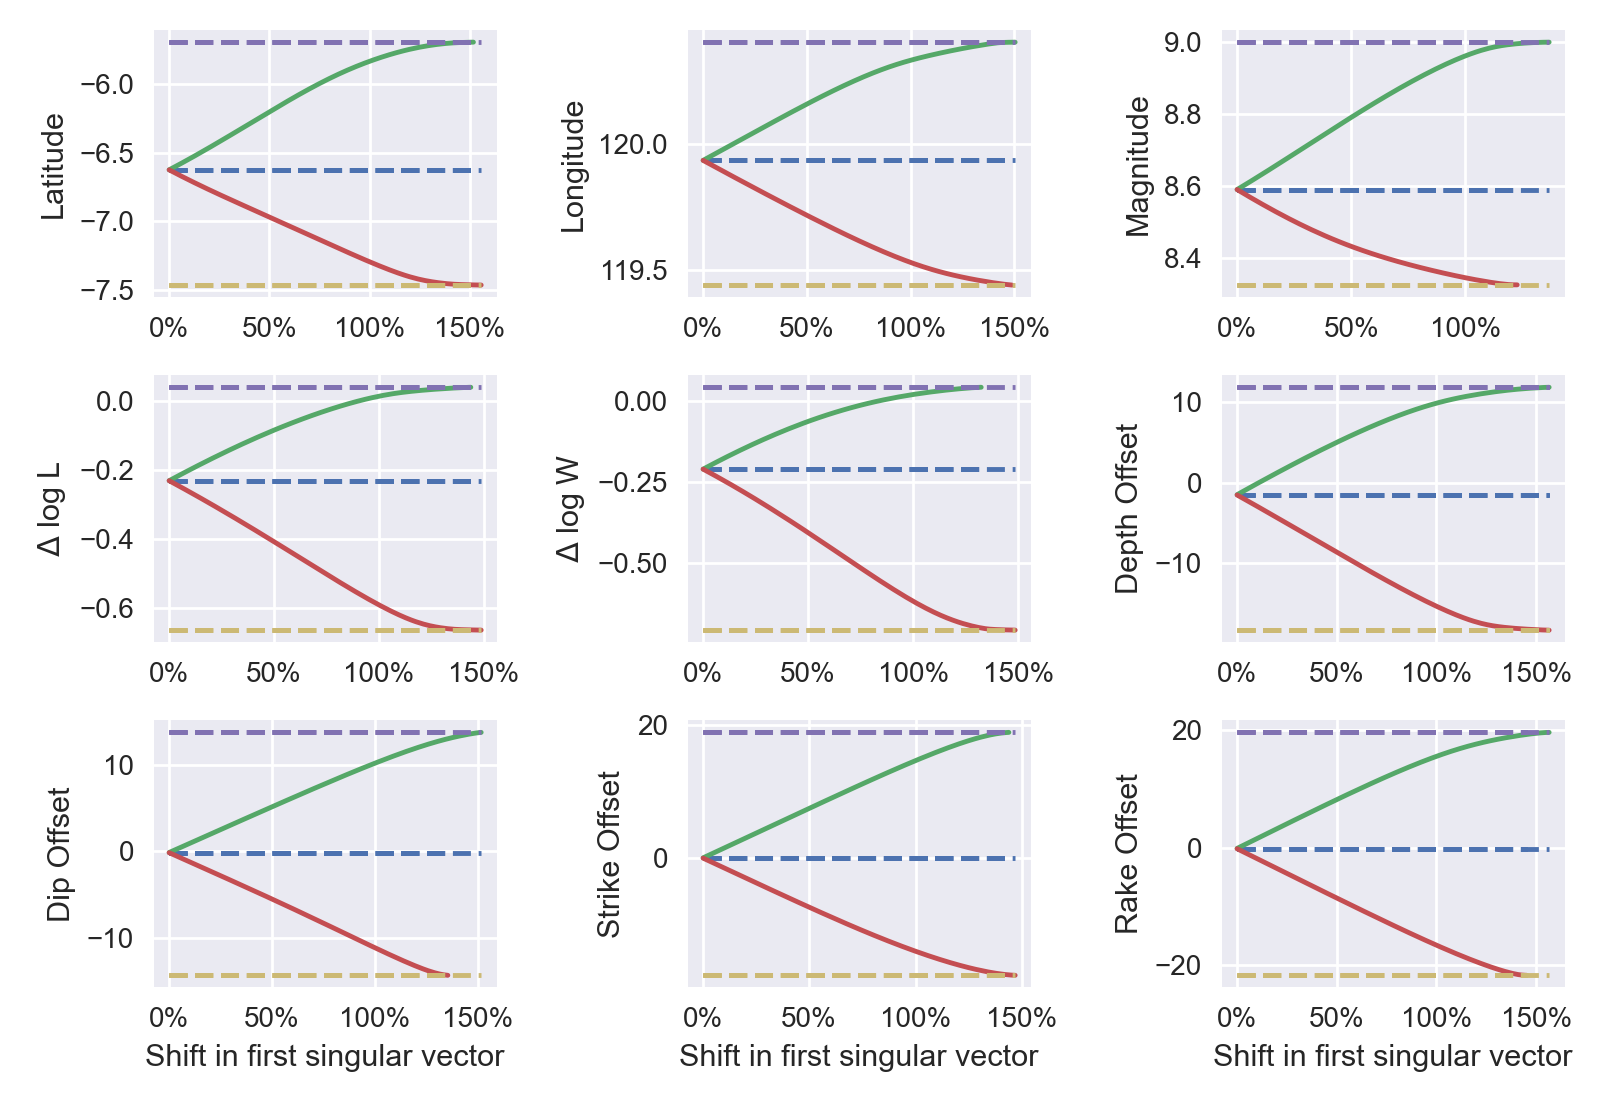

In [46]:
#regenerate the upper/lower bound figure, but in terms of shift by alpha*v_1, 
#where v_1 is the first singular vector

au = np.sqrt(2*wal_Ru/s[0])*100
al = np.sqrt(2*wal_Rl/s[0])*100

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

fig,axs = plt.subplots(3,3)
ylabs = [col.title() for col in cols];
ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset";
ylabs[6]="Dip Offset"; ylabs[7]="Strike Offset"; ylabs[8]="Rake Offset";
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    alph = np.concatenate((al[:,j],au[:,j]))
    ax.plot(alph,EPf[j]*np.ones_like(alph),'--',label='Mean')
    ax.plot(au[:,j],ub[:,j],label='Upper bound')
    ax.plot(al[:,j],lb[:,j],label='Lower bound')
    ax.plot(alph,fmax[j]*np.ones_like(R),'--',label='Max')
    ax.plot(alph,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>5:
        ax.set(xlabel='Shift in first singular vector')
#     ax.set_xlim(0, 25)
    ax.xaxis.set_major_formatter(xticks)

plt.tight_layout()
plt.savefig('walanae_dupuis211_sv1.png')
plt.savefig('walanae_dupuis211_sv1.pdf')
plt.show()

<IPython.core.display.Javascript object>


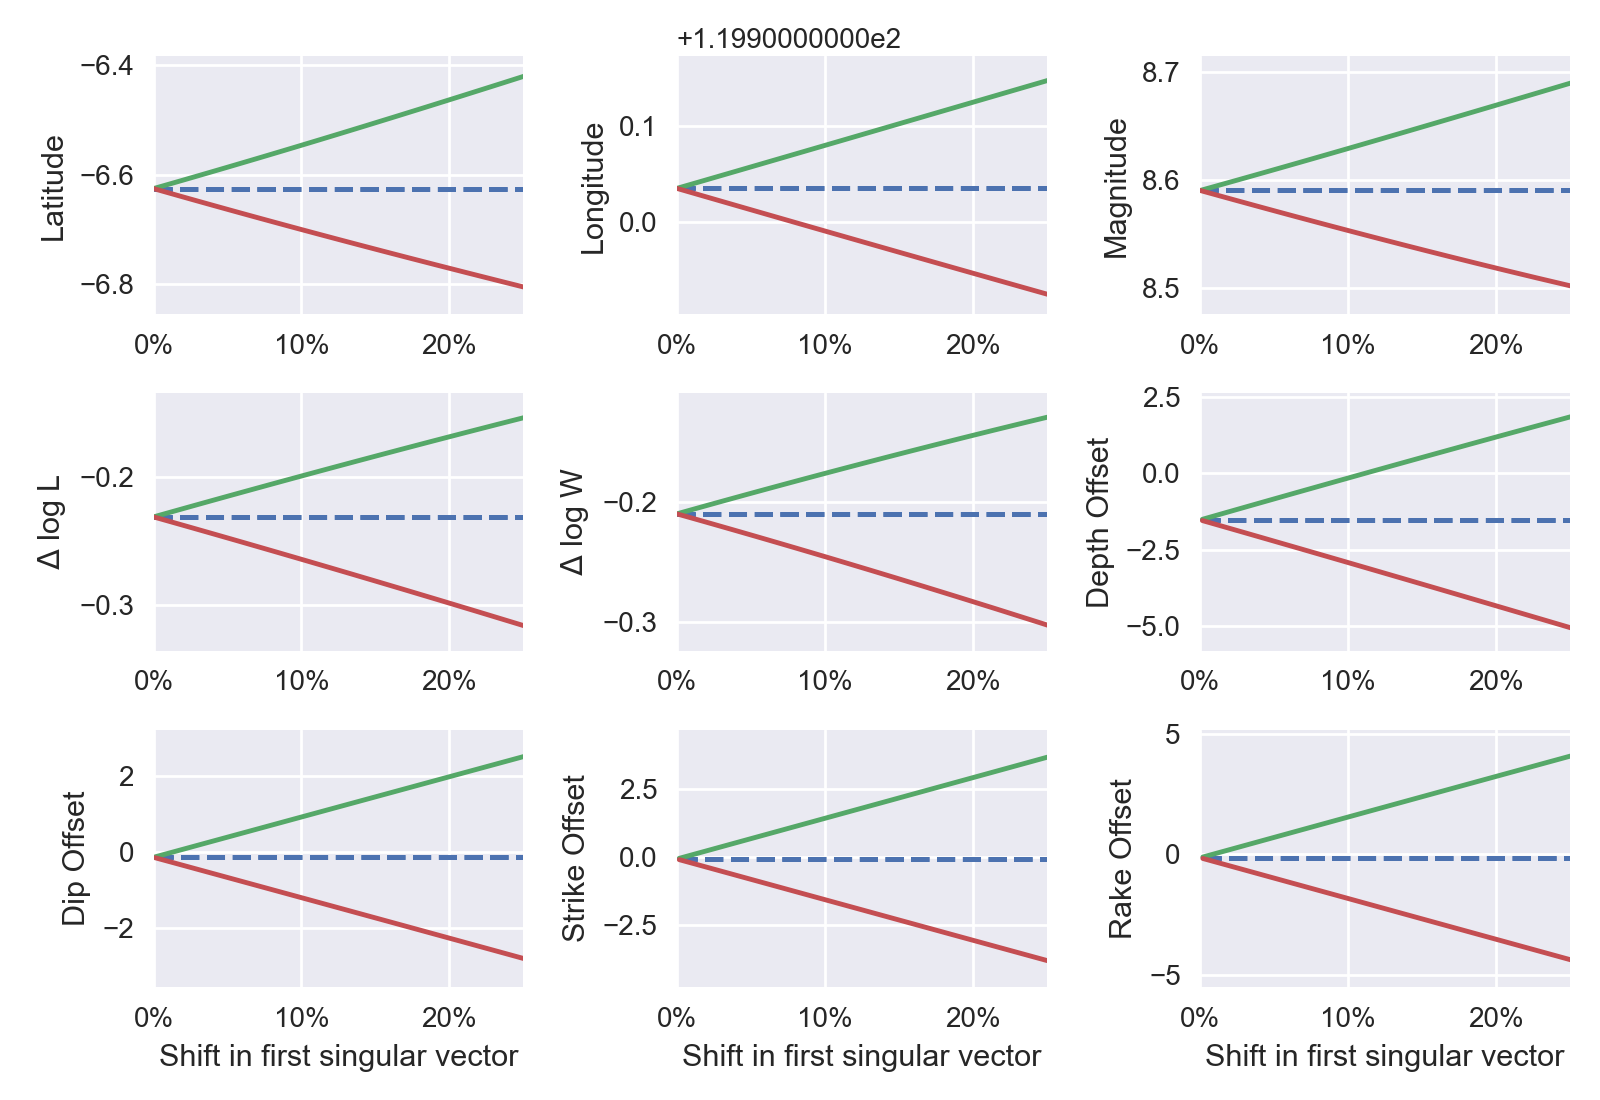

In [47]:
#regenerate the upper/lower bound figure, but in terms of shift by alpha*v_1, 
#where v_1 is the first singular vector

au = np.sqrt(2*wal_Ru/s[0])*100
al = np.sqrt(2*wal_Rl/s[0])*100
xmax = 25

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

fig,axs = plt.subplots(3,3)
ylabs = [col.title() for col in cols];
ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset";
ylabs[6]="Dip Offset"; ylabs[7]="Strike Offset"; ylabs[8]="Rake Offset";
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    idxu  = au[:,j]<=xmax+5
    idxl  = al[:,j]<=xmax+5
    alph = np.concatenate((al[:,j],au[:,j]))
    ax.plot(alph,EPf[j]*np.ones_like(alph),'--',label='Mean')
    ax.plot(au[idxu,j],ub[idxu,j],label='Upper bound')
    ax.plot(al[idxl,j],lb[idxl,j],label='Lower bound')
#     ax.plot(alph,fmax[j]*np.ones_like(R),'--',label='Max')
#     ax.plot(alph,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>5:
        ax.set(xlabel='Shift in first singular vector')
    ax.set_xlim(0, xmax)
    ax.xaxis.set_major_formatter(xticks)

plt.tight_layout()
plt.savefig('walanae_dupuis211_sv1.png')
plt.savefig('walanae_dupuis211_sv1.pdf')
plt.show()

In [48]:
#Get a particular attribute and stack it into a single array
attr='magnitude'
nthin=1   #optional thinning to reduce computational cost during testing

f = np.concatenate([ flores_samples[attr].values ])
#f = np.concatenate([ walane_samples[attr].values ])
f = f[::nthin]
len(f)

127690

In [49]:
#Equations (2.9) and (2.10)

c = 1

EPf = f.mean() #E_P[f]
expCdelF = np.exp( c*(f-EPf) )  #e^{c*(f-E_P[f])}
ubT1 =  np.log(    expCdelF.mean())/c #1st term of 2.9  (upper bound)
lbT1 = -np.log((1/expCdelF).mean())/c #1st term of 2.10 (lower bound)

print('range on E('+attr+') from variance in posterior is: ['+str(EPf+lbT1)+', '+str(EPf+ubT1)+']')
print('**note that this ignores the R(Q||P) term**')

range on E(magnitude) from variance in posterior is: [8.749591989990874, 8.771157797072563]
**note that this ignores the R(Q||P) term**


/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2955131920.py:17: RuntimeWarning: overflow encountered in exp
  ub[i,j] = EPf + (np.log((np.exp(  c*ft )).mean())+R)/c  #e^{ c*(f-E_P[f])}
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<IPython.core.display.Javascript object>


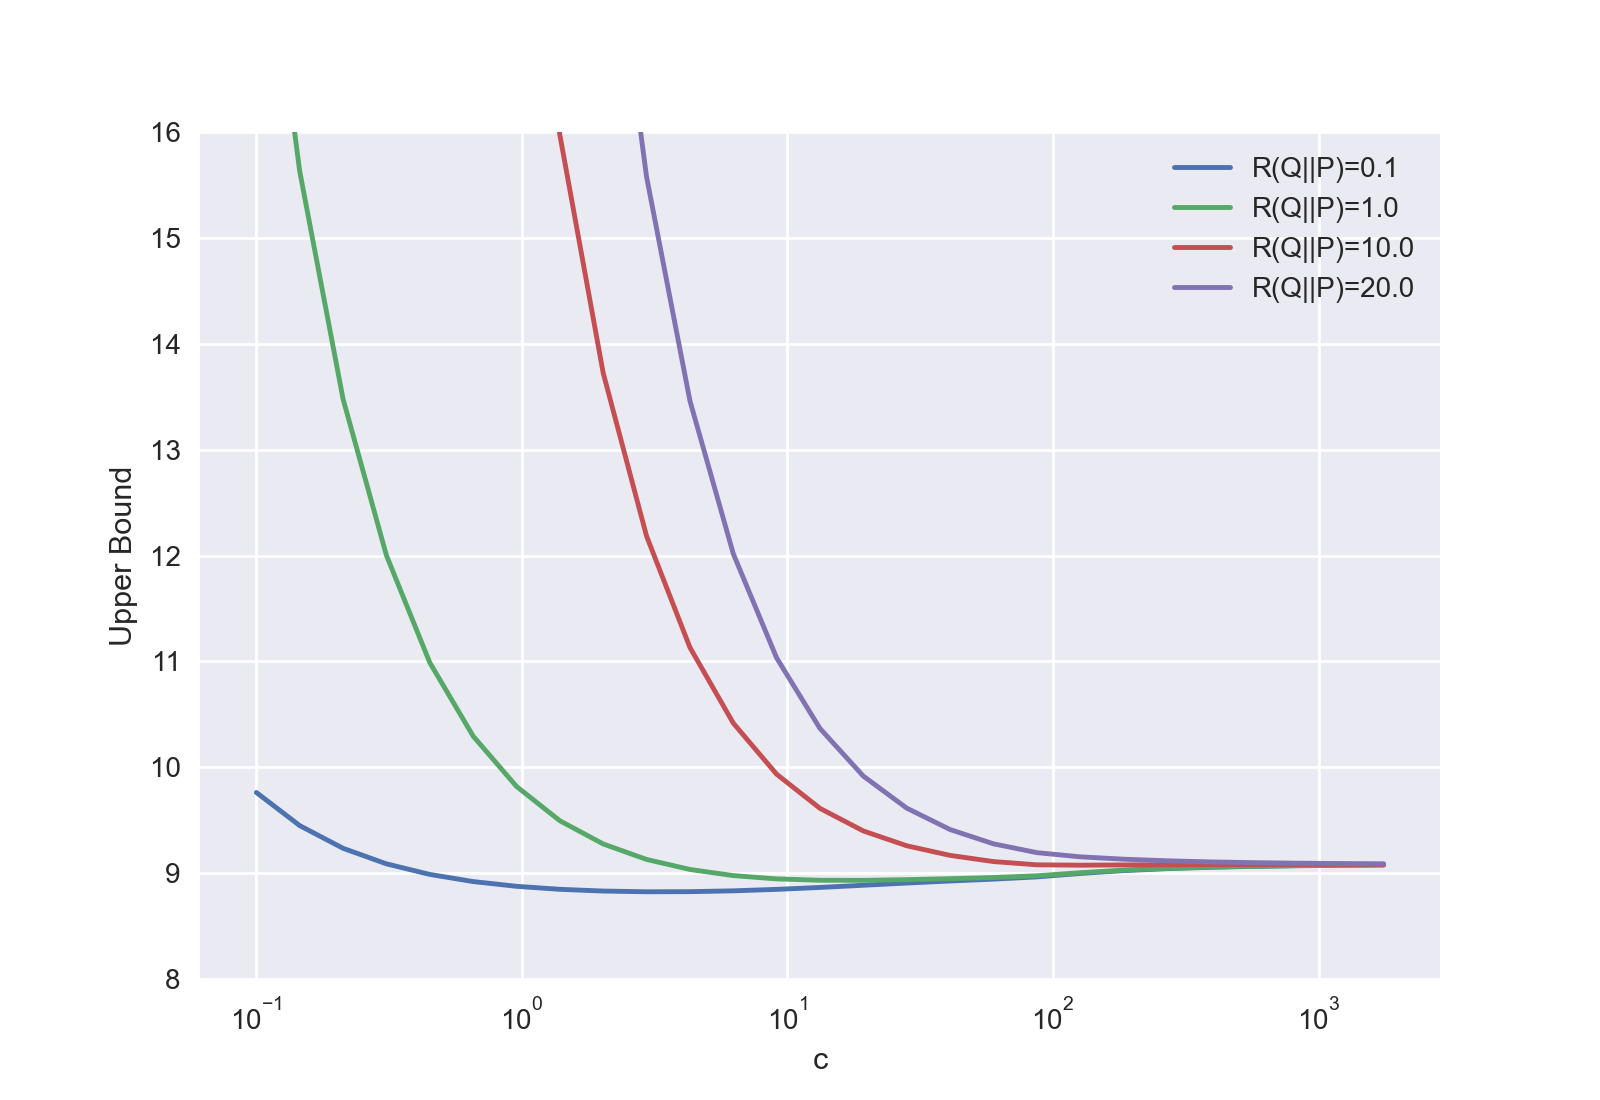

In [50]:
#Show the relationship between the upper bound and c for changing R 

#list of c's to try
#cs = np.power(10.0,np.arange(-3,3))
cs = np.logspace(-1,7)
Rs = [0.1,1.0,10.0,20.0]

#precompute some things
EPf = f.mean() #E_P[f]
ft  = f-EPf    #deviation from mean

#preallocate some other things
ub = np.zeros((len(cs),len(Rs)))

for i,c in enumerate(cs):
    for j,R in enumerate(Rs):
        ub[i,j] = EPf + (np.log((np.exp(  c*ft )).mean())+R)/c  #e^{ c*(f-E_P[f])}

#plot
fig = plt.figure()
plt.semilogx(cs,ub)
plt.legend(['R(Q||P)='+str(R) for R in Rs])
plt.xlabel('c')
plt.ylabel('Upper Bound')
plt.ylim(8,16)
plt.show()

In [51]:
#Compute the optimal R for each c using Justin's method

#list of c's to try
#cs = np.power(10.0,np.arange(-3,3))
cs = np.logspace(-1,7)

#precompute some things
EPf = f.mean() #E_P[f]
ft  = f-EPf    #deviation from mean

#preallocate some other things
ub = np.zeros(len(cs))
lb = np.zeros(len(cs))
flo_Ru = np.zeros(len(cs))
flo_Rl = np.zeros(len(cs))

for i,c in enumerate(cs):
    exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
    expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
    E1u = exppCft.mean()
    E2u = (ft*exppCft).mean()
    E1l = expmCft.mean()
    E2l = (ft*expmCft).mean()
    #print(i,c,E1u,E2u,E1l,E2l)
    flo_Ru[i] =  c*(E2u/E1u) - np.log(E1u)
    flo_Rl[i] = -c*(E2l/E1l) - np.log(E1l)
    ub[i] = EPf + (E2u/E1u)
    lb[i] = EPf + (E2l/E1l)


/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2407418720.py:19: RuntimeWarning: overflow encountered in exp
  expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2407418720.py:26: RuntimeWarning: invalid value encountered in double_scalars
  flo_Rl[i] = -c*(E2l/E1l) - np.log(E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2407418720.py:28: RuntimeWarning: invalid value encountered in double_scalars
  lb[i] = EPf + (E2l/E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2407418720.py:18: RuntimeWarning: overflow encountered in exp
  exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2407418720.py:25: RuntimeWarning: invalid value encounter

<IPython.core.display.Javascript object>


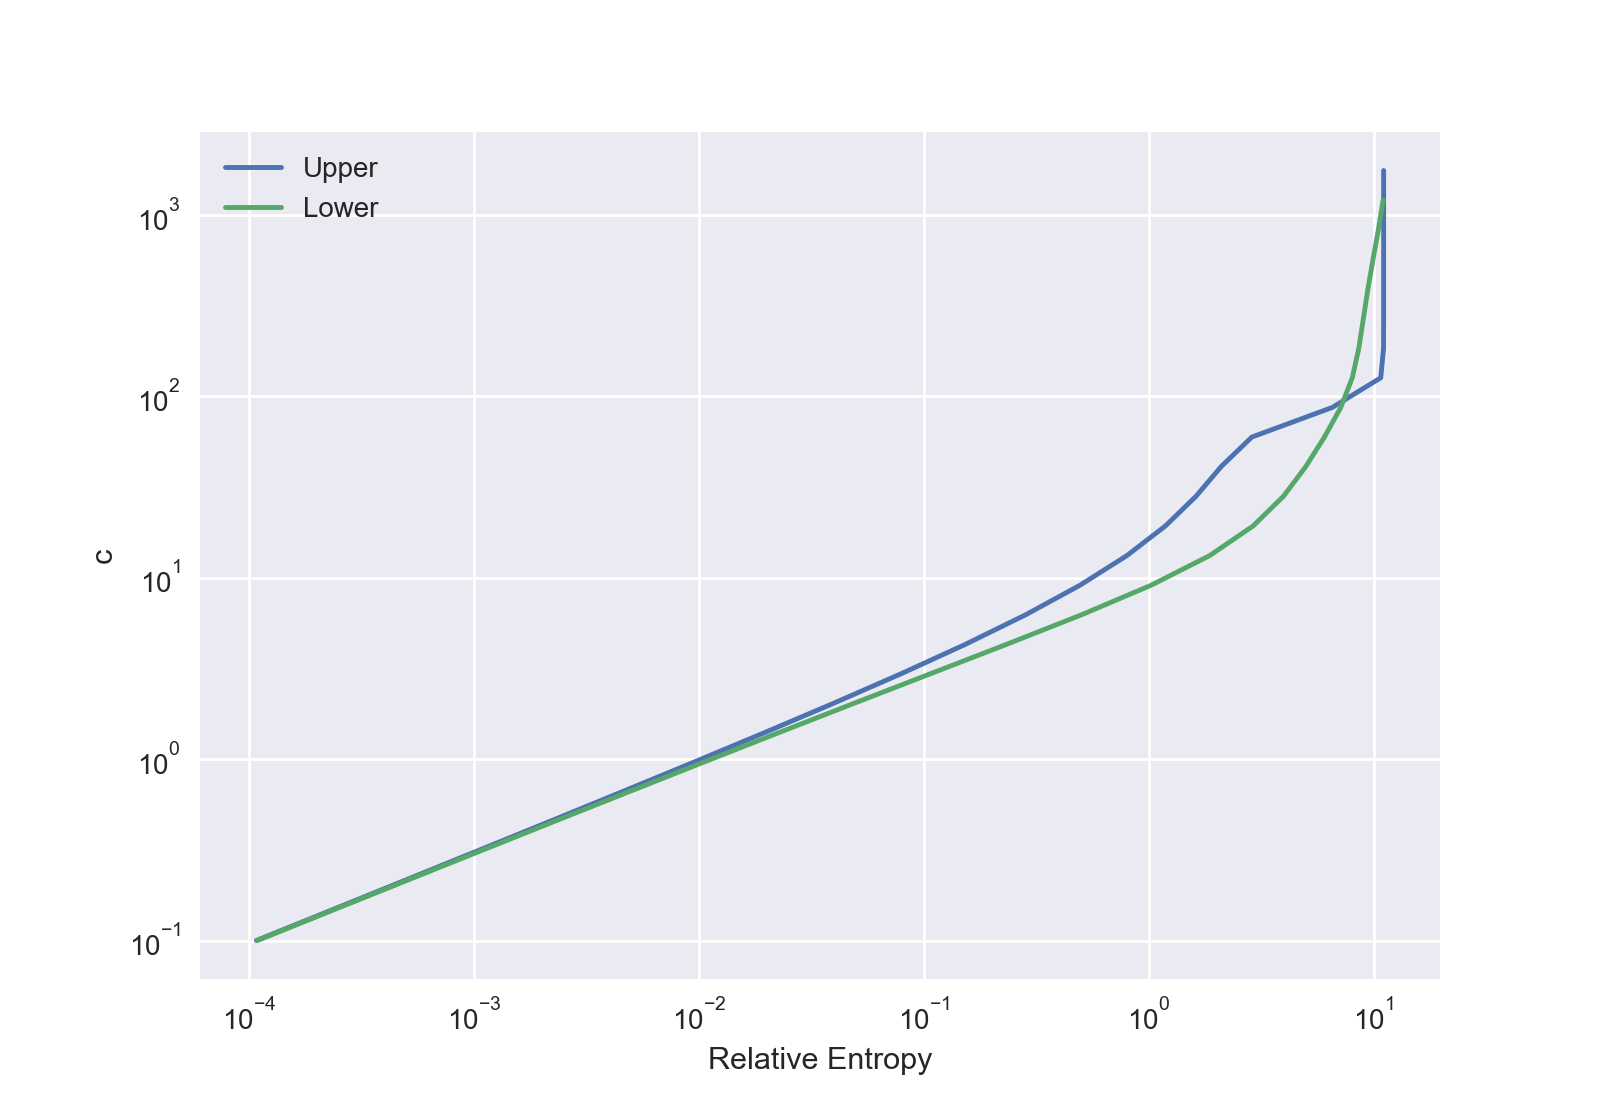

In [52]:
fig = plt.figure()
plt.loglog(flo_Ru,cs,label="Upper")
plt.loglog(flo_Rl,cs,label="Lower")
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('c')
plt.show()

<IPython.core.display.Javascript object>


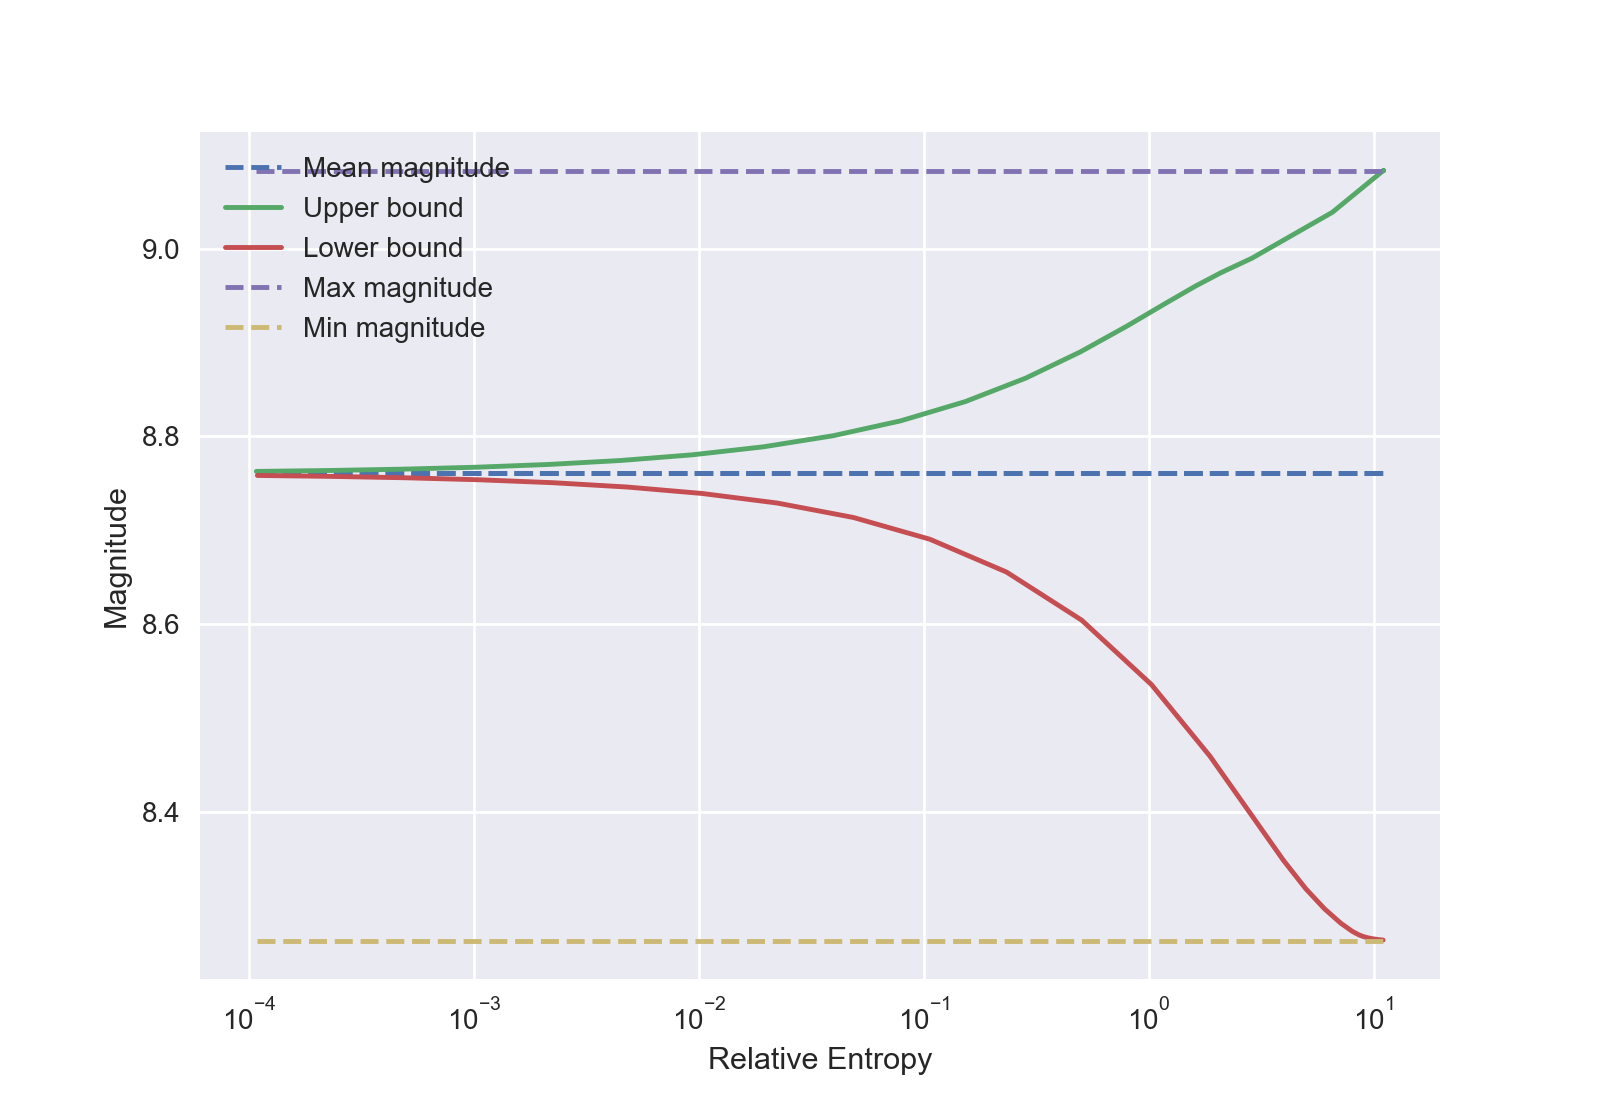

In [53]:
fig = plt.figure()
R = np.concatenate((flo_Rl,flo_Ru))
plt.semilogx(R,EPf*np.ones_like(R),'--',label='Mean '+attr)
plt.semilogx(flo_Ru,ub,label='Upper bound')
plt.semilogx(flo_Rl,lb,label='Lower bound')
plt.semilogx(flo_Ru,f.max()*np.ones(len(flo_Ru)),'--',label='Max '+attr)
plt.semilogx(flo_Rl,f.min()*np.ones(len(flo_Ru)),'--',label='Min '+attr)
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.savefig('flores_magnitude_log_entropy_bounds.pdf')
plt.show()

<IPython.core.display.Javascript object>


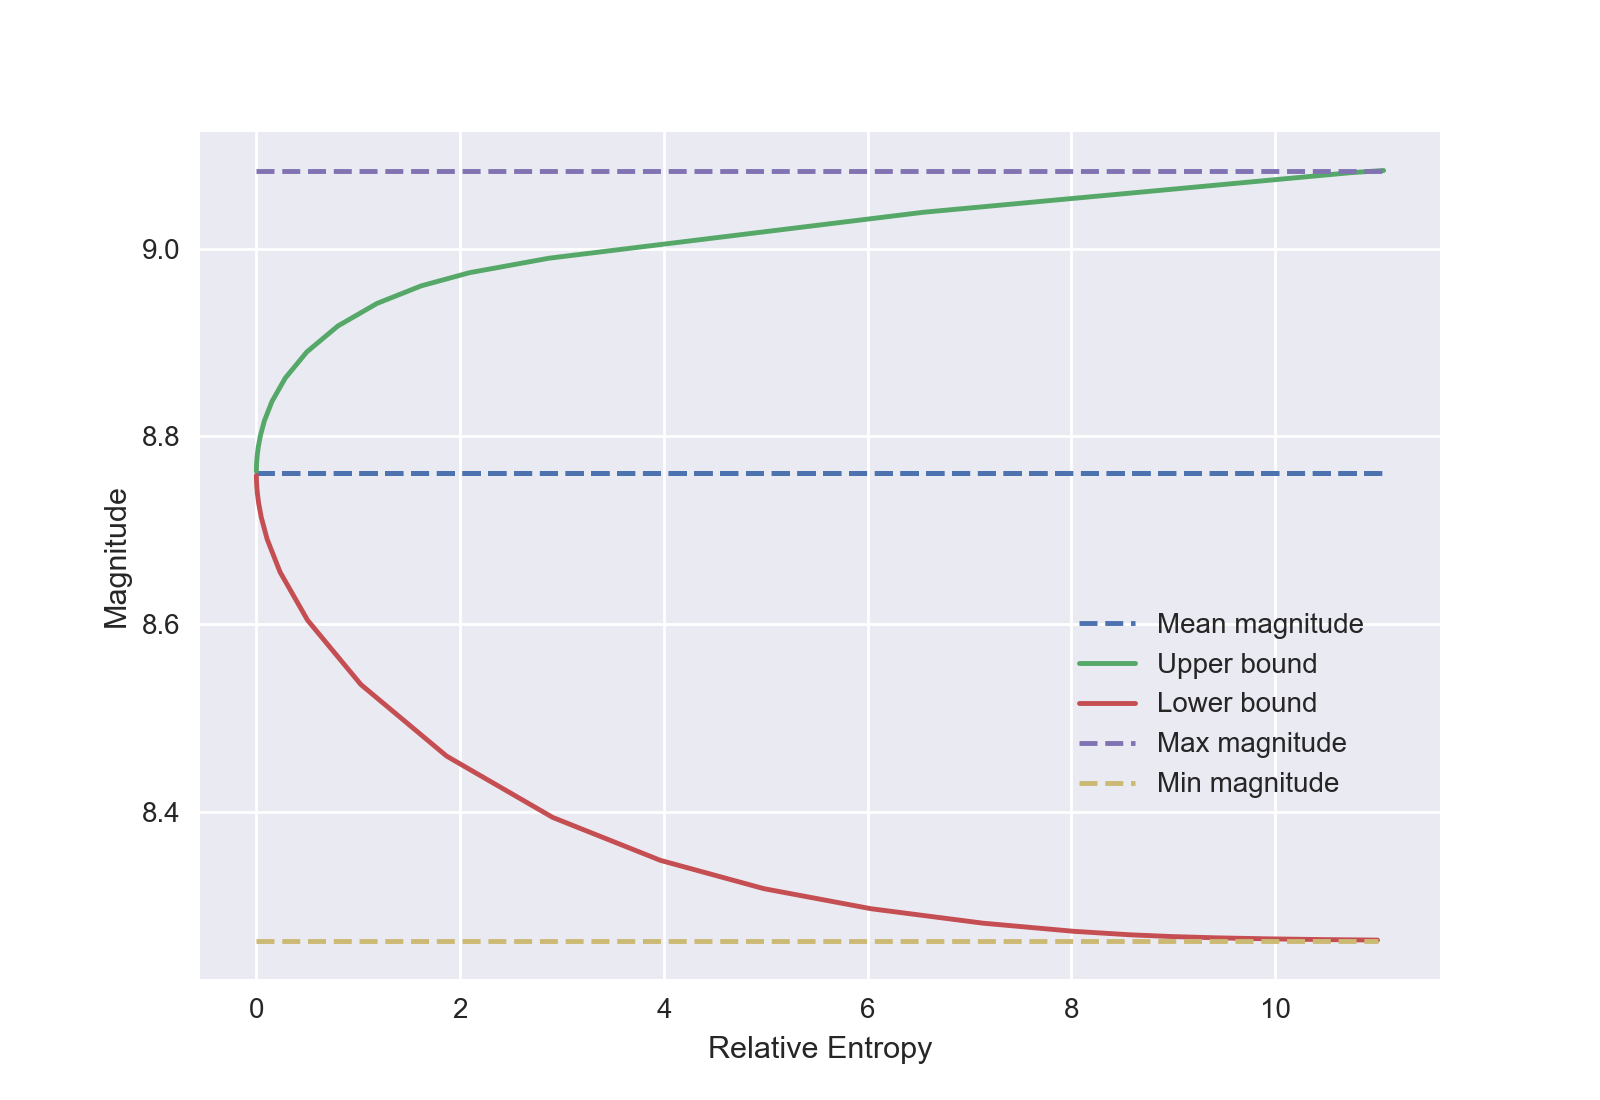

In [54]:
fig = plt.figure()
R = np.concatenate((flo_Rl,flo_Ru))
plt.plot(R,EPf*np.ones_like(R),'--',label='Mean '+attr)
plt.plot(flo_Ru,ub,label='Upper bound')
plt.plot(flo_Rl,lb,label='Lower bound')
plt.plot(flo_Ru,f.max()*np.ones_like(flo_Ru),'--',label='Max '+attr)
plt.plot(flo_Rl,f.min()*np.ones_like(flo_Rl),'--',label='Min '+attr)
plt.legend(loc=(0.7,0.2))
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.savefig('flores_magnitude_entropy_bounds.pdf')
plt.show()

In [55]:
nthin=1   #optional thinning to reduce computational cost during testing

#list of c's to try
cs = np.logspace(-3,7, num=200)

cols = samples[0].columns[:-1]
ncol = len(cols)

#preallocate some things
ub  = np.zeros((len(cs),ncol))
lb  = np.zeros((len(cs),ncol))
flo_Ru  = np.zeros((len(cs),ncol))
flo_Rl  = np.zeros((len(cs),ncol))
EPf = np.zeros(ncol)
fmax = np.zeros(ncol)
fmin = np.zeros(ncol)

for j,attr in enumerate(cols):
    f = flores_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]

    #Compute the optimal R for each c using Justin's method

    #precompute some things
    EPf[j] = f.mean() #E_P[f]
    ft  = f-EPf[j]    #deviation from mean

    for i,c in enumerate(cs):
        exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
        expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
        E1u = exppCft.mean()
        E2u = (ft*exppCft).mean()
        E1l = expmCft.mean()
        E2l = (ft*expmCft).mean()
        #print(i,c,E1u,E2u,E1l,E2l)
        flo_Ru[i,j] =  c*(E2u/E1u) - np.log(E1u)
        flo_Rl[i,j] = -c*(E2l/E1l) - np.log(E1l)
        ub[i,j] = EPf[j] + (E2u/E1u)
        lb[i,j] = EPf[j] + (E2l/E1l)
    
    fmax[j] = f.max()
    fmin[j] = f.min()

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3974983666.py:31: RuntimeWarning: overflow encountered in exp
  expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3974983666.py:38: RuntimeWarning: invalid value encountered in double_scalars
  flo_Rl[i,j] = -c*(E2l/E1l) - np.log(E1l)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3974983666.py:40: RuntimeWarning: invalid value encountered in double_scalars
  lb[i,j] = EPf[j] + (E2l/E1l)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3974983666.py:30: RuntimeWarning: overflow encountered in exp
  exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/3974983666.py:37: RuntimeWarning: invalid value en

<IPython.core.display.Javascript object>


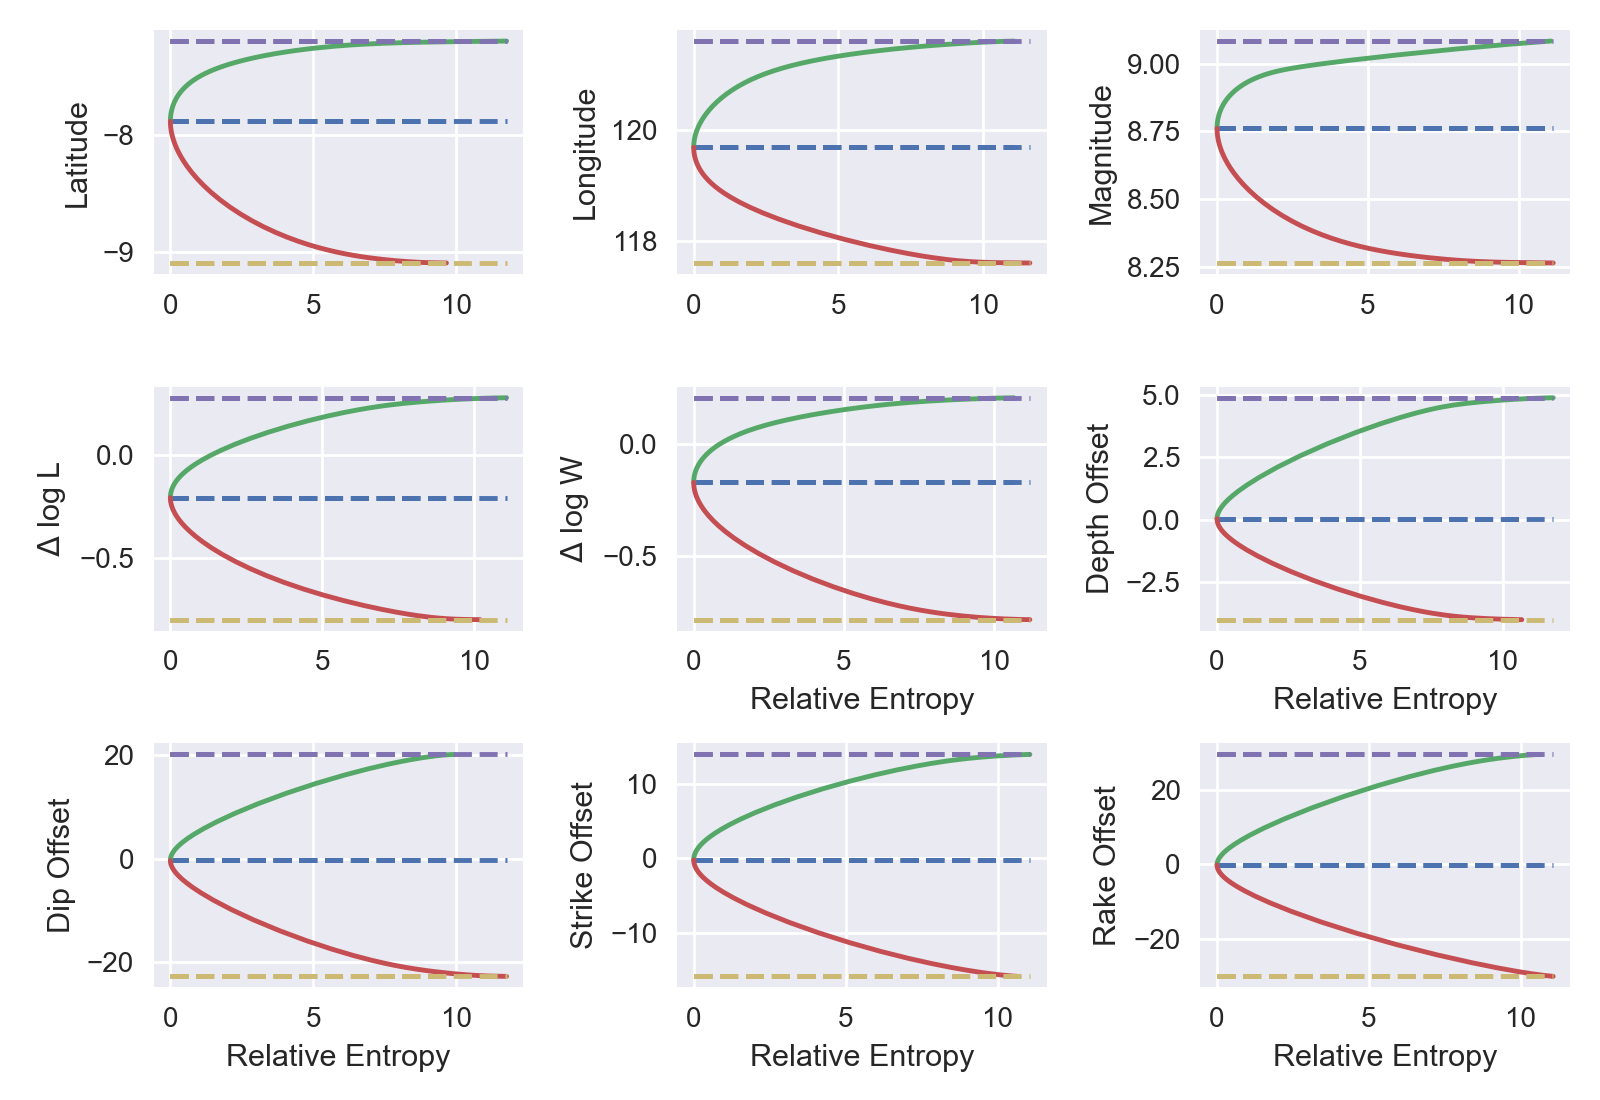

In [56]:
fig,axs = plt.subplots(3,3)
ylabs = [col.title() for col in cols];
ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset";
ylabs[6]="Dip Offset"; ylabs[7]="Strike Offset"; ylabs[8]="Rake Offset";
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    R = np.concatenate((flo_Rl[:,j],flo_Ru[:,j]))
    ax.plot(R,EPf[j]*np.ones_like(R),'--',label='Mean')
    ax.plot(flo_Ru[:,j],ub[:,j],label='Upper bound')
    ax.plot(flo_Rl[:,j],lb[:,j],label='Lower bound')
    ax.plot(R,fmax[j]*np.ones_like(R),'--',label='Max')
    ax.plot(R,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>3:
        ax.set(xlabel='Relative Entropy')

plt.tight_layout()
plt.savefig('dupuis_Flores.png')
plt.savefig('dupuis_Flores.pdf')
plt.show()

In [57]:
#Now Flores
#this computes the diagonal components
nthin = 1 #optional thinning of model outputs

FIM = pd.DataFrame(columns = ['Name', 'Observation', 'Distribution', 'Parameter', 'Fisher Information'])
for location in dists:
    for key in ['arrival','height']:
        if key in location:
            dist=location[key]
            attr=location['name']+' '+key
            G = flores_model_output[attr].values
#            G = np.concatenate([ df[attr].values for df in model_output ])
            print(G)
            G = G[::nthin]

            #normal distribution
            if isinstance(dist.dist, stats._continuous_distns.norm_gen) or isinstance(dist.dist, stats._continuous_distns.truncnorm_gen):
                m = dist.__dict__['kwds']['loc'] #dist.mean()
                sigma = dist.__dict__['kwds']['scale'] #dist.std()
                #print('Found normal at',attr,'with mean',m,'and std',sigma)
                fimm = fimNormaldMean(G,m,sigma)
                fims = fimNormaldStd(G,m,sigma)
                #print('dNdm =',dNdm,', dNds =',dNds)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'mean', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'std', 'Fisher Information' : fims }, 
                    ignore_index = True)
            
            #skewnorm distribution
            elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
                m = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                a = dist.__dict__['kwds']['a']
                #print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
                fimm = fimSkewnormdMean(G,m,sigma,a)
                fims = fimSkewnormdStd(G,m,sigma,a)
                fima = fimSkewnormdA(G,m,sigma,a)
                #print('dSNdm =',dNdm,', dSNds =',dNds, ', dSNda = TBD ;-)')
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'mean', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'std', 'Fisher Information' : fims }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'a', 'Fisher Information' : fima }, 
                    ignore_index = True)
            
            #chi distribution
            elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
                mu = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                dof = dist.__dict__['kwds']['df']
                #print('Found chi at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
                fimm = fimChidMu(G,mu,sigma,dof)
                fims = fimChidSigma(G,mu,sigma,dof)
                fimk = fimChidK(G,mu,sigma,dof)
                #print('dChidm =',dChidm,', dChids =',dChids, ', dChidk =',dChidk)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'mu', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'sigma', 'Fisher Information' : fims }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'dof', 'Fisher Information' : fimk }, 
                    ignore_index = True)
            #other
            else:
                print('ERROR: Distribution for',attr,'not found')

FIM

[47.23018944 47.61467167 47.61467167 ... 47.19922722 47.19922722
 46.68314778]
[2.55864703 2.0043386  2.0043386  ... 4.13740072 4.13740072 4.32865201]
[140.53358667 147.18565667 147.18565667 ... 180.59090556 180.59090556
 176.51138889]
[1.47514158 1.21519111 1.21519111 ... 0.79301186 0.79301186 0.98184285]
[1.50891217 1.07780133 1.07780133 ... 2.36375577 2.36375577 2.63789397]
[3.10493137 2.28033361 2.28033361 ... 2.6643592  2.6643592  2.73886973]


/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2718295494.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2718295494.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2718295494.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/2718295494.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIM = FIM.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykern

Name Observation Distribution Parameter Fisher Information
0   Bulukumba     arrival       normal      mean           0.000653
1   Bulukumba     arrival       normal       std           0.027227
2   Bulukumba      height       normal      mean           0.006315
3   Bulukumba      height       normal       std           0.132211
4     Sumenep     arrival       normal      mean           0.000042
5     Sumenep     arrival       normal       std           0.000547
6     Sumenep      height       normal      mean           0.213569
7     Sumenep      height       normal       std           0.071982
8   Nipa-Nipa      height       normal      mean            0.11602
9   Nipa-Nipa      height       normal       std           0.261679
10       Bima      height       normal      mean            0.01253
11       Bima      height       normal       std           0.067985

In [58]:
#Compute sensitivity bounds from equation (2.39)

nthin = 1 #optional thinning of sample data

sensDF = FIM.copy()

cols = samples[0].columns[:-1]
ncol = len(cols)

for j,attr in enumerate(cols):
    print(attr)
    f = flores_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    print('Variance for',attr,'is:',fvar)
    
    #Equation (2.39)
    #print(np.sqrt(np.array(sensDF['Fisher Information'], dtype=np.float64)))
    sensDF['S_'+attr] = np.sqrt(fvar*np.array(sensDF['Fisher Information'], dtype=np.float64))

sensDF

latitude
Variance for latitude is: 0.10855730991950274
longitude
Variance for longitude is: 0.402421509271959
magnitude
Variance for magnitude is: 0.021576565510160805
delta_logl
Variance for delta_logl is: 0.018108666468946606
delta_logw
Variance for delta_logw is: 0.02077211407452359
depth_offset
Variance for depth_offset is: 0.6478699484381423
dip_offset
Variance for dip_offset is: 13.573413035715923
strike_offset
Variance for strike_offset is: 8.498352498418908
rake_offset
Variance for rake_offset is: 22.2721182355671


Name Observation Distribution Parameter Fisher Information  \
0   Bulukumba     arrival       normal      mean           0.000653   
1   Bulukumba     arrival       normal       std           0.027227   
2   Bulukumba      height       normal      mean           0.006315   
3   Bulukumba      height       normal       std           0.132211   
4     Sumenep     arrival       normal      mean           0.000042   
5     Sumenep     arrival       normal       std           0.000547   
6     Sumenep      height       normal      mean           0.213569   
7     Sumenep      height       normal       std           0.071982   
8   Nipa-Nipa      height       normal      mean            0.11602   
9   Nipa-Nipa      height       normal       std           0.261679   
10       Bima      height       normal      mean            0.01253   
11       Bima      height       normal       std           0.067985   

    S_latitude  S_longitude  S_magnitude  S_delta_logl  S_delta_logw  \
0     0.008421     0.016214     0.003754      0.003440      0.003684   
1     0.054366     0.104674     0.024238      0.022205      0.023781   
2     0.026183     0.050411     0.011673      0.010694      0.011453   
3     0.119802     0.230661     0.053410      0.048930      0.052405   
4     0.002131     0.004103     0.000950      0.000870      0.000932   
5     0.007706     0.014837     0.003435      0.003147      0.003371   
6     0.152265     0.293164     0.067883      0.062189      0.066605   
7     0.088398     0.170198     0.039410      0.036104      0.038668   
8     0.112227     0.216076     0.050033      0.045836      0.049092   
9     0.168544     0.324508     0.075141      0.068838      0.073727   
10    0.036881     0.071009     0.016442      0.015063      0.016133   
11    0.085909     0.165405     0.038300      0.035087      0.037579   

    S_depth_offset  S_dip_offset  S_strike_offset  S_rake_offset  
0         0.020573      0.094167         0.074511       0.120624  
1         0.132814      0.607915         0.481023       0.778716  
2         0.063963      0.292773         0.231661       0.375031  
3         0.292670      1.339610         1.059988       1.715989  
4         0.005206      0.023828         0.018854       0.030522  
5         0.018825      0.086166         0.068181       0.110376  
6         0.371975      1.702605         1.347215       2.180973  
7         0.215952      0.988457         0.782133       1.266176  
8         0.274164      1.254904         0.992964       1.607485  
9         0.411745      1.884642         1.491255       2.414155  
10        0.090098      0.412399         0.326318       0.528268  
11        0.209870      0.960619         0.760106       1.230517

In [59]:
print(sensDF.to_latex(index=False,formatters={
    'Fisher Information' : '{:.1e}'.format,
    'S_latitude'         : '{:.3f}'.format,
    'S_longitude'        : '{:.3f}'.format,
    'S_magnitude'        : '{:.3f}'.format,
    'S_delta_logl'       : '{:.3f}'.format,
    'S_delta_logw'       : '{:.3f}'.format,
    'S_depth_offset'     : '{:.3f}'.format,
    'S_dip_offset'       : '{:.3f}'.format,
    'S_strike_offset'    : '{:.3f}'.format,
    'S_rake_offset'      : '{:.3f}'.format,
    }))

\begin{tabular}{lllllrrrrrrrrr}
\toprule
     Name & Observation & Distribution & Parameter & Fisher Information & S\_latitude & S\_longitude & S\_magnitude & S\_delta\_logl & S\_delta\_logw & S\_depth\_offset & S\_dip\_offset & S\_strike\_offset & S\_rake\_offset \\
\midrule
Bulukumba &     arrival &       normal &      mean &           0.000653 &      0.008 &       0.016 &       0.004 &        0.003 &        0.004 &          0.021 &        0.094 &           0.075 &         0.121 \\
Bulukumba &     arrival &       normal &       std &           0.027227 &      0.054 &       0.105 &       0.024 &        0.022 &        0.024 &          0.133 &        0.608 &           0.481 &         0.779 \\
Bulukumba &      height &       normal &      mean &           0.006315 &      0.026 &       0.050 &       0.012 &        0.011 &        0.011 &          0.064 &        0.293 &           0.232 &         0.375 \\
Bulukumba &      height &       normal &       std &           0.132211 &      0.120 & 

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1471251123.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sensDF.to_latex(index=False,formatters={


In [60]:
#compute the derivatives for each distribution parameter
nthin = 1 #optional thinning of model outputs

derivs = pd.DataFrame(columns = ['Name', 'Observation', 'Distribution', 'Parameter', 'Value', 'Derivative'])
for location in dists:
    for key in ['arrival','height']:
        if key in location:
            dist=location[key]
            attr=location['name']+' '+key
            G = flores_model_output[attr].values
#            G = np.concatenate([ df[attr].values for df in model_output ])
            G = G[::nthin]

            #normal distribution
            if isinstance(dist.dist, stats._continuous_distns.norm_gen) or isinstance(dist.dist, stats._continuous_distns.truncnorm_gen):
                m = dist.__dict__['kwds']['loc'] #dist.mean()
                sigma = dist.__dict__['kwds']['scale'] #dist.std()
                #print('Found normal at',attr,'with mean',m,'and std',sigma)
                dm = dNormalPhidMean(G,m,sigma)
                ds = dNormalPhidStd(G,m,sigma)
                #print('dNdm =',dm,', dNds =',ds)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'mean', 'Value' : m, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'std', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
            
            #skewnorm distribution
            elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
                m = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                a = dist.__dict__['kwds']['a']
                #print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
                dm = dSkewnormPhidMean(G,m,sigma,a)
                ds = dSkewnormPhidStd(G,m,sigma,a)
                da = dSkewnormPhidA(G,m,sigma,a)
                #print('dSNdm =',dm,', dSNds =',ds, ', dSNda =',da)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'mean', 'Value' : m, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'std', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'a', 'Value' : a, 'Derivative' : da }, 
                    ignore_index = True)

            #chi distribution
            elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
                mu = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                dof = dist.__dict__['kwds']['df']
                #print('Found chi at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
                dm = dChiPhidMu(G,mu,sigma,dof)
                ds = dChiPhidSigma(G,mu,sigma,dof)
                dk = dChiPhidK(G,mu,sigma,dof)
                #print('dChidm =',dm,', dChids =',ds, ', dChidk =',dk)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'mu', 'Value' : mu, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'sigma', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'dof', 'Value' : dof, 'Derivative' : dk }, 
                    ignore_index = True)

            else:
                print('ERROR: Distribution for',attr,'not found')

derivs

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/85878834.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/85878834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/85878834.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/85878834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  derivs = derivs.append({
/var/folders/t5/qjwb246n55s_3764g3_yv8c4

Name Observation Distribution Parameter Value  \
0   Bulukumba     arrival       normal      mean    15   
1   Bulukumba     arrival       normal       std    10   
2   Bulukumba      height       normal      mean    18   
3   Bulukumba      height       normal       std     5   
4     Sumenep     arrival       normal      mean   240   
5     Sumenep     arrival       normal       std    45   
6     Sumenep      height       normal      mean   1.5   
7     Sumenep      height       normal       std     1   
8   Nipa-Nipa      height       normal      mean     3   
9   Nipa-Nipa      height       normal       std     2   
10       Bima      height       normal      mean    10   
11       Bima      height       normal       std     4   

                                           Derivative  
0   [-0.3223018944444443, -0.3261467166666667, -0....  
1   [-0.9387851116247771, -0.9637168079244699, -0....  
2   [0.6176541186933333, 0.63982645592, 0.63982645...  
3   [-1.7074830516941912, -1.8468894684757384, -1....  
4   [0.04911921646090534, 0.04583424362139918, 0.0...  
5   [-0.08634916193577512, -0.07231278275333748, -...  
6   [0.024858420333333298, 0.2848088866666669, 0.2...  
7   [0.9993820589385313, 0.9188838980756937, 0.918...  
8   [0.3727719583333333, 0.4805496666666667, 0.480...  
9   [0.2220821341606632, 0.03814403573311104, 0.03...  
10  [0.430941789375, 0.482479149375, 0.48247914937...  
11  [-0.49284330331890747, -0.6811445183264944, -0...

In [61]:
#get the full FIM
dMat = np.vstack(derivs['Derivative'])
fimFullAbs = np.cov(dMat)
fimDiagAbs = np.diagonal(fimFullAbs)
derivs['FI'] = fimDiagAbs
fimDiagAbs

array([6.53299213e-04, 2.72270414e-02, 6.31504156e-03, 1.32212003e-01,
       4.18289212e-05, 5.47002250e-04, 2.13571055e-01, 7.19830063e-02,
       1.16020731e-01, 2.61681055e-01, 1.25299758e-02, 6.79856031e-02])

In [62]:
#Convert FIM from absolute changes to relative changes
vals=np.array(derivs['Value'],dtype=float)
fimFull = np.diag(vals) @ fimFullAbs @ np.diag(vals)
fimDiag = np.diagonal(fimFull)

In [63]:
#size of perturbation for RE=1
derivs['FI Rel'] = fimDiag
derivs['Perturbation'] = np.sqrt(2/fimDiag)
#derivs['Rel Perturbation'] = derivs['Perturbation']/derivs['Value']
derivs['R 0.1'] = 0.5*fimDiag*(0.1**2)

#check that scaled FIM and absolute FIM produce the same RE=1 perturbations
print("norm difference between RE=1 relative perturbations computed with the absolute FIM and relative FIM is:", \
      np.linalg.norm( derivs['Perturbation'] - np.sqrt(2/fimDiagAbs)/vals ) )

derivs.loc[:, derivs.columns != 'Derivative']

norm difference between RE=1 relative perturbations computed with the absolute FIM and relative FIM is: 3.3306690738754696e-16


Name Observation Distribution Parameter Value        FI    FI Rel  \
0   Bulukumba     arrival       normal      mean    15  0.000653  0.146992   
1   Bulukumba     arrival       normal       std    10  0.027227  2.722704   
2   Bulukumba      height       normal      mean    18  0.006315  2.046073   
3   Bulukumba      height       normal       std     5  0.132212  3.305300   
4     Sumenep     arrival       normal      mean   240  0.000042  2.409346   
5     Sumenep     arrival       normal       std    45  0.000547  1.107680   
6     Sumenep      height       normal      mean   1.5  0.213571  0.480535   
7     Sumenep      height       normal       std     1  0.071983  0.071983   
8   Nipa-Nipa      height       normal      mean     3  0.116021  1.044187   
9   Nipa-Nipa      height       normal       std     2  0.261681  1.046724   
10       Bima      height       normal      mean    10  0.012530  1.252998   
11       Bima      height       normal       std     4  0.067986  1.087770   

    Perturbation     R 0.1  
0       3.688652  0.000735  
1       0.857067  0.013614  
2       0.988677  0.010230  
3       0.777875  0.016527  
4       0.911099  0.012047  
5       1.343717  0.005538  
6       2.040105  0.002403  
7       5.271085  0.000360  
8       1.383968  0.005221  
9       1.382289  0.005234  
10      1.263397  0.006265  
11      1.355959  0.005439

In [64]:
print(derivs.drop(['Derivative','FI'],axis=1).to_latex(index=False,formatters={
    'FI Rel' : '{:.3f}'.format,
    'Perturbation'          : '{:.3f}'.format,
    }))

\begin{tabular}{lllllrrr}
\toprule
     Name & Observation & Distribution & Parameter & Value & FI Rel & Perturbation &    R 0.1 \\
\midrule
Bulukumba &     arrival &       normal &      mean &    15 &  0.147 &        3.689 & 0.000735 \\
Bulukumba &     arrival &       normal &       std &    10 &  2.723 &        0.857 & 0.013614 \\
Bulukumba &      height &       normal &      mean &    18 &  2.046 &        0.989 & 0.010230 \\
Bulukumba &      height &       normal &       std &     5 &  3.305 &        0.778 & 0.016527 \\
  Sumenep &     arrival &       normal &      mean &   240 &  2.409 &        0.911 & 0.012047 \\
  Sumenep &     arrival &       normal &       std &    45 &  1.108 &        1.344 & 0.005538 \\
  Sumenep &      height &       normal &      mean &   1.5 &  0.481 &        2.040 & 0.002403 \\
  Sumenep &      height &       normal &       std &     1 &  0.072 &        5.271 & 0.000360 \\
Nipa-Nipa &      height &       normal &      mean &     3 &  1.044 &        1.384 

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/485961333.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(derivs.drop(['Derivative','FI'],axis=1).to_latex(index=False,formatters={


In [65]:
#svd
u, s, vh = np.linalg.svd(fimFull)
#checks
print("||u-v||             =",np.linalg.norm(u-vh.T))
print("||M*u_1 - s_1 u_1|| =",np.linalg.norm(np.matmul(fimFull,u[:,0]) - s[0]*u[:,0]))
#print s
print("singular values:")
display(s)
print("leading singular vector:")
display(u[:,0])

||u-v||             = 2.596703015774933e-13
||M*u_1 - s_1 u_1|| = 4.3430381182238394e-15
singular values:


array([8.02606354e+00, 4.09367492e+00, 2.39479922e+00, 1.29863693e+00,
       5.41275659e-01, 2.20823159e-01, 6.49556174e-02, 4.11109744e-02,
       3.03441751e-02, 7.71866082e-03, 2.54475041e-03, 3.43723243e-04])

leading singular vector:


array([-0.06206281, -0.26288093,  0.49389268, -0.62424604,  0.09259486,
       -0.06506862,  0.13223755, -0.00677599,  0.34936242,  0.26666218,
        0.19083826, -0.18304712])

<IPython.core.display.Javascript object>


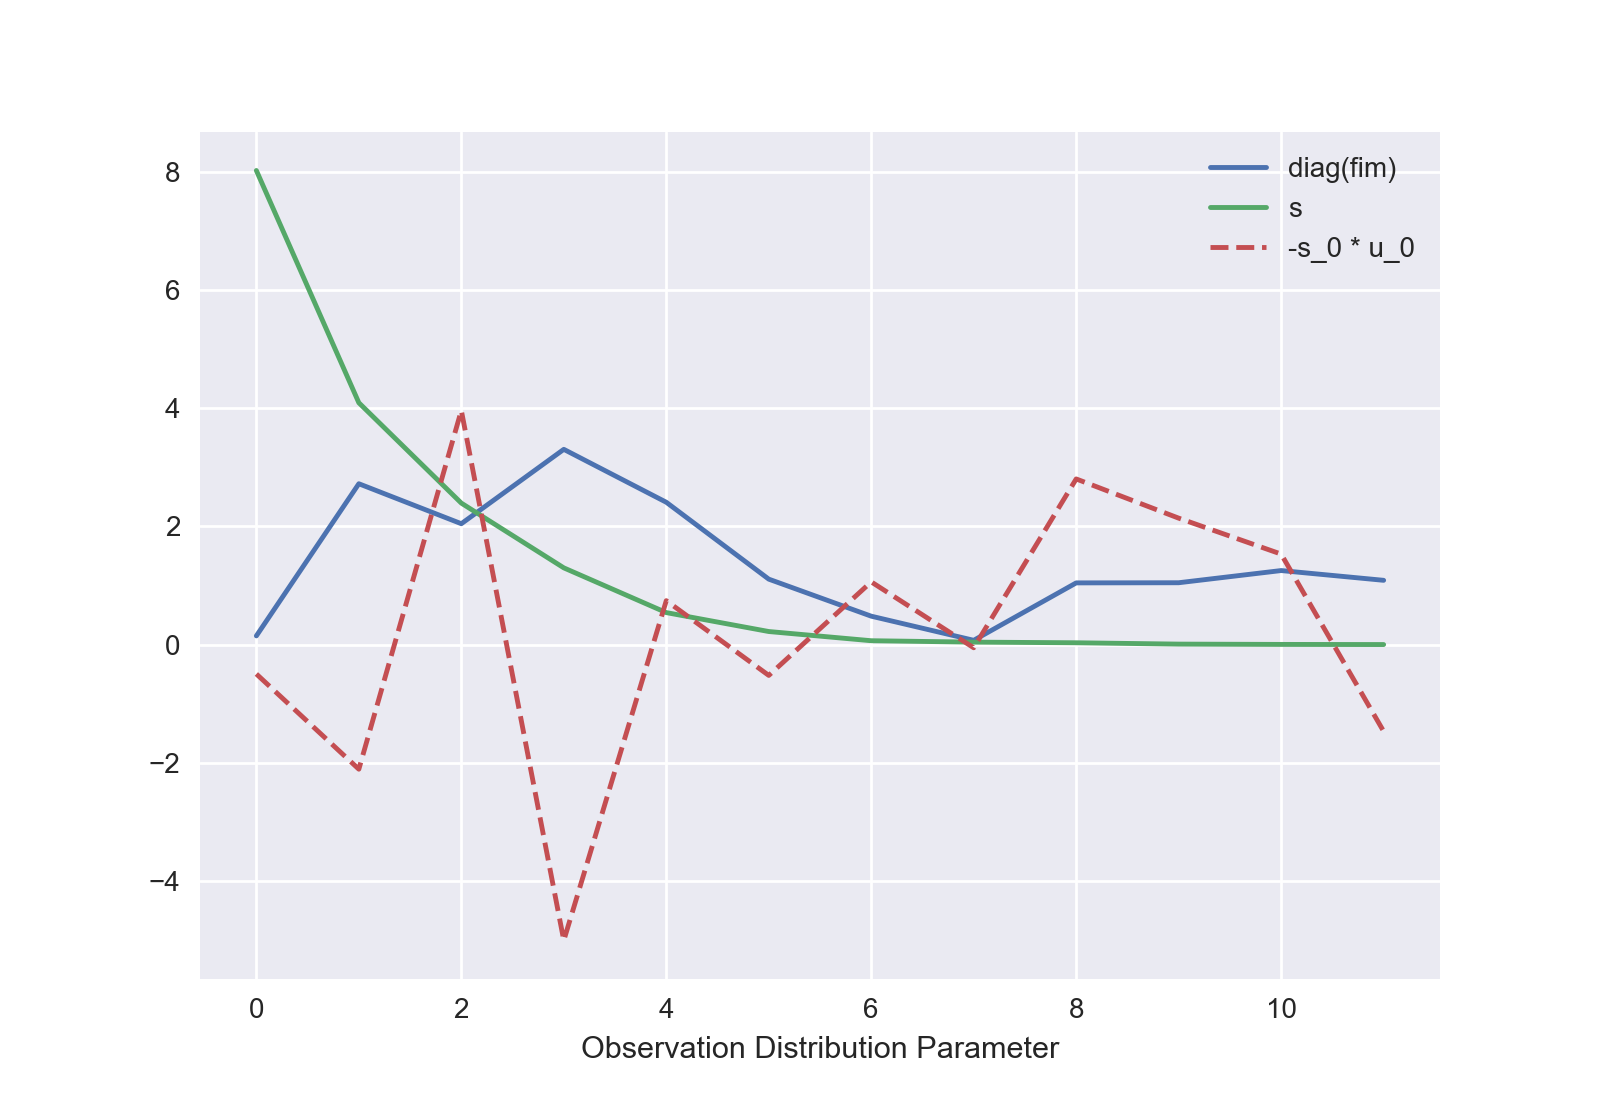

In [66]:
fig = plt.figure()
plt.plot(np.diagonal(fimFull),label="diag(fim)")
plt.plot(s,label="s")
plt.plot(u[:,0]*s[0],"--",label="-s_0 * u_0")
plt.legend()
plt.xlabel('Observation Distribution Parameter')
#plt.ylabel('Magnitude')
plt.show()

In [67]:
derivs['Sing Vec'] = u[:,0]
derivs_print = derivs.drop(['Derivative','FI','Perturbation'],axis=1)
print(derivs_print.to_latex(index=False,formatters={
    'FI Rel'   : '{:.3f}'.format,
    'R 0.1'    : '{:.3f}'.format,
    'Sing Vec' : '{:.3f}'.format,
    }))
derivs_print

\begin{tabular}{lllllrrr}
\toprule
     Name & Observation & Distribution & Parameter & Value & FI Rel & R 0.1 & Sing Vec \\
\midrule
Bulukumba &     arrival &       normal &      mean &    15 &  0.147 & 0.001 &   -0.062 \\
Bulukumba &     arrival &       normal &       std &    10 &  2.723 & 0.014 &   -0.263 \\
Bulukumba &      height &       normal &      mean &    18 &  2.046 & 0.010 &    0.494 \\
Bulukumba &      height &       normal &       std &     5 &  3.305 & 0.017 &   -0.624 \\
  Sumenep &     arrival &       normal &      mean &   240 &  2.409 & 0.012 &    0.093 \\
  Sumenep &     arrival &       normal &       std &    45 &  1.108 & 0.006 &   -0.065 \\
  Sumenep &      height &       normal &      mean &   1.5 &  0.481 & 0.002 &    0.132 \\
  Sumenep &      height &       normal &       std &     1 &  0.072 & 0.000 &   -0.007 \\
Nipa-Nipa &      height &       normal &      mean &     3 &  1.044 & 0.005 &    0.349 \\
Nipa-Nipa &      height &       normal &       std &    

/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1473481791.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(derivs_print.to_latex(index=False,formatters={


Name Observation Distribution Parameter Value    FI Rel     R 0.1  \
0   Bulukumba     arrival       normal      mean    15  0.146992  0.000735   
1   Bulukumba     arrival       normal       std    10  2.722704  0.013614   
2   Bulukumba      height       normal      mean    18  2.046073  0.010230   
3   Bulukumba      height       normal       std     5  3.305300  0.016527   
4     Sumenep     arrival       normal      mean   240  2.409346  0.012047   
5     Sumenep     arrival       normal       std    45  1.107680  0.005538   
6     Sumenep      height       normal      mean   1.5  0.480535  0.002403   
7     Sumenep      height       normal       std     1  0.071983  0.000360   
8   Nipa-Nipa      height       normal      mean     3  1.044187  0.005221   
9   Nipa-Nipa      height       normal       std     2  1.046724  0.005234   
10       Bima      height       normal      mean    10  1.252998  0.006265   
11       Bima      height       normal       std     4  1.087770  0.005439   

    Sing Vec  
0  -0.062063  
1  -0.262881  
2   0.493893  
3  -0.624246  
4   0.092595  
5  -0.065069  
6   0.132238  
7  -0.006776  
8   0.349362  
9   0.266662  
10  0.190838  
11 -0.183047

\begin{tabular}{lll}
\toprule
     Parameter &   Variance & Sensitivity \\
\midrule
      Latitude &   0.108557 &    0.093343 \\
     Longitude &   0.402422 &    0.179718 \\
     Magnitude &   0.021577 &    0.041614 \\
$\Delta$ log L &   0.018109 &    0.038124 \\
$\Delta$ log W &   0.020772 &    0.040831 \\
  Depth Offset &    0.64787 &    0.228032 \\
    Dip Offset &  13.573413 &    1.043748 \\
 Strike Offset &   8.498352 &    0.825883 \\
   Rake Offset &  22.272118 &    1.337002 \\
\bottomrule
\end{tabular}



/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1705881540.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1705881540.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)
/var/folders/t5/qjwb246n55s_3764g3_yv8c40000gn/T/ipykernel_4641/1705881540.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)
/var/folders/t5/qjwb246n5

Parameter   Variance Sensitivity
0        Latitude   0.108557    0.093343
1       Longitude   0.402422    0.179718
2       Magnitude   0.021577    0.041614
3  $\Delta$ log L   0.018109    0.038124
4  $\Delta$ log W   0.020772    0.040831
5    Depth Offset    0.64787    0.228032
6      Dip Offset  13.573413    1.043748
7   Strike Offset   8.498352    0.825883
8     Rake Offset  22.272118    1.337002

<IPython.core.display.Javascript object>


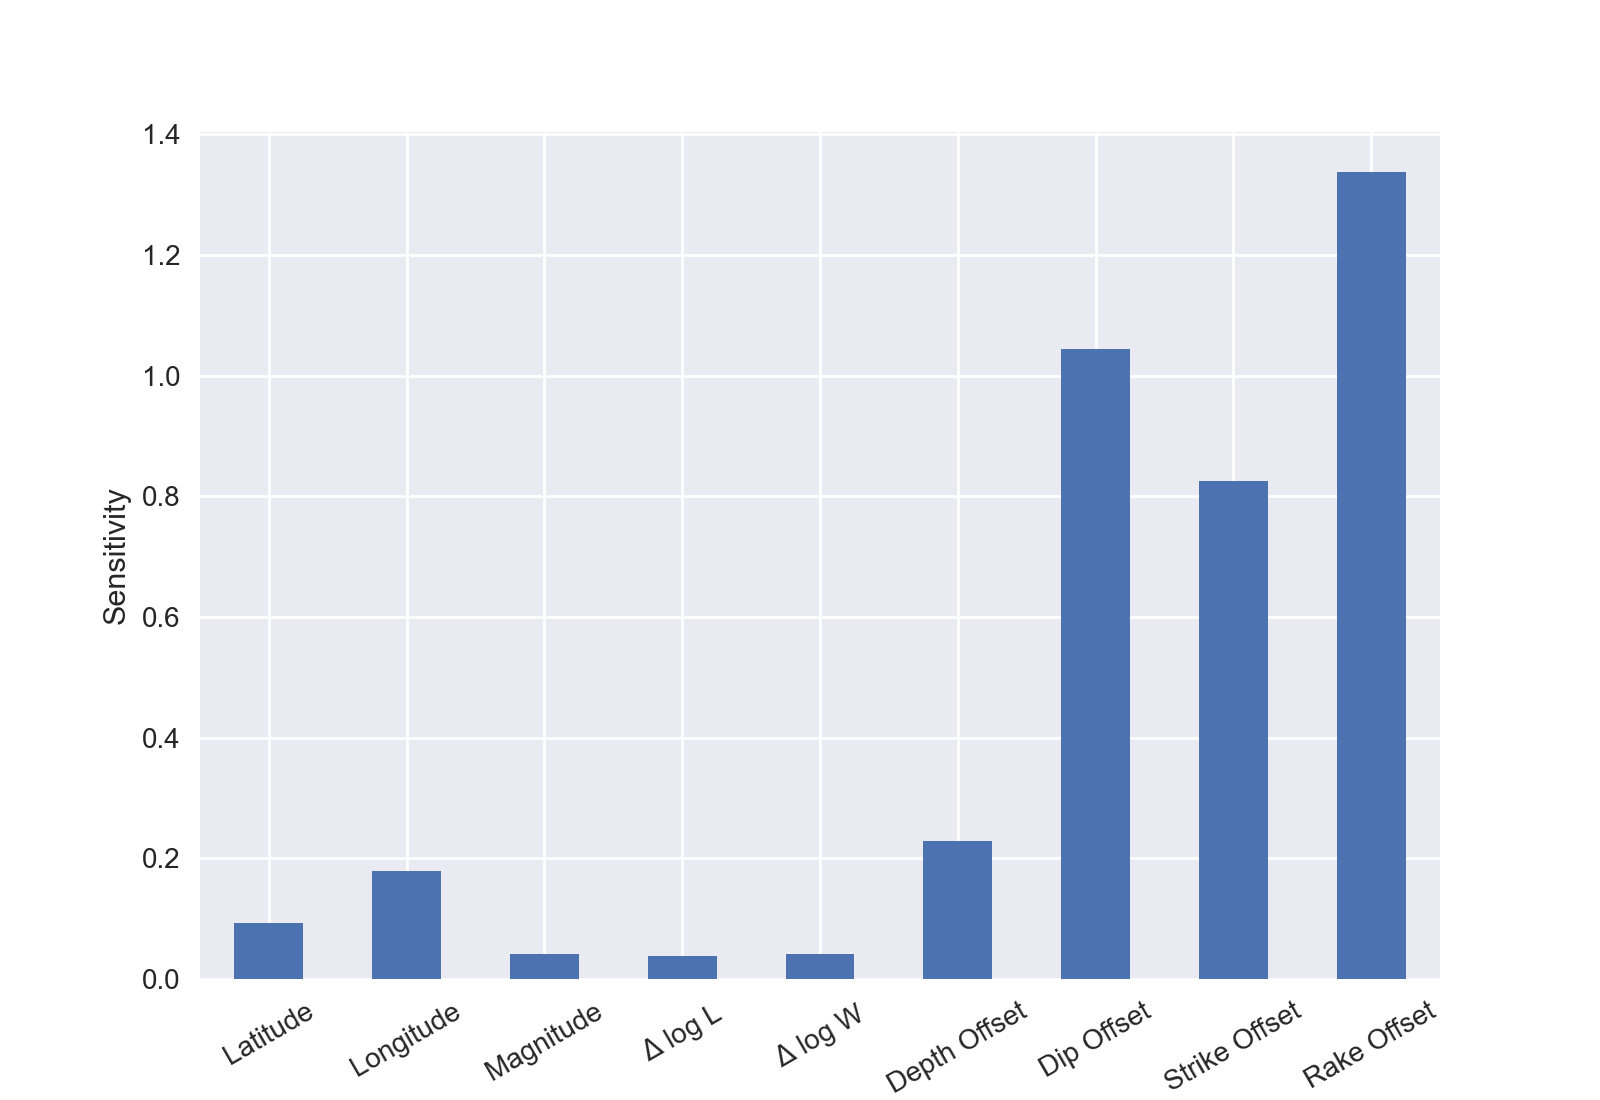

[Text(0, 0.5, 'Sensitivity')]

In [68]:
#Compute sensitivity bounds from equation (2.39)
#for perturbation by first singular vector
#(in which case variance is the first singular value)

nthin = 1 #optional thinning of sample data

normv = 0.1 #size of relative perturbation

sensDF = pd.DataFrame(columns = ['Parameter', 'Variance', 'Sensitivity'])

cols = samples[0].columns[:-1]
ncol = len(cols)

for attr in cols:
    f = flores_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    
    #Equation (2.39)
    sens = np.sqrt(fvar*s[0])*normv

    sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)

sensDF['Parameter'] = [col.replace("_"," ").replace("log","log ").title().replace("Log","log").replace("Delta","$\Delta$") for col in cols]; 
#ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
print(sensDF.to_latex(index=False,escape=False,formatters={
    'Variance' : '{:.3f}'.format,
    'Sensitivity' : '{:.3f}'.format,
    }))

display(sensDF)

#ax = sensDF.loc[sensDF['Parameter'] != 'depth_offset',:].plot(kind='bar',x='Parameter',y='Sensitivity',legend=False)
ax = sensDF.plot(kind='bar',x='Parameter',y='Sensitivity',legend=False)
plt.xticks(rotation=30)
ax.set(ylabel="Sensitivity")

In [69]:
#Compute sensitivity bounds from equation (2.39)

nthin = 1 #optional thinning of sample data

sensDF = derivs.copy()
sensDF = sensDF.drop(['Derivative','FI','Perturbation'],axis=1)

cols = samples[0].columns[:-1]
ncol = len(cols)

for j,attr in enumerate(cols):
    f = flores_samples[attr].values
#    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    print('Variance for',attr,'is:',fvar)
    
    #Equation (2.39)
    sensDF['S_'+attr] = np.sqrt(fvar*sensDF['FI Rel'])

sensDF

Variance for latitude is: 0.10855730991950274
Variance for longitude is: 0.402421509271959
Variance for magnitude is: 0.021576565510160805
Variance for delta_logl is: 0.018108666468946606
Variance for delta_logw is: 0.02077211407452359
Variance for depth_offset is: 0.6478699484381423
Variance for dip_offset is: 13.573413035715923
Variance for strike_offset is: 8.498352498418908
Variance for rake_offset is: 22.2721182355671


Name Observation Distribution Parameter Value    FI Rel     R 0.1  \
0   Bulukumba     arrival       normal      mean    15  0.146992  0.000735   
1   Bulukumba     arrival       normal       std    10  2.722704  0.013614   
2   Bulukumba      height       normal      mean    18  2.046073  0.010230   
3   Bulukumba      height       normal       std     5  3.305300  0.016527   
4     Sumenep     arrival       normal      mean   240  2.409346  0.012047   
5     Sumenep     arrival       normal       std    45  1.107680  0.005538   
6     Sumenep      height       normal      mean   1.5  0.480535  0.002403   
7     Sumenep      height       normal       std     1  0.071983  0.000360   
8   Nipa-Nipa      height       normal      mean     3  1.044187  0.005221   
9   Nipa-Nipa      height       normal       std     2  1.046724  0.005234   
10       Bima      height       normal      mean    10  1.252998  0.006265   
11       Bima      height       normal       std     4  1.087770  0.005439   

    Sing Vec  S_latitude  S_longitude  S_magnitude  S_delta_logl  \
0  -0.062063    0.126321     0.243214     0.056317      0.051593   
1  -0.262881    0.543663     1.046745     0.242377      0.222046   
2   0.493893    0.471292     0.907405     0.210112      0.192488   
3  -0.624246    0.599011     1.153310     0.267052      0.244652   
4   0.092595    0.511422     0.984669     0.228003      0.208878   
5  -0.065069    0.346766     0.667648     0.154596      0.141628   
6   0.132238    0.228398     0.439747     0.101825      0.093284   
7  -0.006776    0.088398     0.170198     0.039410      0.036104   
8   0.349362    0.336681     0.648231     0.150100      0.137509   
9   0.266662    0.337090     0.649018     0.150282      0.137676   
10  0.190838    0.368812     0.710094     0.164424      0.150632   
11 -0.183047    0.343635     0.661621     0.153200      0.140350   

    S_delta_logw  S_depth_offset  S_dip_offset  S_strike_offset  S_rake_offset  
0       0.055257        0.308597      1.412511         1.117673       1.809373  
1       0.237816        1.328141      6.079177         4.810249       7.787194  
2       0.206158        1.151342      5.269934         4.169922       6.750584  
3       0.262027        1.463354      6.698075         5.299963       8.579979  
4       0.223712        1.249377      5.718658         4.524983       7.325383  
5       0.151687        0.847132      3.877498         3.068135       4.966928  
6       0.099909        0.557964      2.553918         2.020830       3.271472  
7       0.038668        0.215953      0.988461         0.782136       1.266181  
8       0.147275        0.822494      3.764728         2.978903       4.822473  
9       0.147454        0.823493      3.769300         2.982521       4.828329  
10      0.161330        0.900988      4.124009         3.263191       5.282699  
11      0.150317        0.839484      3.842492         3.040436       4.922086

<IPython.core.display.Javascript object>


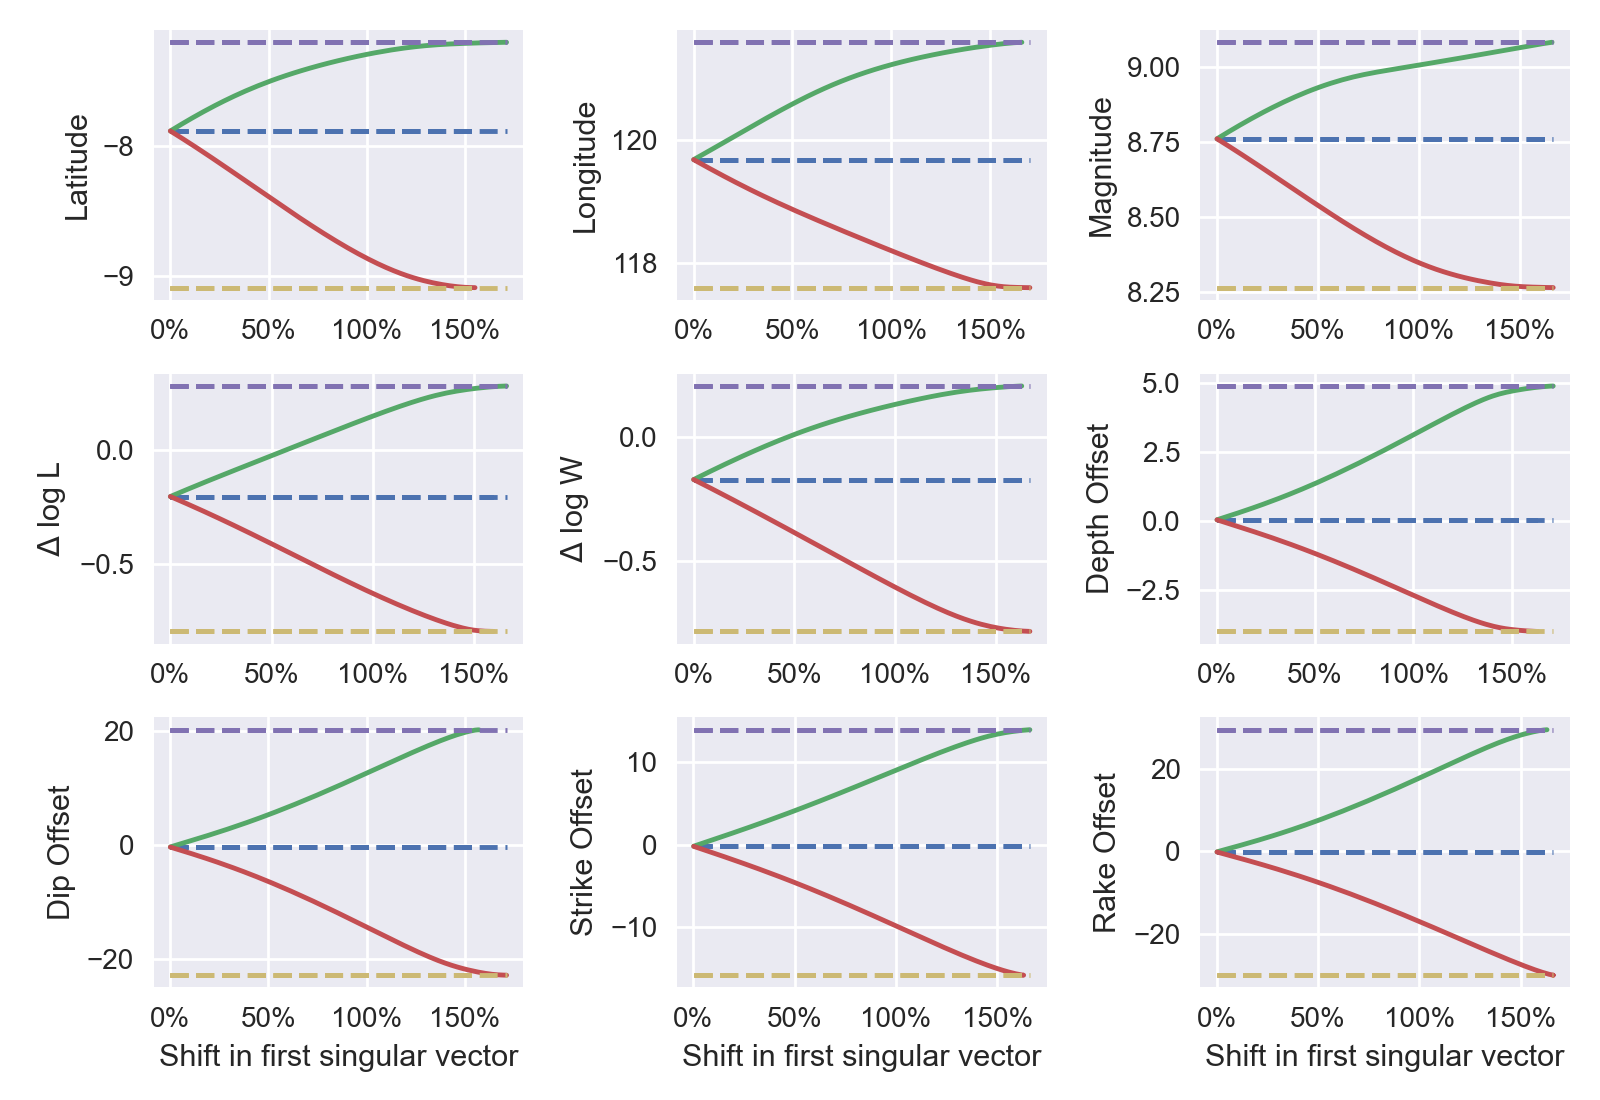

In [70]:
#regenerate the upper/lower bound figure, but in terms of shift by alpha*v_1, 
#where v_1 is the first singular vector

au = np.sqrt(2*flo_Ru/s[0])*100
al = np.sqrt(2*flo_Rl/s[0])*100

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

fig,axs = plt.subplots(3,3)
ylabs = [col.title() for col in cols];
ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset";
ylabs[6]="Dip Offset"; ylabs[7]="Strike Offset"; ylabs[8]="Rake Offset";
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    alph = np.concatenate((al[:,j],au[:,j]))
    ax.plot(alph,EPf[j]*np.ones_like(alph),'--',label='Mean')
    ax.plot(au[:,j],ub[:,j],label='Upper bound')
    ax.plot(al[:,j],lb[:,j],label='Lower bound')
    ax.plot(alph,fmax[j]*np.ones_like(R),'--',label='Max')
    ax.plot(alph,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>5:
        ax.set(xlabel='Shift in first singular vector')
#     ax.set_xlim(0, 25)
    ax.xaxis.set_major_formatter(xticks)

plt.tight_layout()
plt.savefig('flores_dupuis211_sv1.png')
plt.savefig('flores_dupuis211_sv1.pdf')
plt.show()

<IPython.core.display.Javascript object>


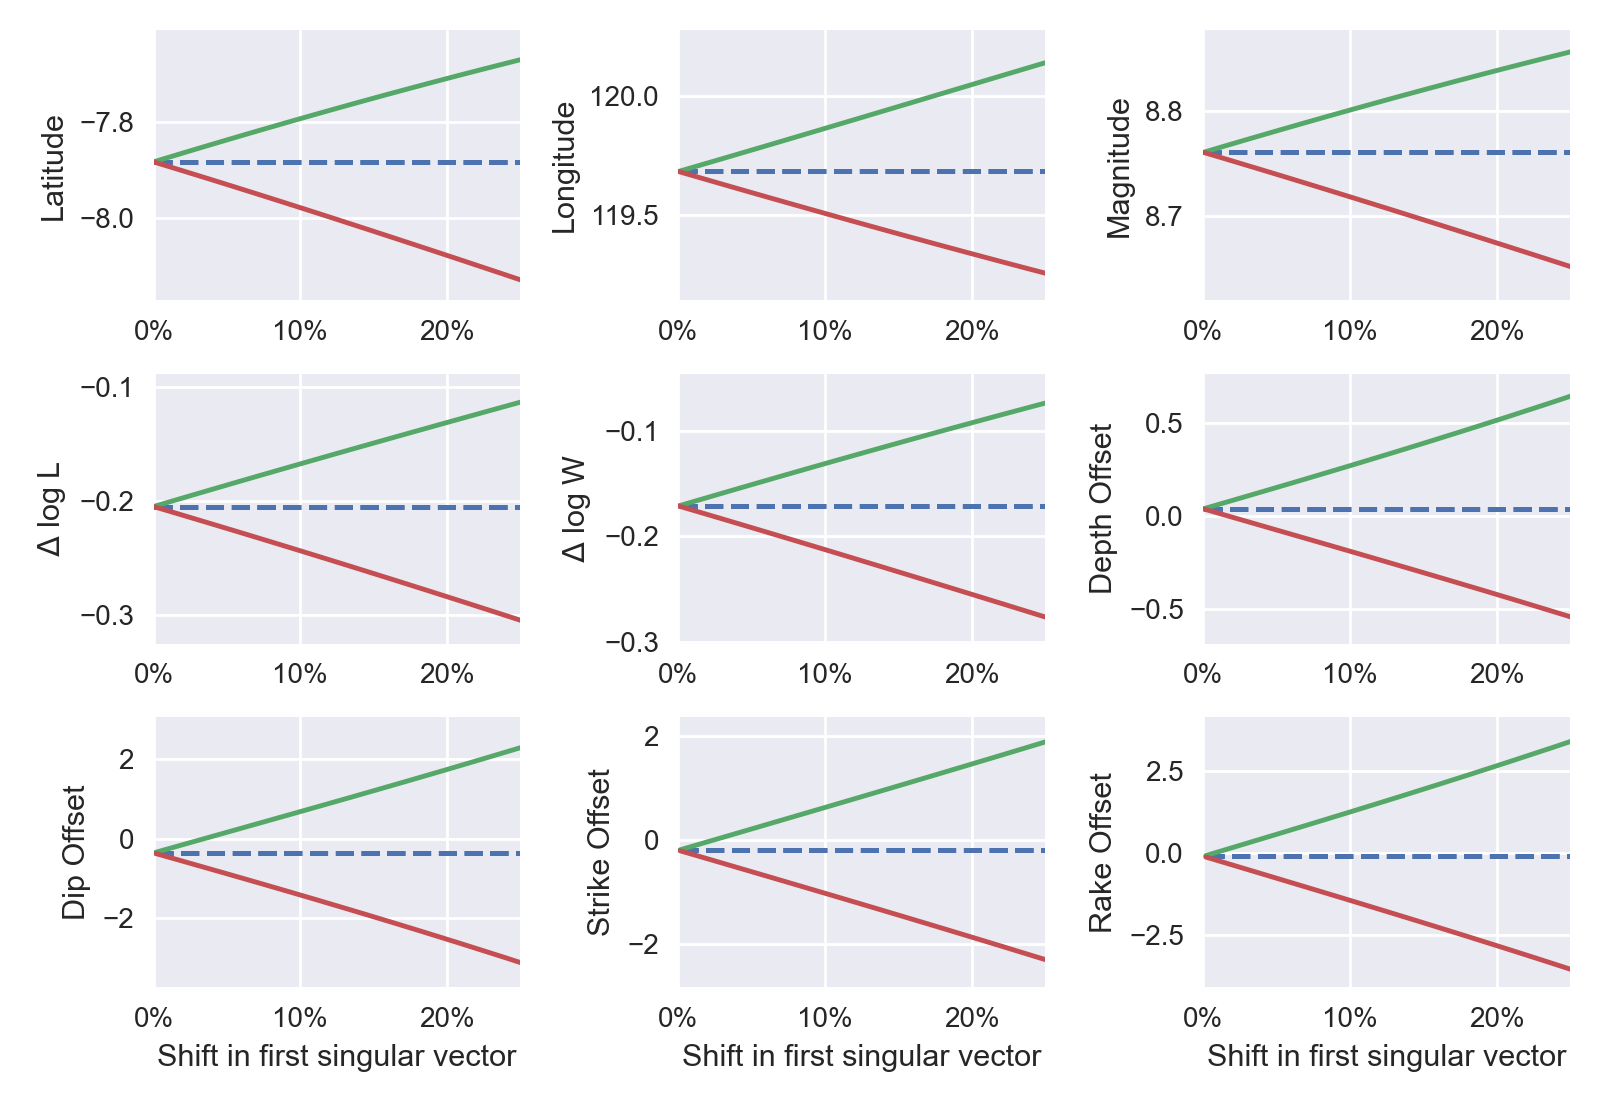

In [71]:
#regenerate the upper/lower bound figure, but in terms of shift by alpha*v_1, 
#where v_1 is the first singular vector

au = np.sqrt(2*flo_Ru/s[0])*100
al = np.sqrt(2*flo_Rl/s[0])*100
xmax = 25

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

fig,axs = plt.subplots(3,3)
ylabs = [col.title() for col in cols];
ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset";
ylabs[6]="Dip Offset"; ylabs[7]="Strike Offset"; ylabs[8]="Rake Offset";
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    idxu  = au[:,j]<=xmax+5
    idxl  = al[:,j]<=xmax+5
    alph = np.concatenate((al[:,j],au[:,j]))
    ax.plot(alph,EPf[j]*np.ones_like(alph),'--',label='Mean')
    ax.plot(au[idxu,j],ub[idxu,j],label='Upper bound')
    ax.plot(al[idxl,j],lb[idxl,j],label='Lower bound')
#     ax.plot(alph,fmax[j]*np.ones_like(R),'--',label='Max')
#     ax.plot(alph,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>5:
        ax.set(xlabel='Shift in first singular vector')
    ax.set_xlim(0, xmax)
    ax.xaxis.set_major_formatter(xticks)

plt.tight_layout()
plt.savefig('flores_dupuis211_sv1.png')
plt.savefig('flores_dupuis211_sv1.pdf')
plt.show()